In [ ]:
!python -V

Python 3.10.12


# Task

Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

По шагам:
0. выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
1. установить удобную для себя среду разработки (pycharm прекрасен - https://www.jetbrains.com/pycharm/)
2. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта конечно же при этом)
3. завести себе аккаунт на github (если его еще нет). У самого github есть такой "hello world" по работе с ним - https://guides.github.com/activities/hello-world/
4. итоговый проект должен содержать: 1) каталог app/models/ (здесь модель-пайплайн предобученная либо код обучения модели-пайплайна) 2) файл app/run_server.py (здесь основной код flask-приложения) 3) requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта) 4) README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д) 5) Dockerfile 6) docker-entrypoint.sh
5. (<b>Опционально</b>): front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

# Additional links

1. датасеты (для полета мысли): https://www.kaggle.com/datasets
2. конкурс Сбербанка по недвижимости (можно этот набор данных также взять и обучить модель предсказывать стоимость жилья - неплохой такой сервис может получиться) - https://www.kaggle.com/c/sberbank-russian-housing-market/data Там же и ноутбуки с разными подходами есть.
3. минималистичный пример связки keras/flask https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html для определения класса картинки
4. неплохой такой пример (помимо того, что разобрали на занятии) связки docker/flask - https://cloud.croc.ru/blog/byt-v-teme/flask-prilozheniya-v-docker/
5. https://www.digitalocean.com/community/tutorials/how-to-build-and-deploy-a-flask-application-using-docker-on-ubuntu-18-04
6. https://www.youtube.com/watch?v=6jxveKOdyNg&list=PLA0M1Bcd0w8yrxtwgqBvT6OM4HkOU3xYn

p.s. если проблемы с выбором датасета, то пишите пожалуйста - будем вместе думать)

# I Libraries and Functions

## 1 Importing libraries


In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
# !pip install catboost

In [ ]:
import os
import shutil
import time
import dill
import numpy as np
import pandas as pd
from google.colab import drive, files
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import f1_score, precision_score, recall_score, \
#     roc_auc_score, roc_curve, precision_recall_curve, \
#     classification_report, confusion_matrix, r2_score, accuracy_score
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
import seaborn as sns
import pickle
from xgboost import XGBRFRegressor
# from catboost import CatBoostRegressor
import itertools

## 2 Definition of functions

In [ ]:
star = lambda x:"\n" + x*50 + "\n"

def Mkdir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform
    additional transformations on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]

        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

def Learning_model(ppln : "Pipeline", clsfr_param : dict, model, x_train, y_train):
    print(model.__name__)
    ppln.steps.append(('clf', model(random_state=42, **clsfr_param[model.__name__])))
    ppln.verbose = True
    ppln.fit(x_train, y_train)
    return ppln

def Graff(DF, col1:str, col2:str, w=5, h=5):
    plt.figure(figsize=(w,h))
    sns.jointplot(data=DF, x=col1, y=col2, kind='reg')
    plt.show()

def HIST (DF, b=50, w=16, h=8):
    DF.hist(figsize=(w, h), bins=b, grid=False)

def Mean_Median_Mode(DF, divisor=1000, q_min=0.01, q_max=0.99, y_max=1, b=50, w=12, h=6, ret=0, show=1):
    '''If ret = 1 then func return (target_mean, target_median, target_mode, quant_min, quant_max)
        show = 1 then func show graff'''

    target_mean = round(DF.mean(), 2)
    target_median = DF.median()
    target_mode = DF.mode()[0]
    y_max_div = y_max*divisor
    quant_min = round(np.quantile(DF, q=q_min),1)
    quant_max = round(np.quantile(DF, q=q_max),1)

    if show == 1:
        plt.figure(figsize = (w, h))

        sns.histplot(DF, bins=b, kde=True)

        y = np.linspace(0, y_max_div, 10)
        plt.plot([target_mean] * 10, y, label=f'mean {target_mean}', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label=f'median {target_median}', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label=f'mode {target_mode}', linestyle='-.', linewidth=4)
        plt.plot([quant_min] * 10, y, label=f'quant {q_min}={quant_min}', linestyle='solid', linewidth=2)
        plt.plot([quant_max] * 10, y, label=f'quant {q_max}={quant_max}', linestyle='solid', linewidth=2)

        plt.title(f'Distribution of {DF.name}')
        plt.legend()
        plt.show()
    if ret == 1:
        return target_mean, target_median, target_mode, quant_min, quant_max

def Fill_Empty_Nan_Mode(data:pd.DataFrame, feature: str, max_mode: int):
    top_mode_list = data[feature].value_counts().index[:max_mode]
    data.loc[data[feature].isna(), [feature]] = "Unknown"
    for k,v in data[feature].items():
        if v == "Unknown":
            data[feature][k] = np.random.choice(top_mode_list)

def Fill_Empty_Nan_Median(data:pd.DataFrame, feature: str):
    target_median = data[feature].median()
    data.loc[data[feature].isna(), [feature]] = target_median


def Null_Dict(df):
    nul_dict = {k:round((v / df.shape[0]) * 100, 2) for (k, v) in df.isna().sum().items() if v > 0}
    return nul_dict

def Corr_Barplot(DF:pd.DataFrame, thresholds: float = 0.0, w:int = 8, h:int = 12):
    """You should place the target variable in the last column
    return: dict"""
    corr_with_target = DF.corr().iloc[:-1,-1].sort_values(ascending=False)
    corr_with_target = {k:v for k,v in corr_with_target.items() if np.abs(v) > thresholds}
    plt.figure(figsize=(w,h))
    sns.barplot(x=corr_with_target.values(), y=corr_with_target.keys())
    plt.title('Correlation with target variable')
    plt.show()
    return corr_with_target

def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""

    r2_metrics = round(r2(true_values, pred_values), 3)

    print("R2:\t" + str(r2_metrics) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

    plt.figure(figsize=(8,8))

    # sns.scatterplot(x=pred_values, y=true_values.values)
    plt.scatter(pred_values, true_values.values, s=2)
    max_true = max(true_values.values)[0]
    plt.plot([0, max_true], [0, max_true], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()
    return r2_metrics

def save_model_dill(path, model_name):
    with open(path, "wb") as mod:
        dill.dump(model_name, mod)

def load_model_dill(path):
    with open(path, "rb") as mod1:
        model_name = dill.load(mod1)
    return model_name

def save_model_pkl(path, model_name):
    with open(path, "wb") as mod:
        pickle.dump(model_name, mod)


def load_model_pkl(path):
    with open(path, "rb") as mod1:
        model_name = pickle.load(mod1)
    return model_name

# II Preporation Data

## 3 Load dataset

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path_to_work_dir = "/content/drive/MyDrive/Course_project_MOB/"

In [ ]:
# Mkdir(path_to_work_dir)

In [ ]:
# new_file = files.upload()

In [ ]:
# shutil.move("/content/Sberbank_Russian_Housing_Market_Data.csv.zip", path_to_work_dir)

In [ ]:
# !unzip "/content/drive/MyDrive/Course_project_MOB/Sberbank_Russian_Housing_Market_Data.csv.zip" -d "/content/drive/MyDrive/Course_project_MOB/"

## 4 Review dataset

In [ ]:
df = pd.read_csv(path_to_work_dir + "train_without_noise.csv")
df.head(5)

id   timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1  2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2  2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3  2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4  2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5  2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq  ...  cafe_count_5000_price_2500  \
0       NaN       NaN  ...                           9   
1       NaN       NaN  ...                          15   
2       NaN       NaN  ...                          10   
3       NaN       NaN  ...                          11   
4       NaN       NaN  ...                         319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1                          3                          0   
2                          3                          0   
3                          2                          1   
4                        108                         17   

   big_church_count_5000  church_count_5000  mosque_count_5000  \
0                     13                 22                  1   
1                     15                 29                  1   
2                     11                 27                  0   
3                      4                  4                  0   
4                    135                236                  2   

   leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                   0                52                  4    5850000  
1                  10                66                 14    6000000  
2                   4                67                 10    5700000  
3                   0                26                  3   13100000  
4                  91               195                 14   16331452  

[5 rows x 292 columns]

In [ ]:
df.drop("id", axis=1, inplace=True)

In [ ]:
target = "price_doc"

In [ ]:
df.columns

Index(['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=291)

In [ ]:
df.shape

(28895, 291)

## 5 Clear NaN values

In [ ]:
nul_dict = Null_Dict(df)

In [ ]:
nul_dict_sort = dict(sorted(nul_dict.items(), key=lambda item: item[1], reverse=True))

### 5.1 Review feature with NaN

Text(0.5, 0, 'Percents of NaN')

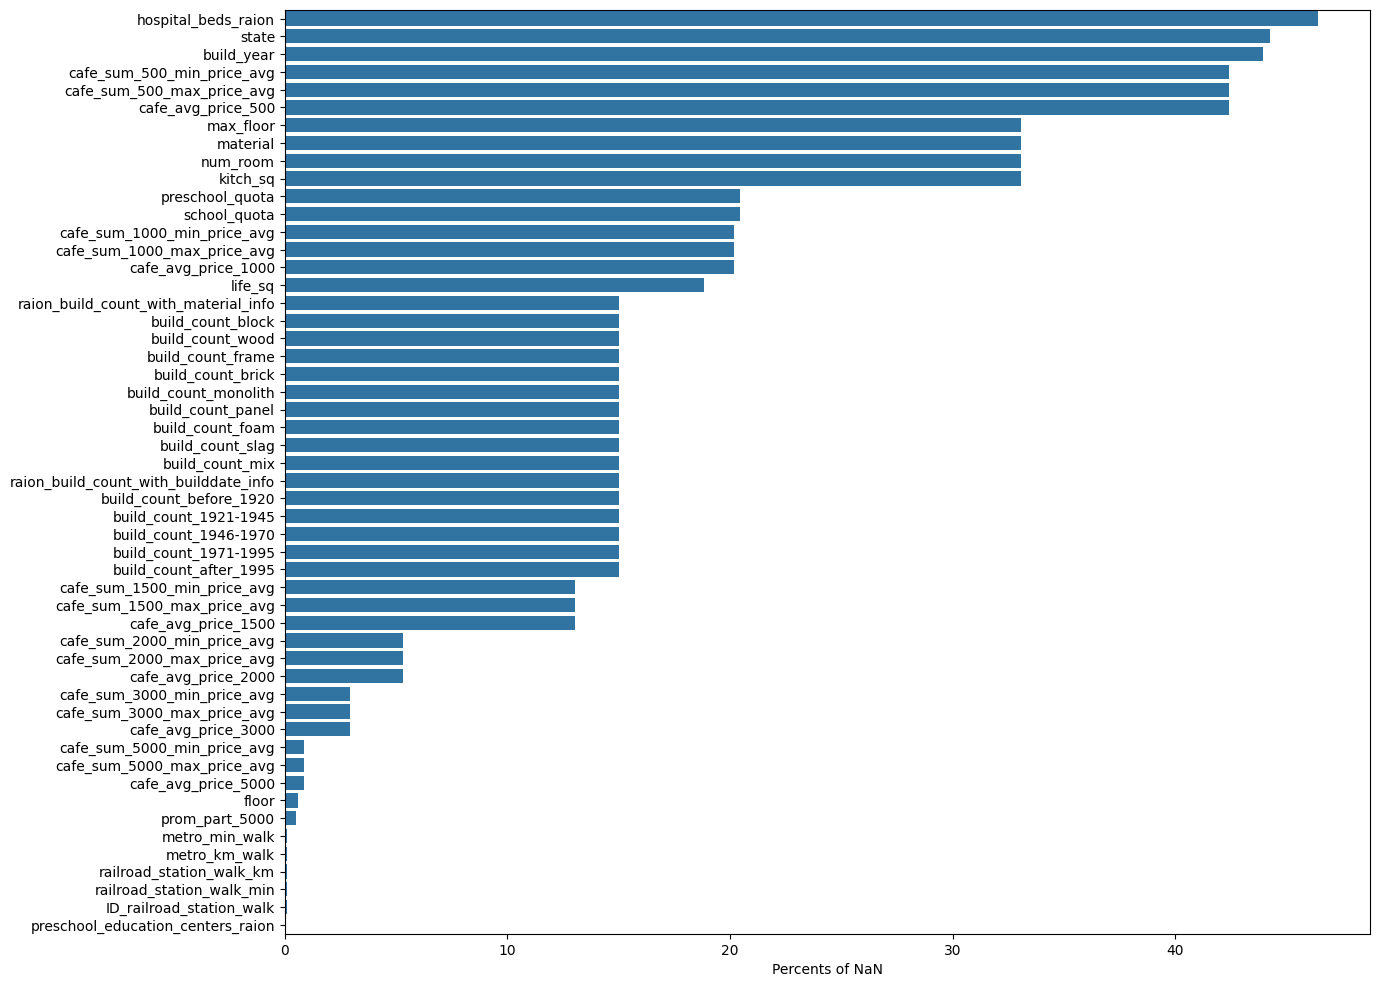

In [ ]:
plt.figure(figsize=(14,12))
sns.barplot(x=nul_dict_sort.values(), y=nul_dict_sort.keys())
plt.xlabel("Percents of NaN")

### 5.2 Clear features less 10% NaN

In [ ]:
[(k,v) for k,v in nul_dict_sort.items() if v < 10]

[('cafe_sum_2000_min_price_avg', 5.32),
 ('cafe_sum_2000_max_price_avg', 5.32),
 ('cafe_avg_price_2000', 5.32),
 ('cafe_sum_3000_min_price_avg', 2.93),
 ('cafe_sum_3000_max_price_avg', 2.93),
 ('cafe_avg_price_3000', 2.93),
 ('cafe_sum_5000_min_price_avg', 0.85),
 ('cafe_sum_5000_max_price_avg', 0.85),
 ('cafe_avg_price_5000', 0.85),
 ('floor', 0.57),
 ('prom_part_5000', 0.51),
 ('metro_min_walk', 0.08),
 ('metro_km_walk', 0.08),
 ('railroad_station_walk_km', 0.08),
 ('railroad_station_walk_min', 0.08),
 ('ID_railroad_station_walk', 0.08),
 ('preschool_education_centers_raion', 0.0)]

In [ ]:
df[[k for k,v in nul_dict_sort.items() if v < 10]].isna().sum()

cafe_sum_2000_min_price_avg          1538
cafe_sum_2000_max_price_avg          1538
cafe_avg_price_2000                  1538
cafe_sum_3000_min_price_avg           848
cafe_sum_3000_max_price_avg           848
cafe_avg_price_3000                   848
cafe_sum_5000_min_price_avg           247
cafe_sum_5000_max_price_avg           247
cafe_avg_price_5000                   247
floor                                 166
prom_part_5000                        147
metro_min_walk                         24
metro_km_walk                          24
railroad_station_walk_km               24
railroad_station_walk_min              24
ID_railroad_station_walk               24
preschool_education_centers_raion       1
dtype: int64

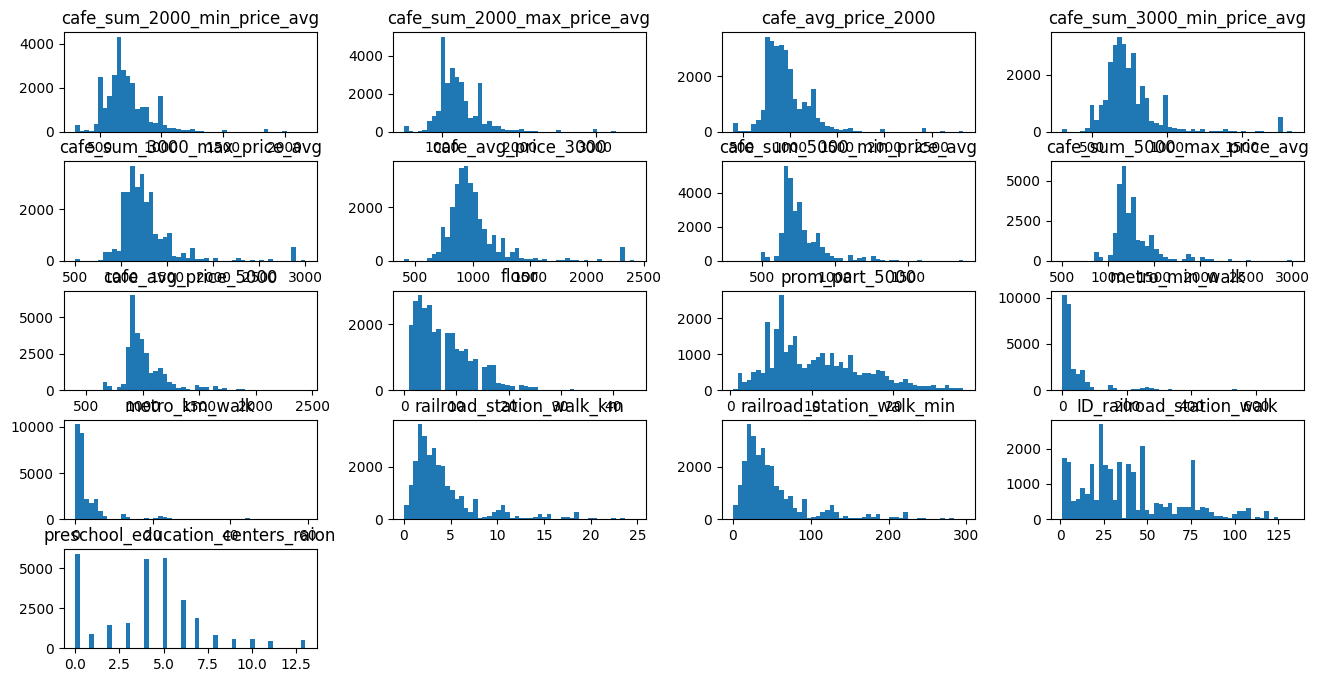

In [ ]:
HIST(df[[k for k,v in nul_dict_sort.items() if v < 10]])

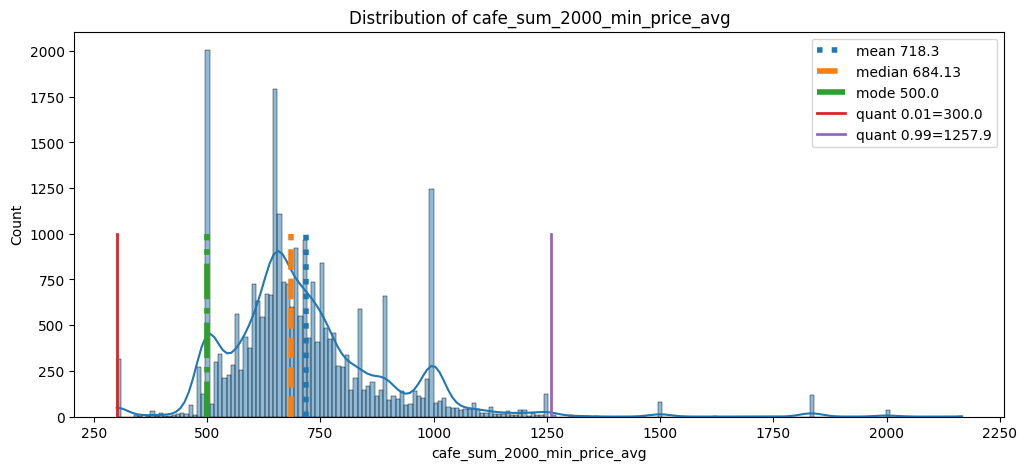

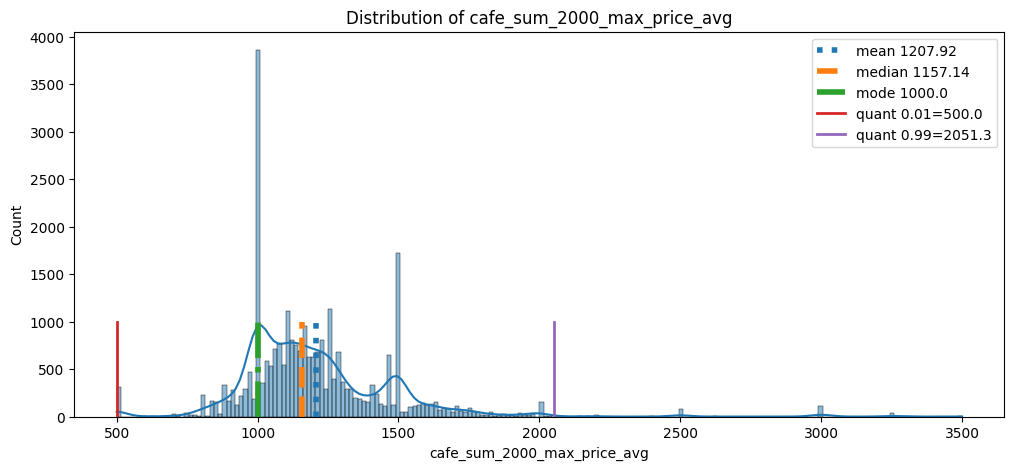

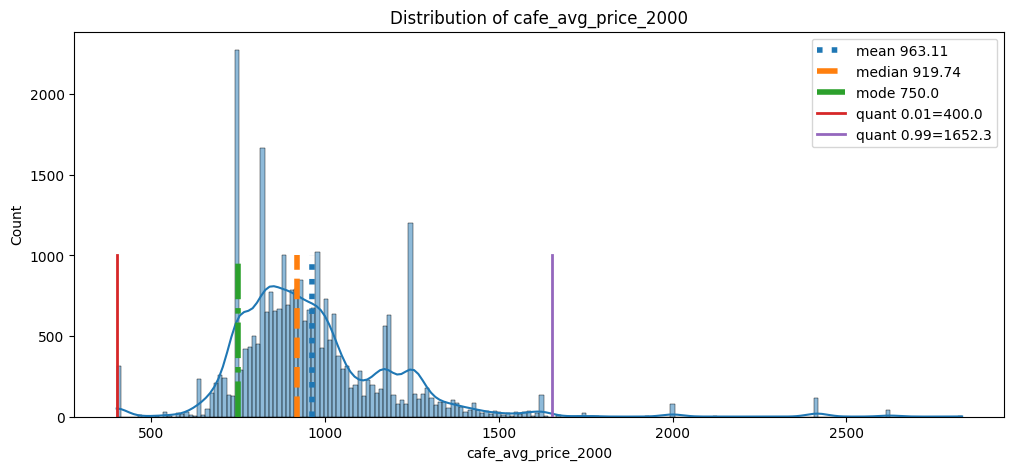

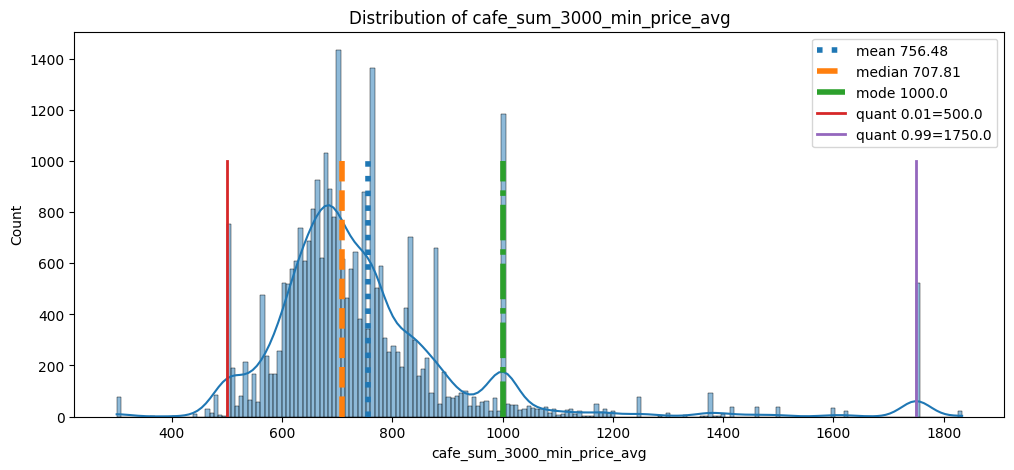

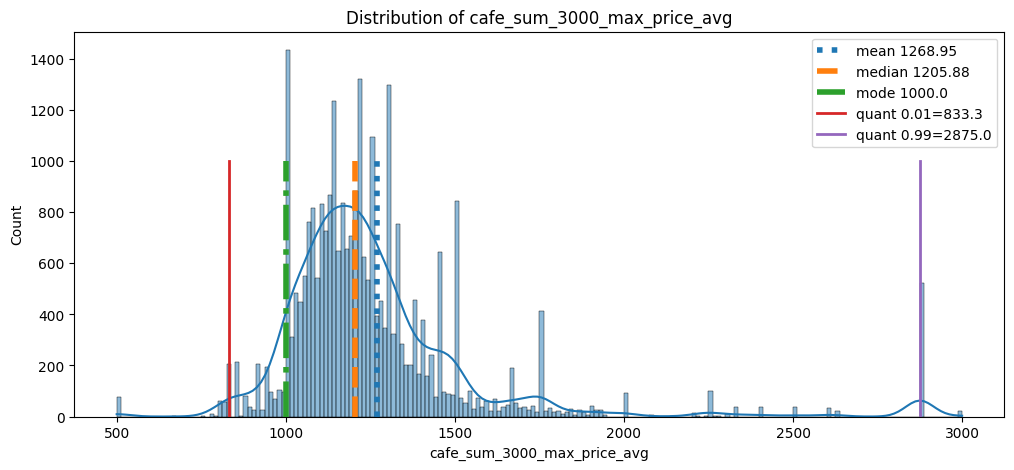

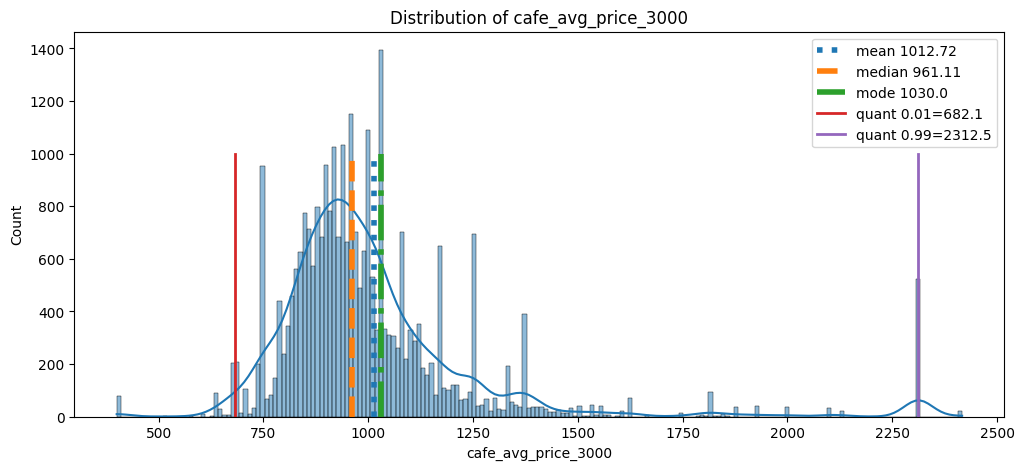

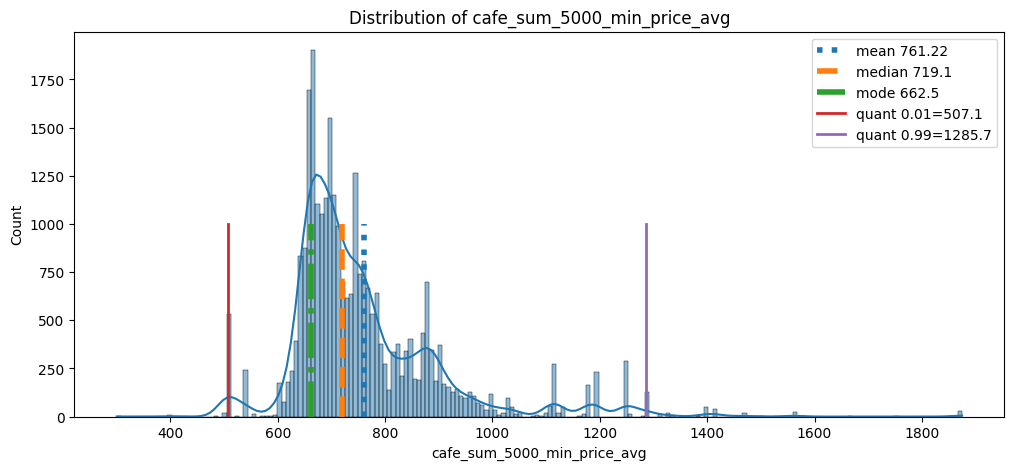

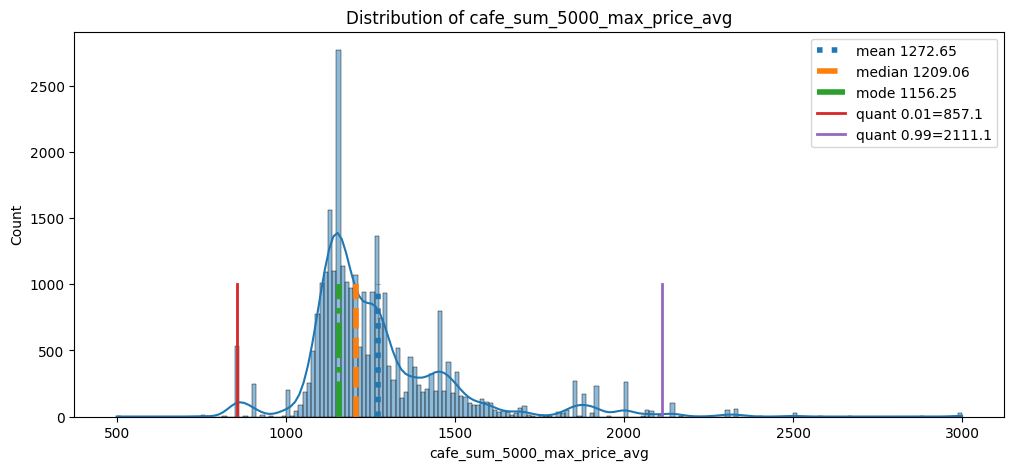

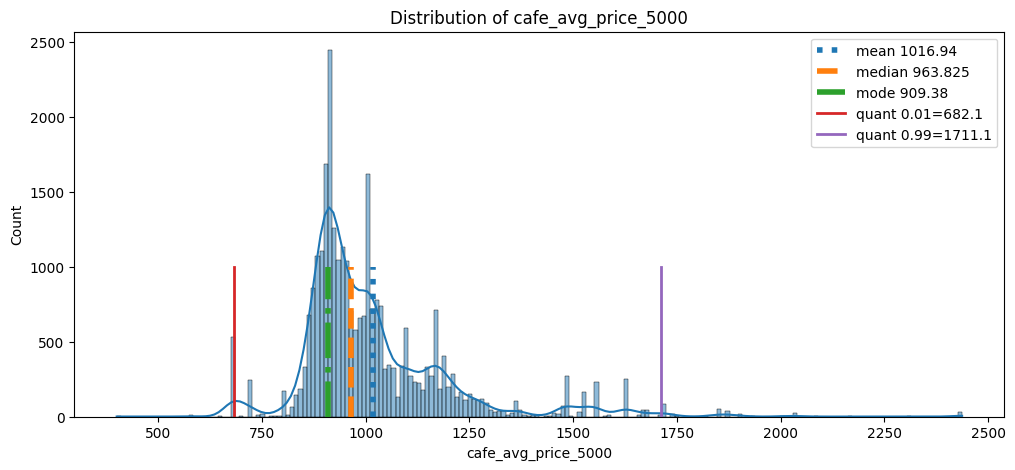

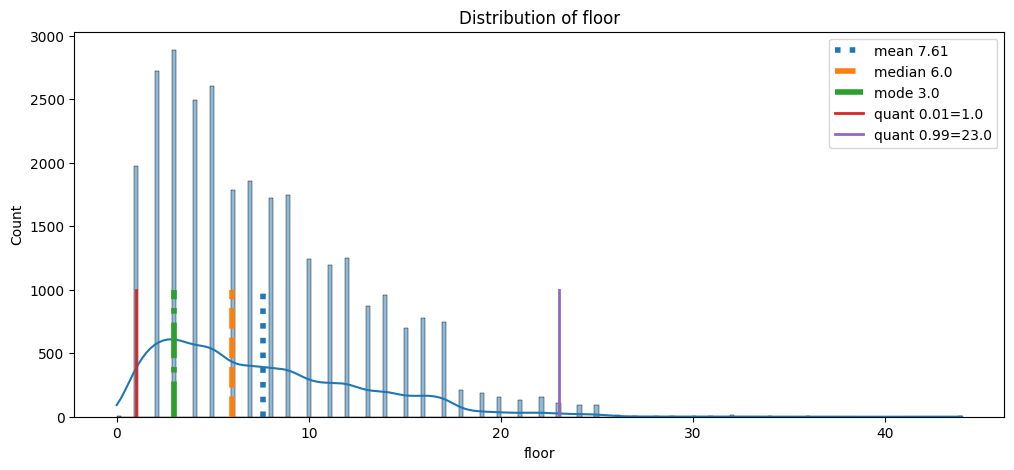

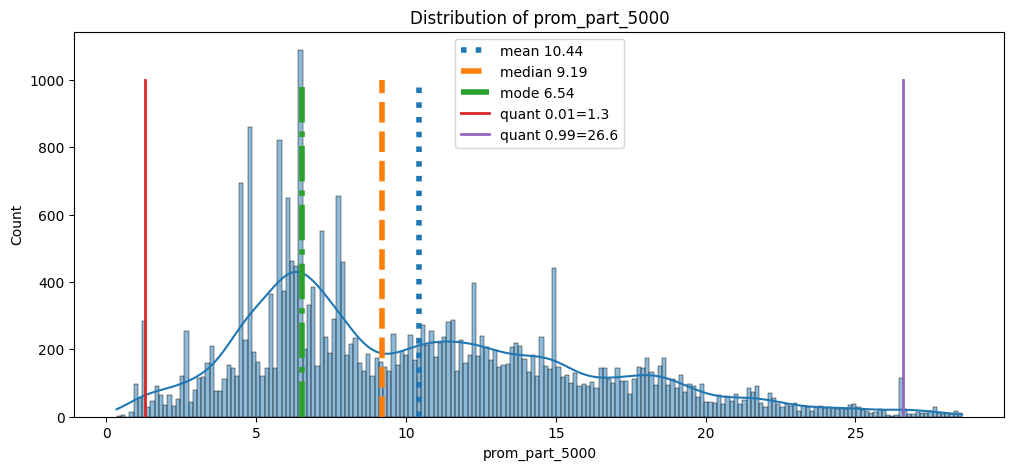

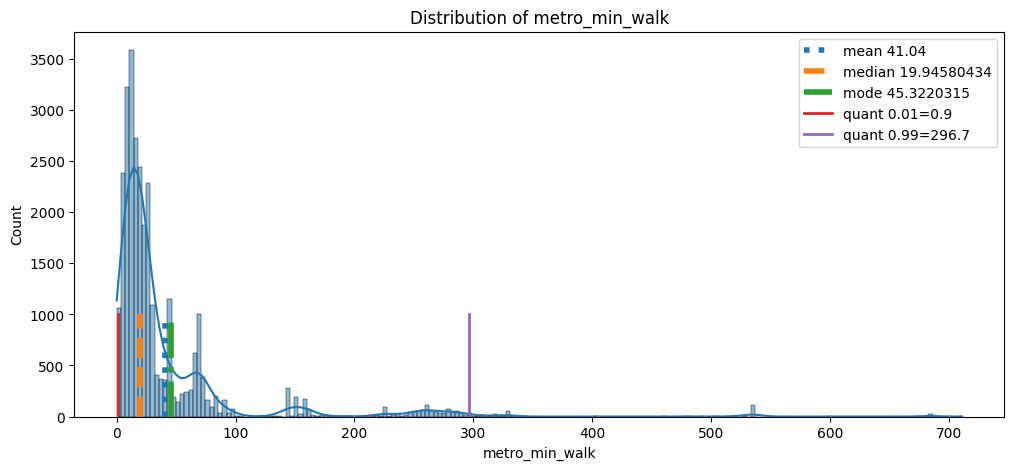

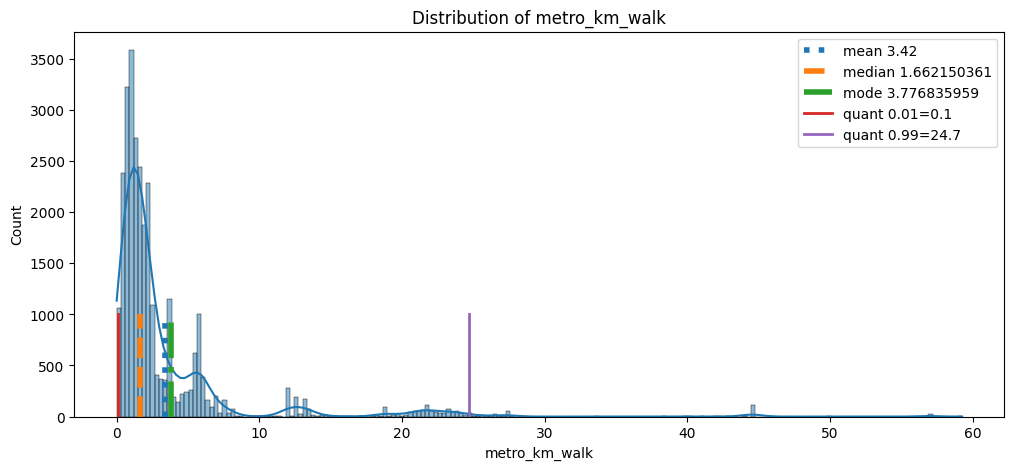

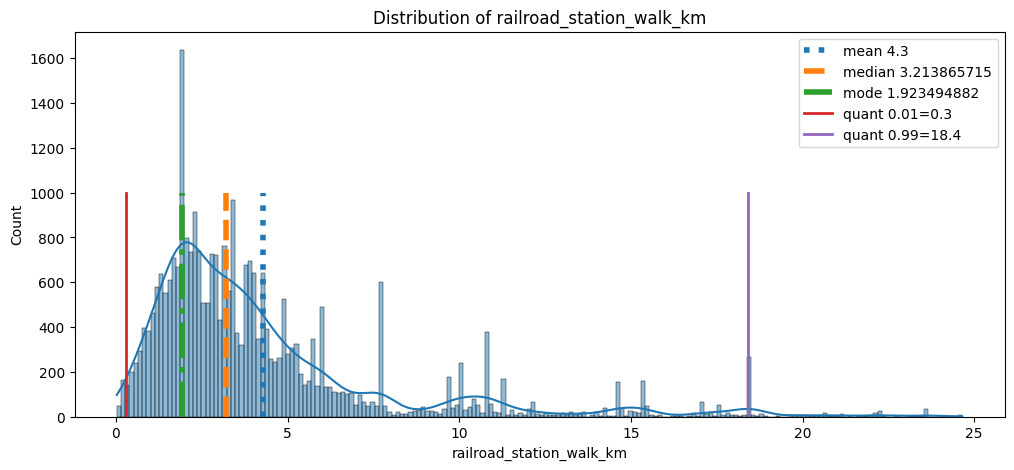

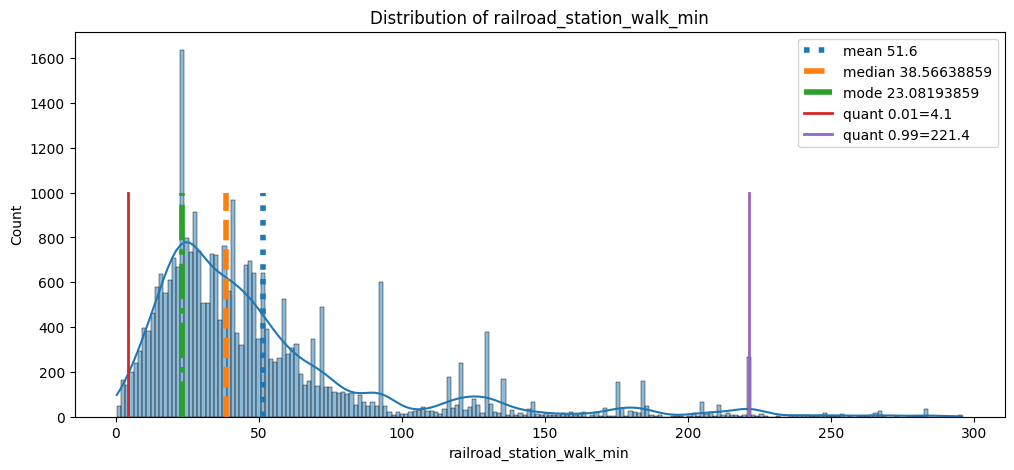

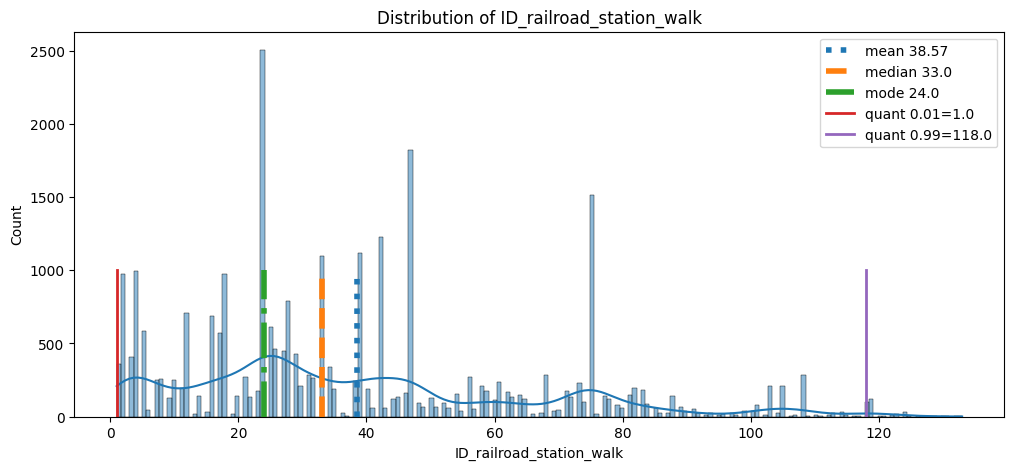

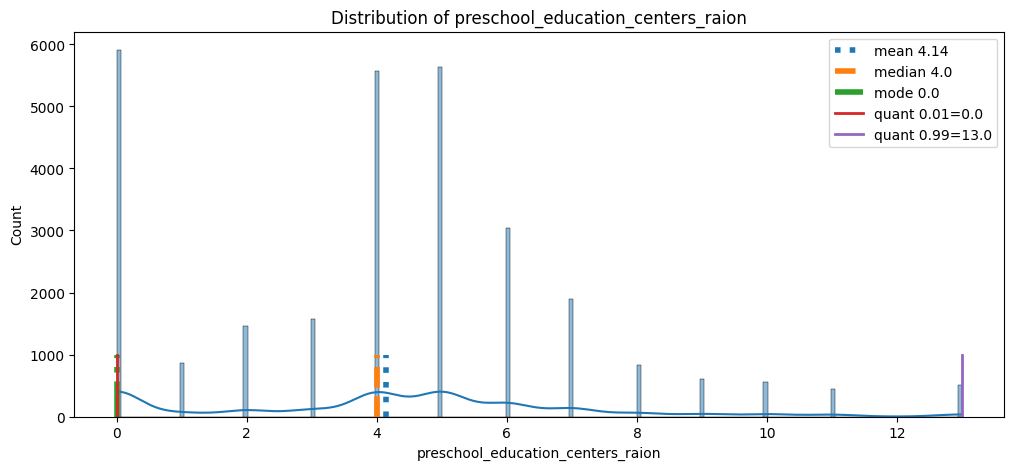

In [ ]:
for col in df[[k for k,v in nul_dict_sort.items() if v < 10]]:
    Mean_Median_Mode(df[df[col].notna()][col], b=200, w=12, h=5)

#### 5.2.1 Split feature for filling on Mode and Median

In [ ]:
median_columns_10 = ["cafe_sum_2000_min_price_avg", "cafe_sum_2000_max_price_avg",
                  "cafe_avg_price_2000", "cafe_sum_3000_min_price_avg",
                  "cafe_sum_3000_max_price_avg", "cafe_avg_price_3000",
                  "metro_min_walk", "metro_km_walk"]

mode_columns_10 = ["cafe_sum_5000_min_price_avg", "cafe_sum_5000_max_price_avg",
                "cafe_avg_price_5000", "floor", "prom_part_5000",
                "railroad_station_walk_km", "railroad_station_walk_min",
                "ID_railroad_station_walk", "preschool_education_centers_raion"]

In [ ]:
for col in df[median_columns_10]:
    Fill_Empty_Nan_Median(df, col)

In [ ]:
for col in df[mode_columns_10]:
    Fill_Empty_Nan_Mode(df, col, 1)

In [ ]:
df[mode_columns_10] = df[mode_columns_10].astype(float)

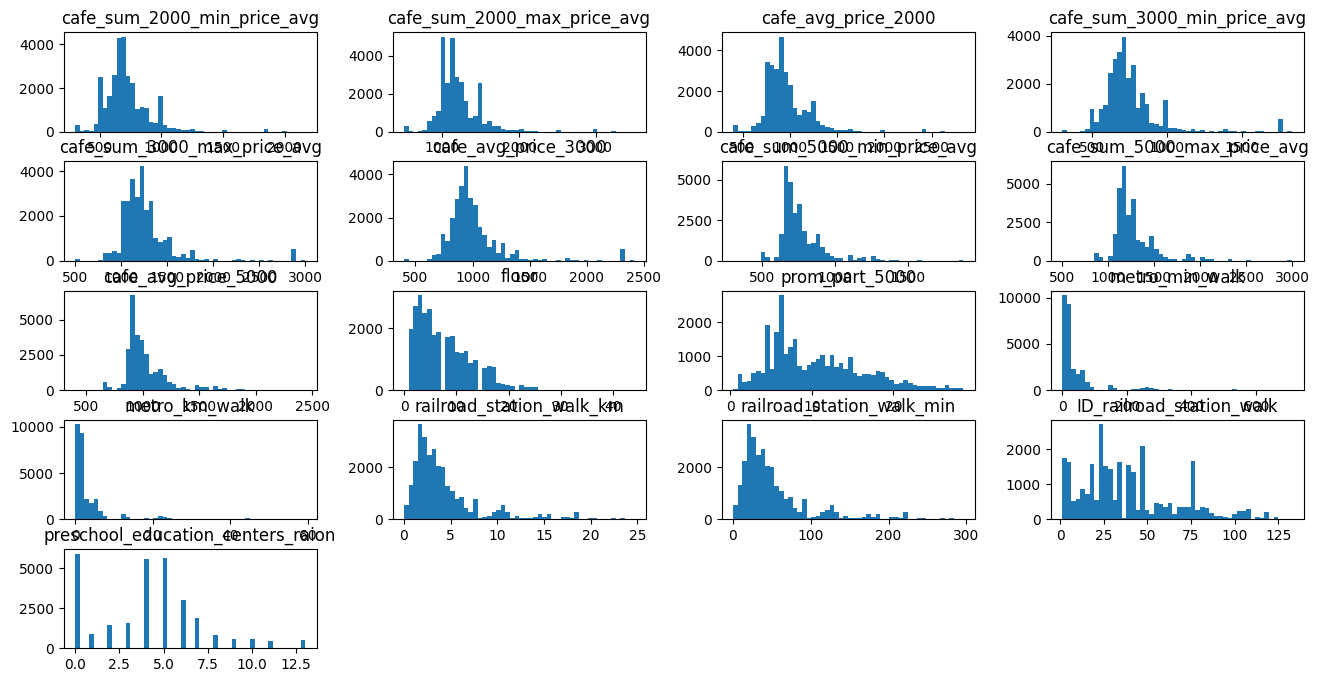

In [ ]:
HIST(df[[k for k,v in nul_dict_sort.items() if v < 10]])

In [ ]:
df[mode_columns_10].isna().sum()

cafe_sum_5000_min_price_avg          0
cafe_sum_5000_max_price_avg          0
cafe_avg_price_5000                  0
floor                                0
prom_part_5000                       0
railroad_station_walk_km             0
railroad_station_walk_min            0
ID_railroad_station_walk             0
preschool_education_centers_raion    0
dtype: int64

In [ ]:
df[median_columns_10].isna().sum()

cafe_sum_2000_min_price_avg    0
cafe_sum_2000_max_price_avg    0
cafe_avg_price_2000            0
cafe_sum_3000_min_price_avg    0
cafe_sum_3000_max_price_avg    0
cafe_avg_price_3000            0
metro_min_walk                 0
metro_km_walk                  0
dtype: int64

Text(0.5, 0, 'Percents of NaN')

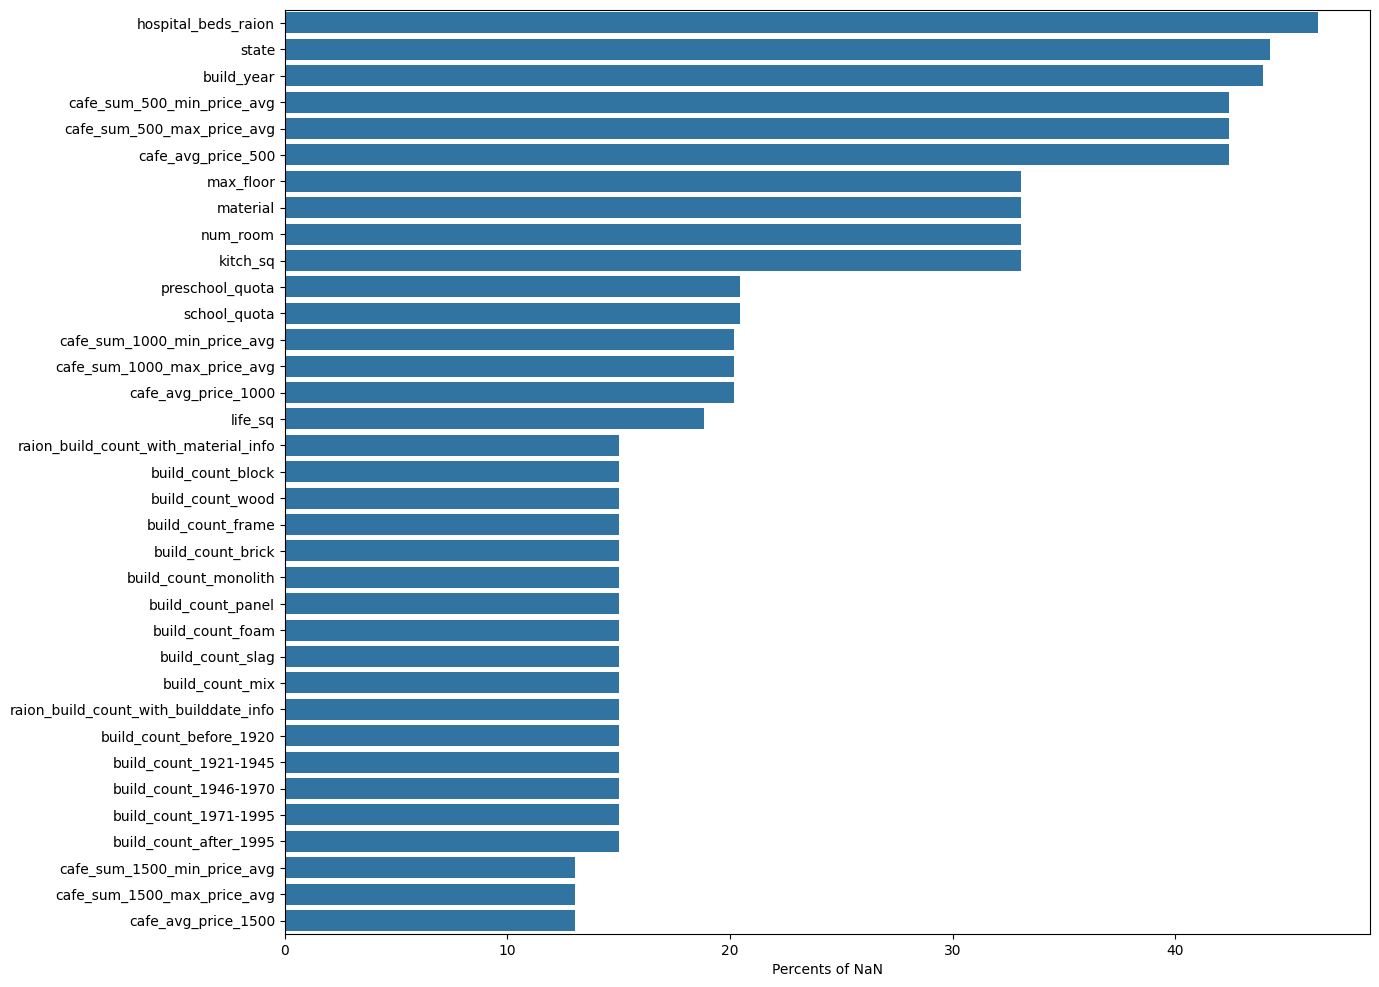

In [ ]:
nul_dict_1 = Null_Dict(df)
nul_dict_sort_1 = dict(sorted(nul_dict_1.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(14,12))
sns.barplot(x=nul_dict_sort_1.values(), y=nul_dict_sort_1.keys())
plt.xlabel("Percents of NaN")

### 5.3 Clear feature less 20% NaN

In [ ]:
df[[k for k,v in nul_dict_sort_1.items() if v < 20]].isna().sum()

life_sq                                  5437
raion_build_count_with_material_info     4343
build_count_block                        4343
build_count_wood                         4343
build_count_frame                        4343
build_count_brick                        4343
build_count_monolith                     4343
build_count_panel                        4343
build_count_foam                         4343
build_count_slag                         4343
build_count_mix                          4343
raion_build_count_with_builddate_info    4343
build_count_before_1920                  4343
build_count_1921-1945                    4343
build_count_1946-1970                    4343
build_count_1971-1995                    4343
build_count_after_1995                   4343
cafe_sum_1500_min_price_avg              3766
cafe_sum_1500_max_price_avg              3766
cafe_avg_price_1500                      3766
dtype: int64

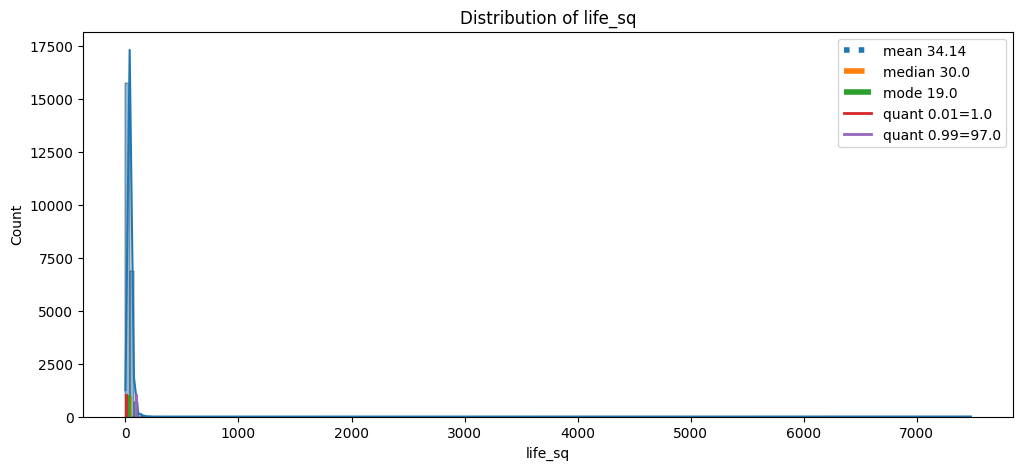

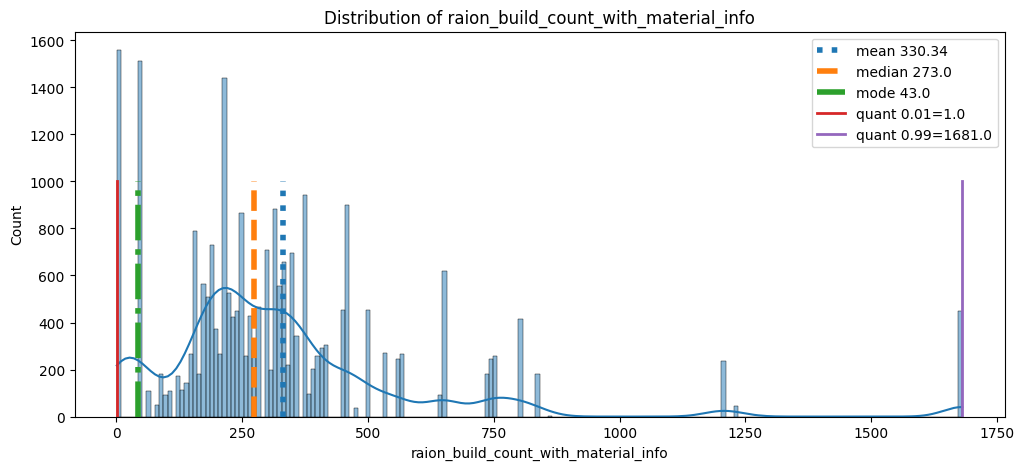

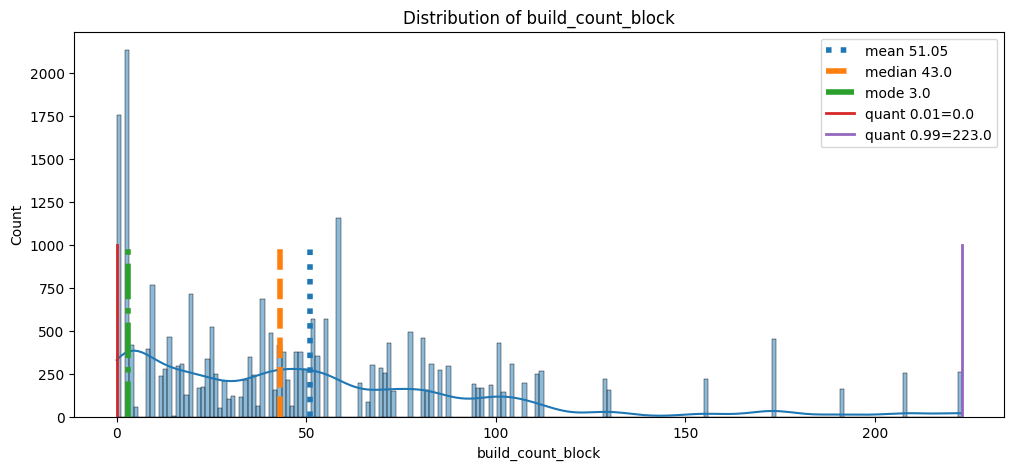

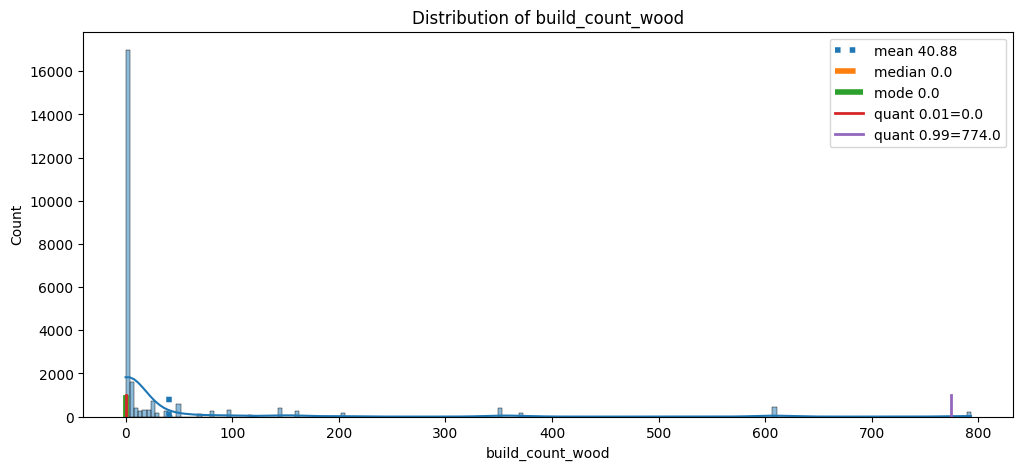

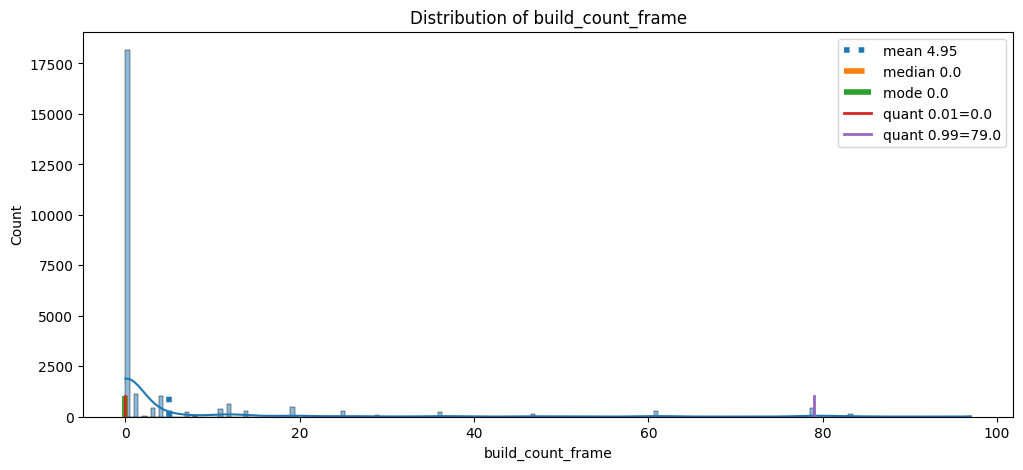

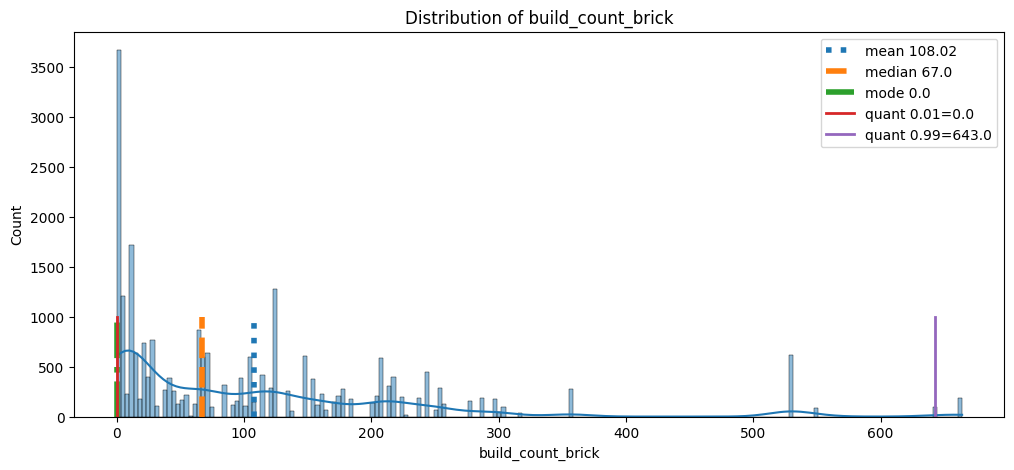

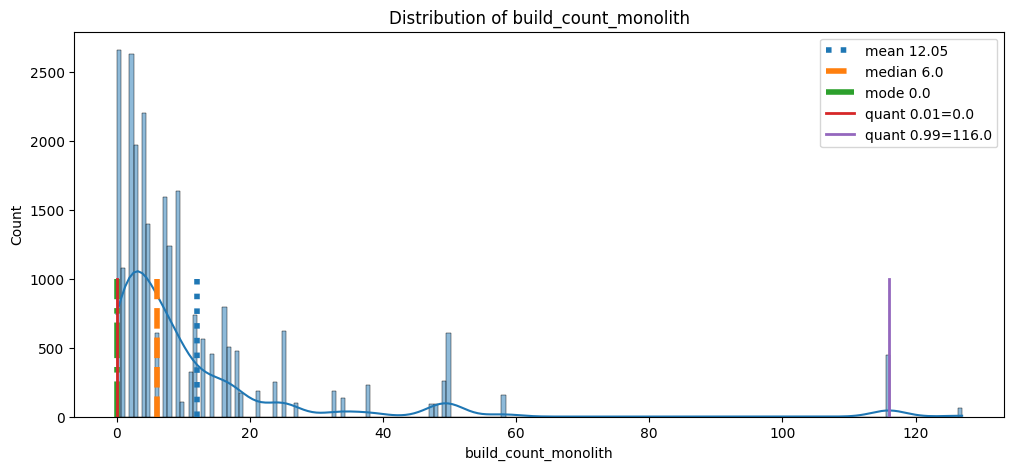

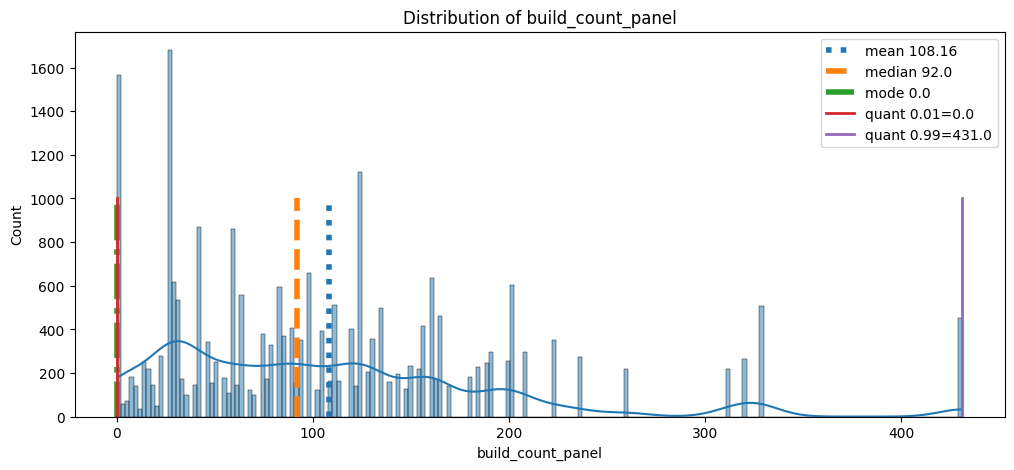

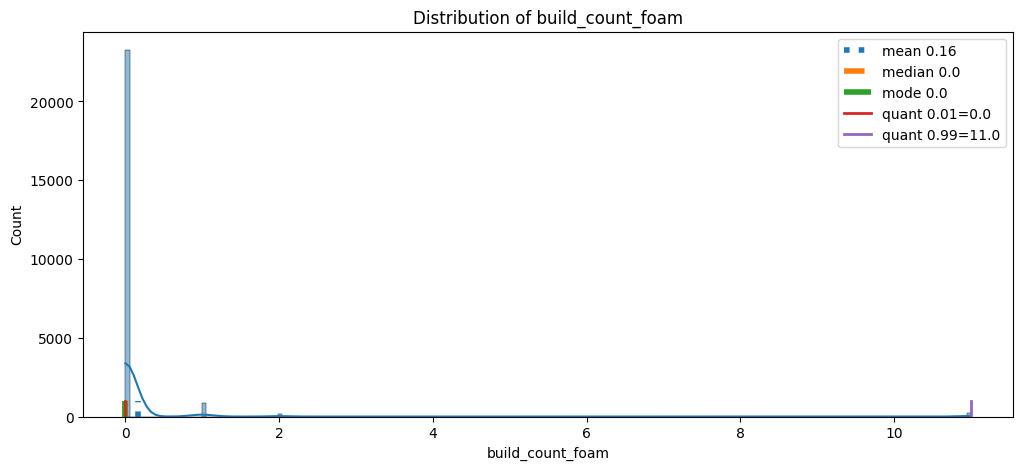

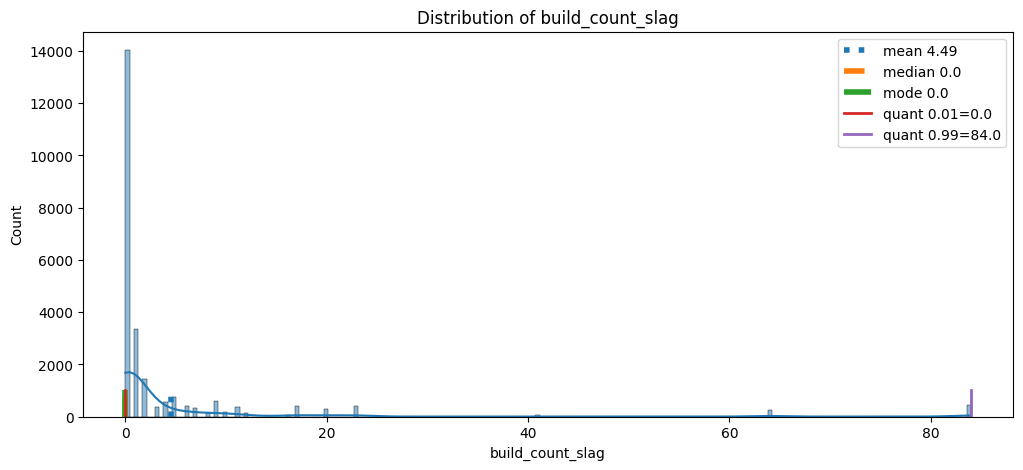

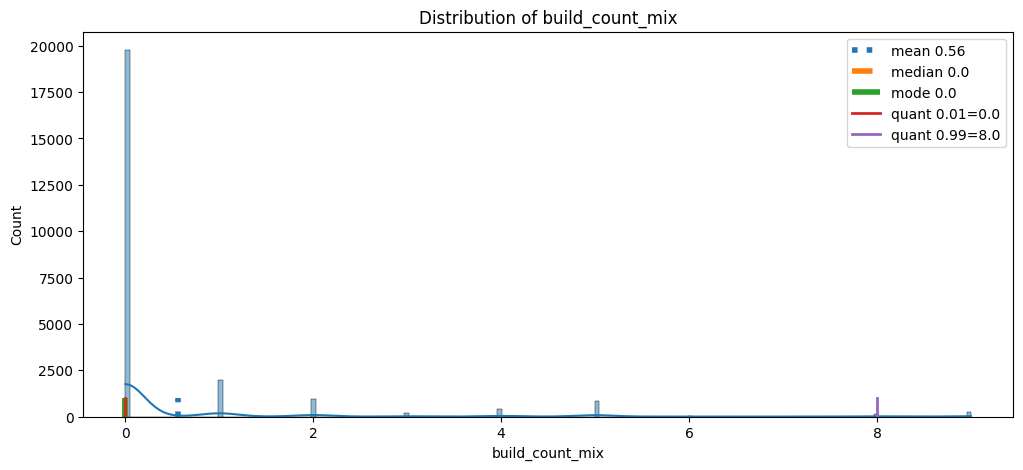

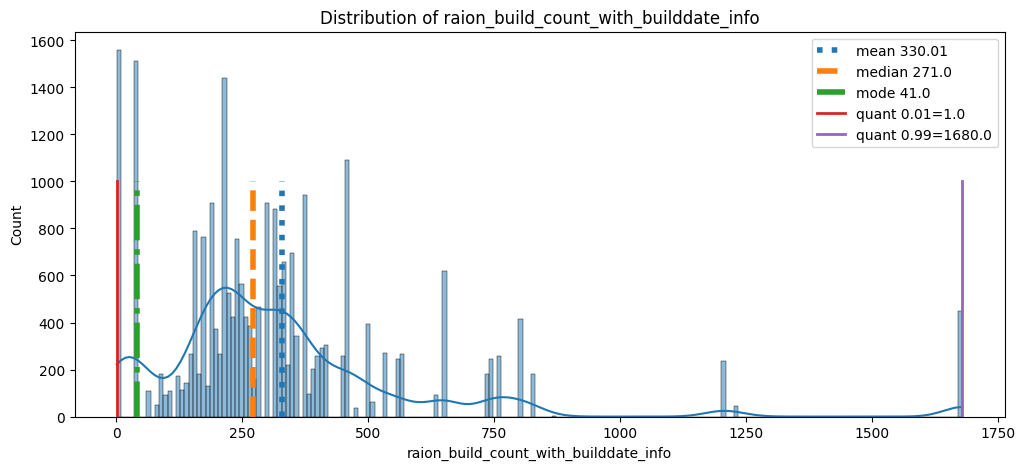

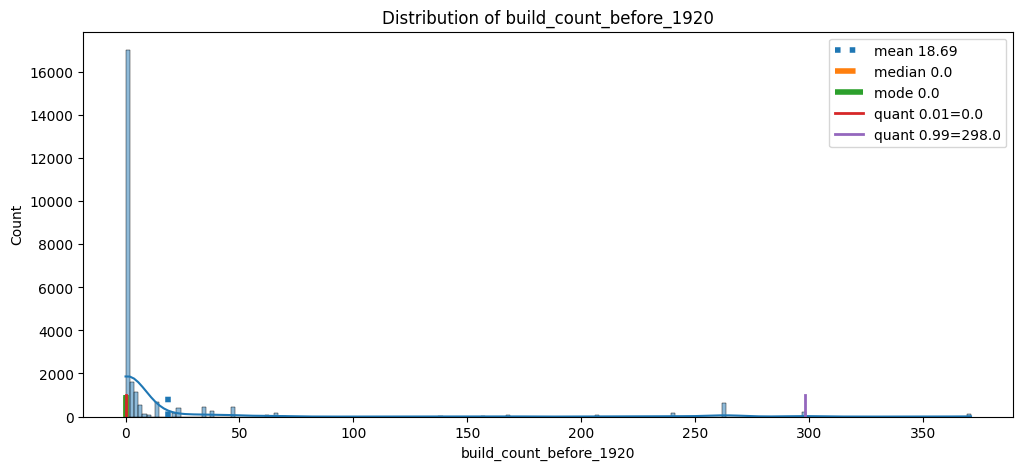

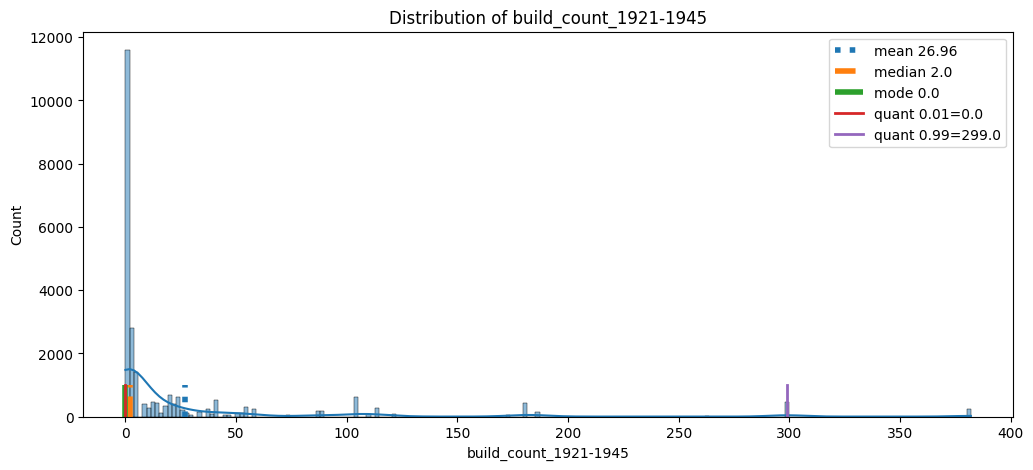

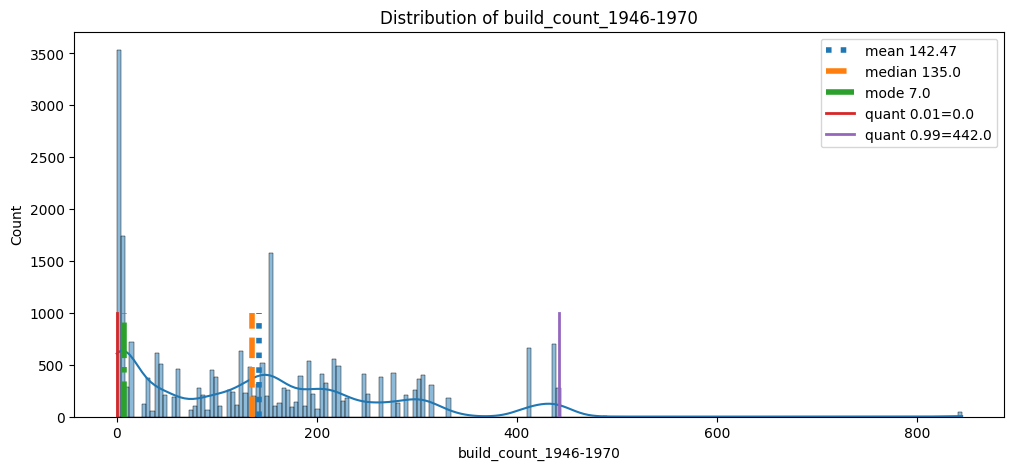

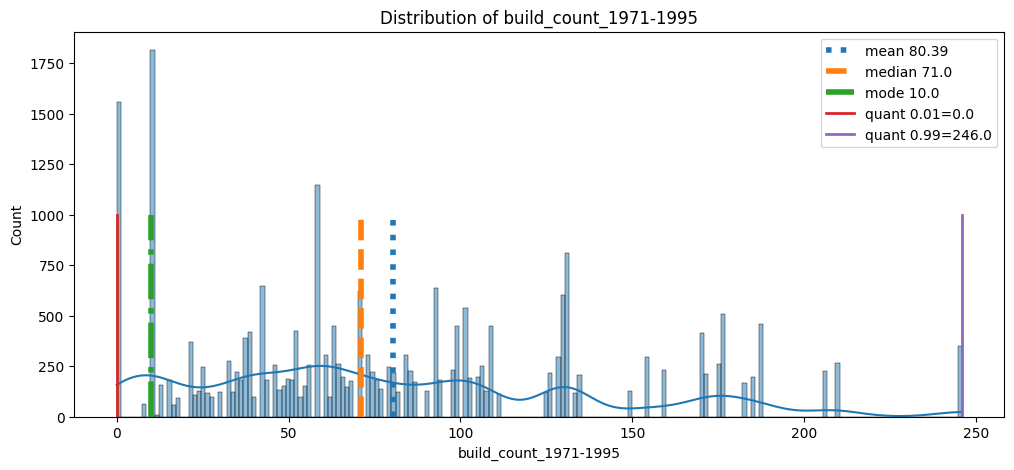

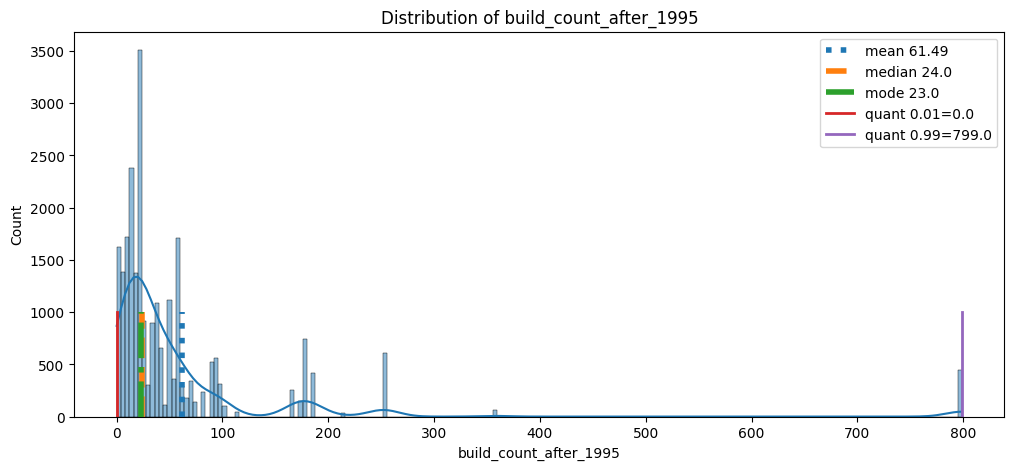

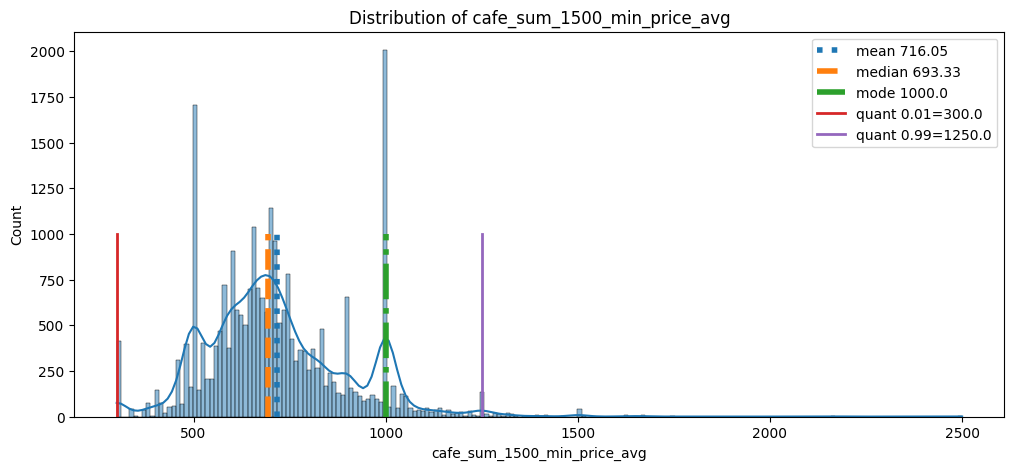

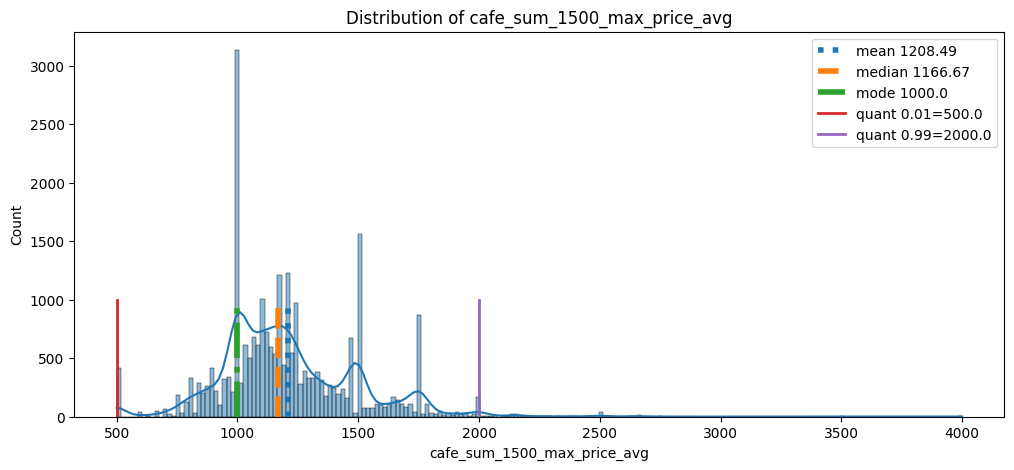

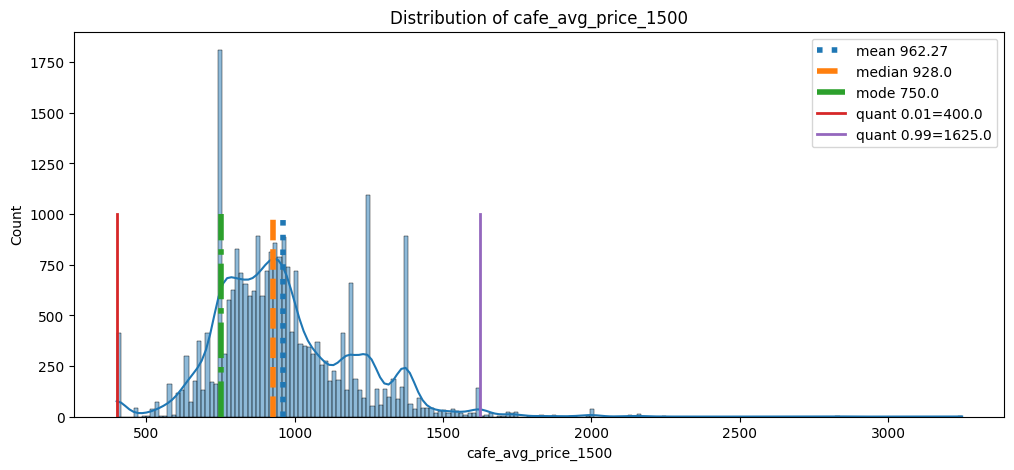

In [ ]:
for col in df[[k for k,v in nul_dict_sort_1.items() if v < 20]]:
    Mean_Median_Mode(df[df[col].notna()][col], b=200, w=12, h=5)

#### 5.3.1 Try to fix "full_sq", "life_sq", "kitch_sq", "num_room"

In [ ]:
df["life_sq"].max()

7478.0

In [ ]:
df.loc[(df["full_sq"] == 79) & (df["life_sq"] == 7478), ["full_sq", "life_sq", "kitch_sq", "num_room"]]

full_sq  life_sq  kitch_sq  num_room
23616       79   7478.0       1.0       3.0

In [ ]:
df.drop(df[df["life_sq"] == 7478].index, inplace=True)

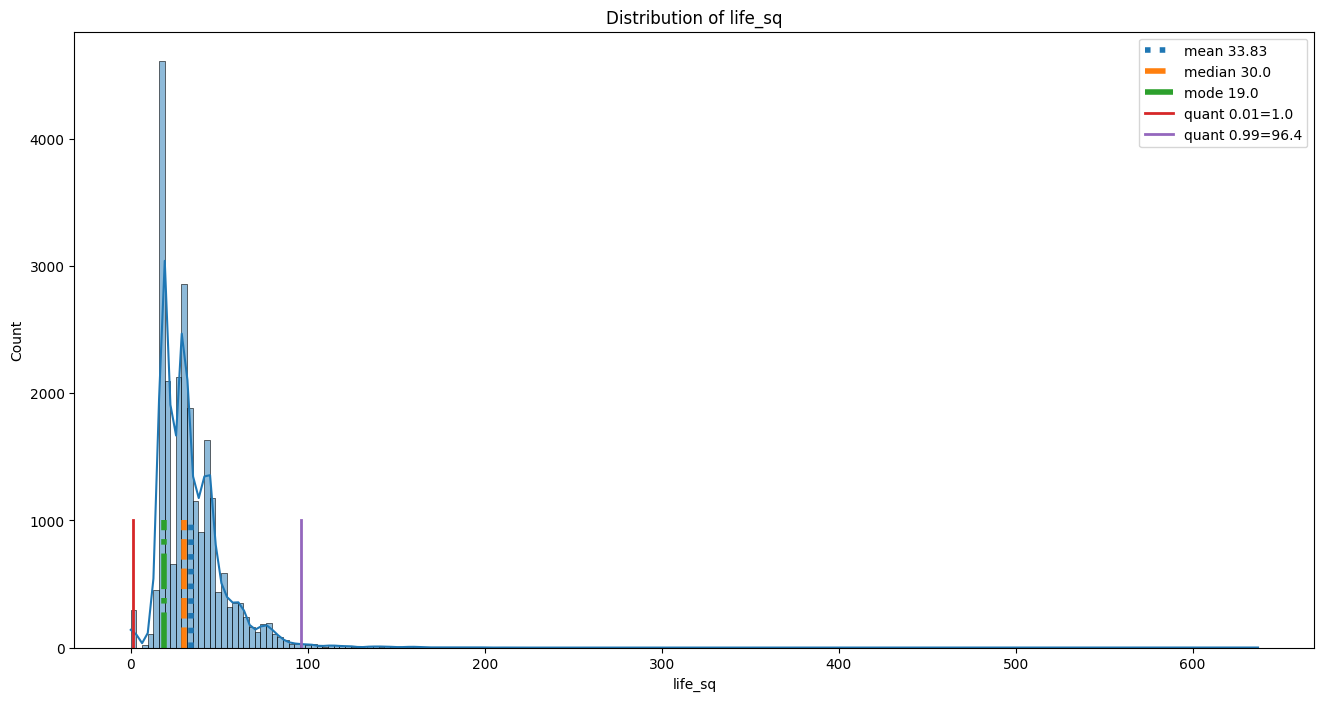

In [ ]:
Mean_Median_Mode(df[df["life_sq"].notna()]["life_sq"], b=200)

In [ ]:
df.loc[(df["life_sq"] > 200)]

timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
128    2011-10-15      325    325.0    7.0        NaN       NaN         NaN   
11709  2015-02-09      407    407.0    4.0        4.0       4.0      2015.0   
13134  2014-09-23      637    637.0   18.0       19.0       4.0      2016.0   
16282  2014-05-20      209    209.0    0.0        3.0       4.0      2007.0   
28863  2014-05-16      275    232.0   11.0       37.0       6.0      2009.0   

       num_room  kitch_sq  state  ... cafe_count_5000_price_2500  \
128         NaN       NaN    NaN  ...                          3   
11709       1.0      10.0    1.0  ...                        103   
13134       2.0      10.0    1.0  ...                        371   
16282       0.0       0.0    1.0  ...                          1   
28863       5.0      26.0    1.0  ...                         27   

      cafe_count_5000_price_4000  cafe_count_5000_price_high  \
128                            1                           0   
11709                         57                          13   
13134                        141                          26   
16282                          0                           0   
28863                          5                           1   

       big_church_count_5000  church_count_5000  mosque_count_5000  \
128                        7                 14                  0   
11709                     22                 43                  1   
13134                    150                249                  2   
16282                      1                  7                  0   
28863                      8                 19                  0   

       leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
128                     9                44                 10    5000000  
11709                  13               121                  7    3134129  
13134                 105               203                 13    4725142  
16282                   0                 4                  1   10500000  
28863                   3                74                 11   15919294  

[5 rows x 291 columns]

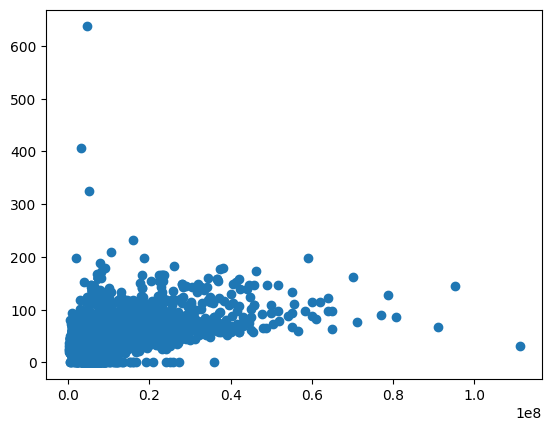

In [ ]:
plt.scatter(df[target], df["life_sq"])

In [ ]:
df.drop(df[df["life_sq"] > 200].index, inplace=True)

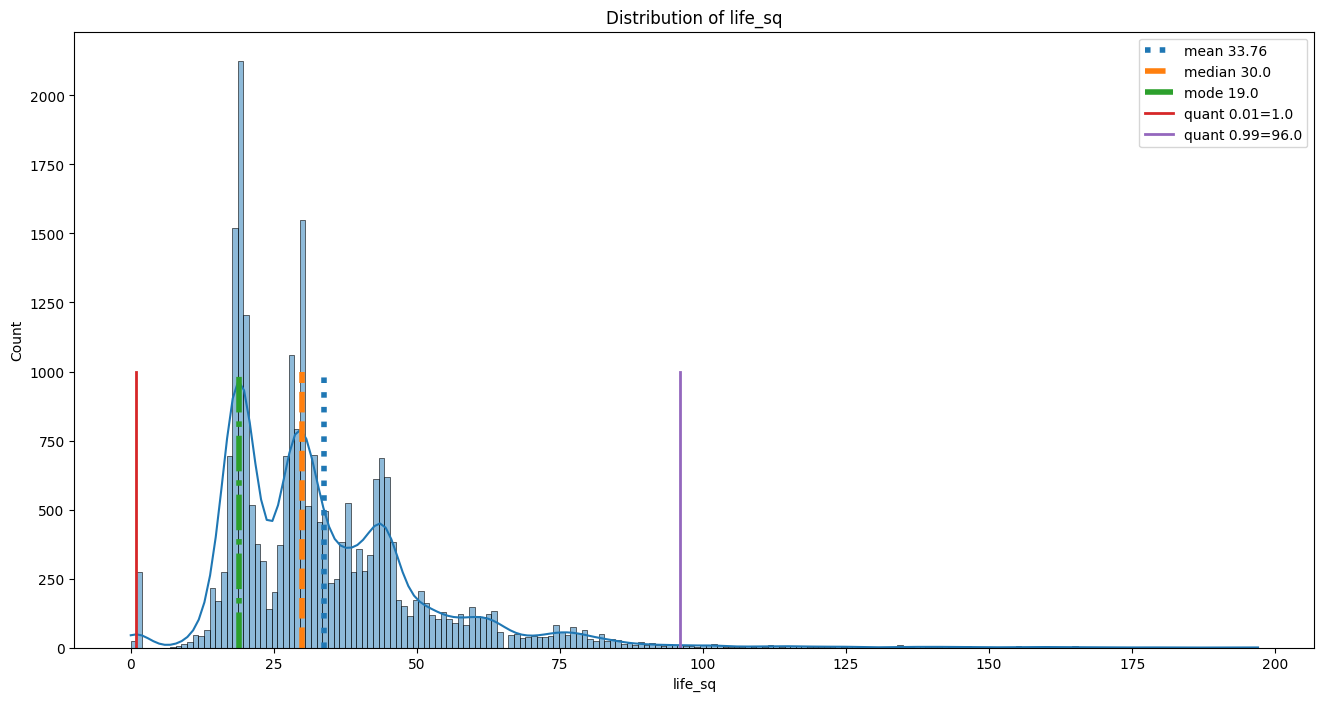

In [ ]:
Mean_Median_Mode(df[df["life_sq"].notna()]["life_sq"], b=200)

In [ ]:
df["life_sq"].isna().sum()

5437

Text(0, 0.5, 'full')

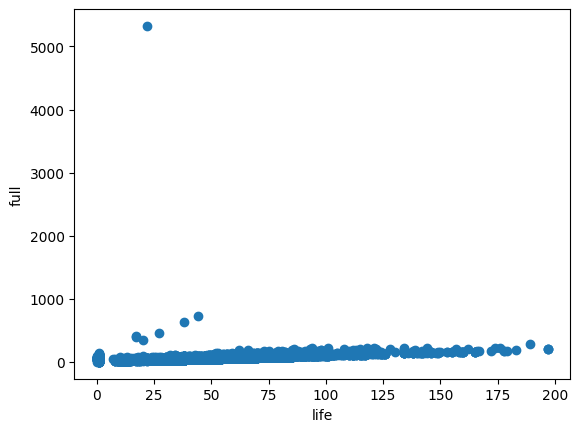

In [ ]:
plt.scatter(df.loc[df['life_sq'].notna(), ['life_sq']], df.loc[df['life_sq'].notna(), ['full_sq']])
plt.xlabel('life')
plt.ylabel('full')

In [ ]:
df.loc[df['full_sq'] > 300, ['full_sq']] = df.loc[df['full_sq'] > 300, ['full_sq']] / 10

In [ ]:
df.loc[df['full_sq'] > 300, ['full_sq']] = df.loc[df['full_sq'] > 300, ['full_sq']] / 10

Text(0, 0.5, 'life')

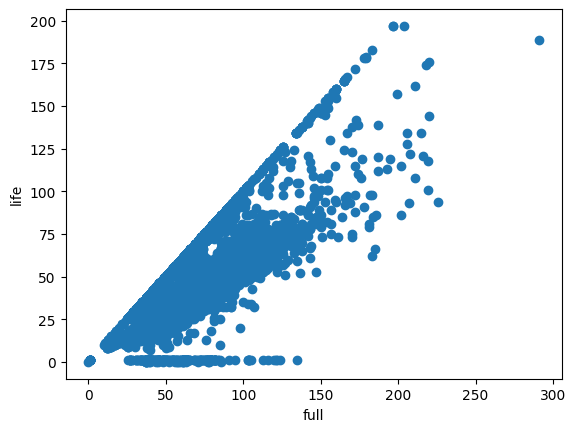

In [ ]:
plt.scatter(df.loc[df['life_sq'].notna(), ['full_sq']], df.loc[df['life_sq'].notna(), ['life_sq']])
plt.xlabel('full')
plt.ylabel('life')

In [ ]:
x = np.asarray(df.loc[(df['life_sq'].notna()) & (df['life_sq'] > 5), ['full_sq']]).reshape(1, -1)[0]
y = np.asarray(df.loc[(df['life_sq'].notna()) & (df['life_sq'] > 5), ['life_sq']]).reshape(1, -1)[0]
n = len(x)

In [ ]:
b = (np.mean(x*y) - np.mean(x) * np.mean(y)) / (np.mean(x**2) - (np.mean(x))**2)
round(b, 3)

0.734

In [ ]:
a = np.mean(y) - b * np.mean(x)
round(a, 3)

-4.287

In [ ]:
ks_hat = a + b * x

Text(0, 0.5, 'life')

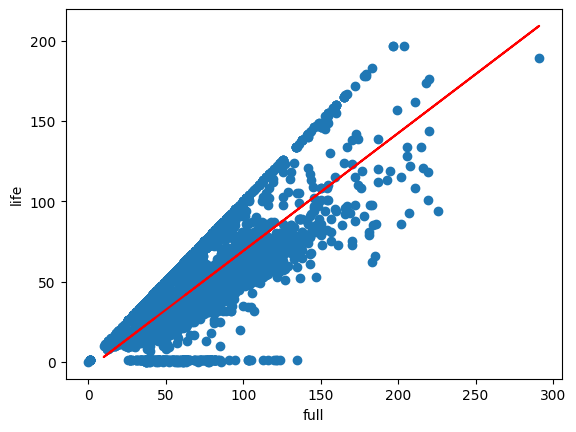

In [ ]:
plt.scatter(df.loc[df['life_sq'].notna(), ['full_sq']], df.loc[df['life_sq'].notna(), ['life_sq']])
plt.plot(x, ks_hat, 'r')
plt.xlabel('full')
plt.ylabel('life')

In [ ]:
x_new = np.asarray(df.loc[(df['life_sq'].notna()) & (df['life_sq'] < 5), ['full_sq']]).reshape(1, -1)[0]

In [ ]:
y_new = a + b * x_new

Text(0, 0.5, 'life')

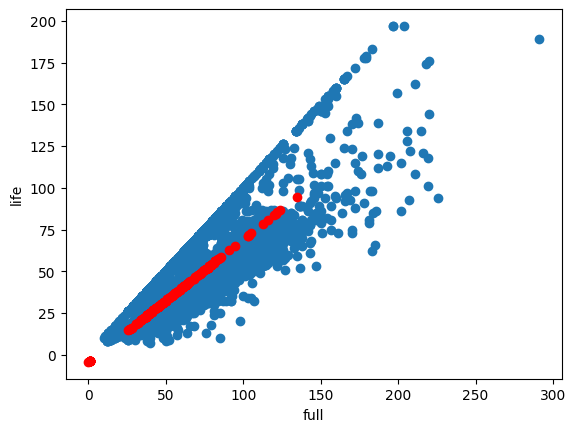

In [ ]:
plt.scatter(x, y)
plt.scatter(x_new, y_new, c='r')
# plt.plot(x, ks_hat, 'r')
plt.xlabel('full')
plt.ylabel('life')

In [ ]:
df.loc[(df['life_sq'] < 5) & (df['life_sq'].notna()), ['life_sq']] = a + b * x_new

Text(0, 0.5, 'life')

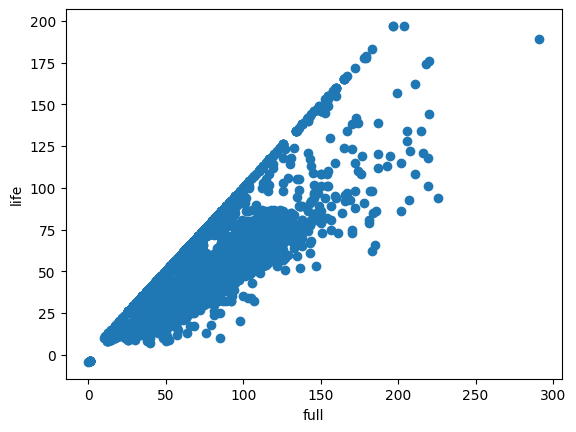

In [ ]:
plt.scatter(df.loc[df['life_sq'].notna(), ['full_sq']], df.loc[df['life_sq'].notna(), ['life_sq']])
plt.xlabel('full')
plt.ylabel('life')

(-5.0, 0.0)

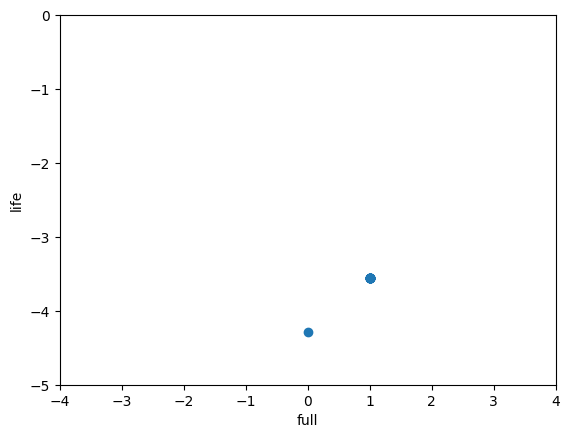

In [ ]:
plt.scatter(df.loc[df['life_sq'].notna(), ['full_sq']], df.loc[df['life_sq'].notna(), ['life_sq']])
plt.xlabel('full')
plt.ylabel('life')
plt.xlim(-4, 4)
plt.ylim(-5, 0)

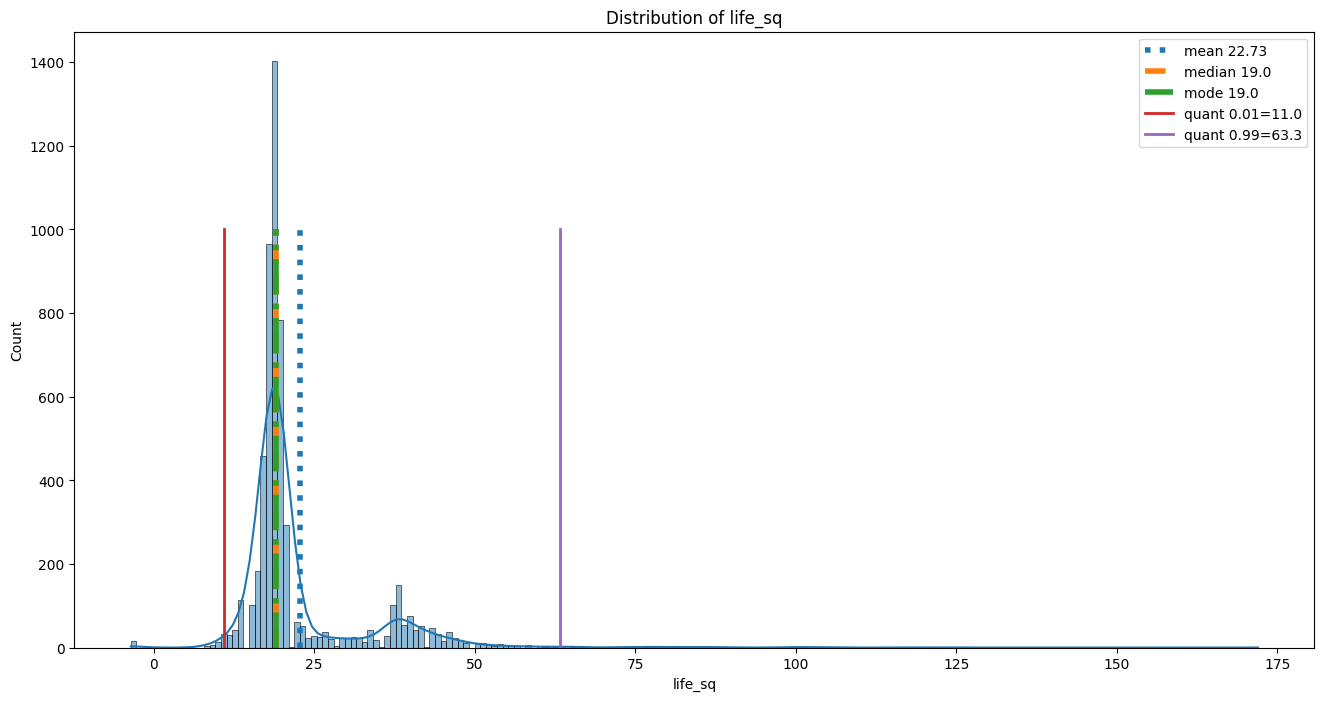

In [ ]:
Mean_Median_Mode(df[(df['num_room'] == 1) &
    (df['life_sq'].notna())]['life_sq'], b=200)

In [ ]:
df.loc[(df['life_sq'] < 10) & (df['full_sq'] < 10) & (df['num_room'] == 1), ['life_sq']] = 19

In [ ]:
df.loc[df['num_room'] > 9, ['num_room']] = 2

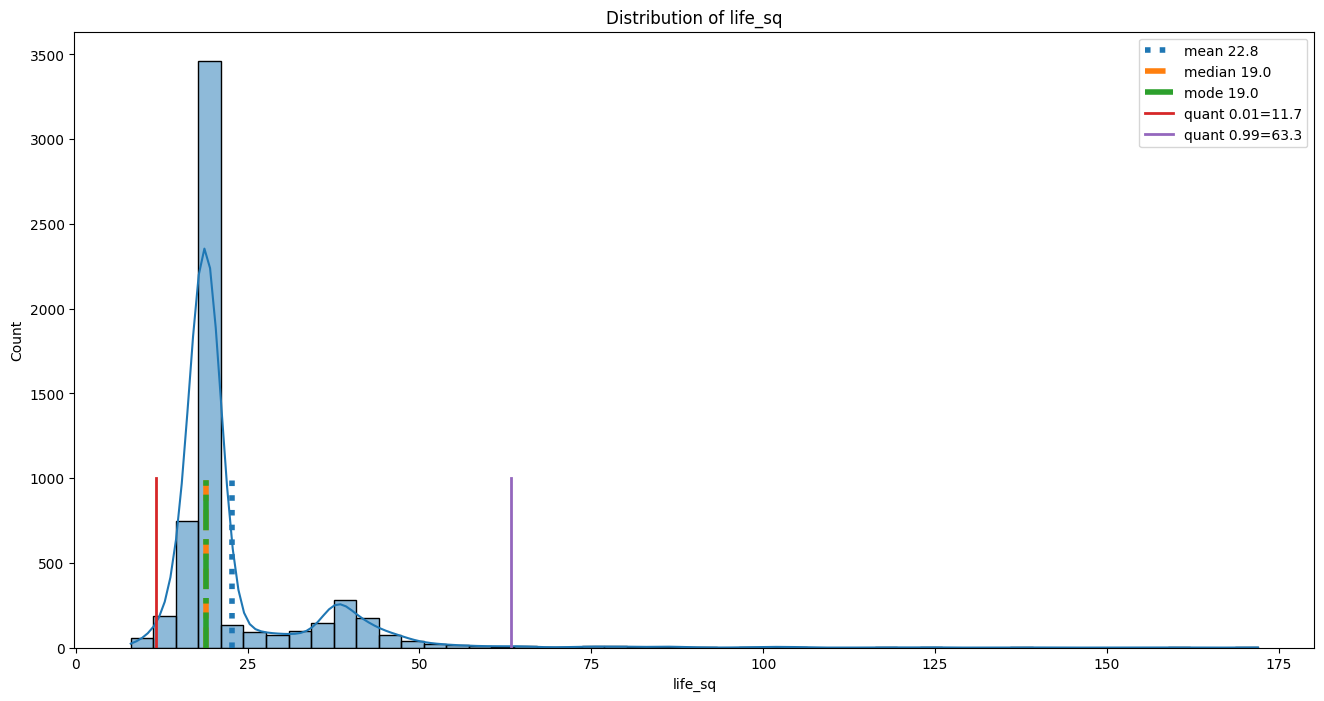

In [ ]:
Mean_Median_Mode(df[(df['num_room'] == 1) & (df['life_sq'].notna())]['life_sq'])

#### 5.3.2 "Number of Room"

In [ ]:
df.loc[((df['num_room'] < 1) | (df['num_room'] > 6)) &
       (df['num_room'] == df['kitch_sq'])]

timestamp  full_sq     life_sq  floor  max_floor  material  \
10493  2014-04-28      0.0   -4.287303    0.0        0.0       1.0   
10521  2014-05-05    112.0  112.000000    3.0        3.0       1.0   
11661  2015-01-22    135.0  134.000000    3.0        3.0       6.0   
26218  2014-10-01     84.0   84.000000    3.0       15.0       2.0   

       build_year  num_room  kitch_sq  state  ... cafe_count_5000_price_2500  \
10493         0.0       0.0       0.0    1.0  ...                          0   
10521         0.0       0.0       0.0    1.0  ...                         10   
11661      2013.0       0.0       0.0    1.0  ...                          3   
26218         0.0       0.0       0.0    1.0  ...                          1   

      cafe_count_5000_price_4000  cafe_count_5000_price_high  \
10493                          0                           0   
10521                          3                           0   
11661                          1                           0   
26218                          0                           0   

       big_church_count_5000  church_count_5000  mosque_count_5000  \
10493                      1                  7                  1   
10521                     10                  9                  0   
11661                      0                  7                  0   
26218                      1                  4                  1   

       leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
10493                   0                12                  1    4425000  
10521                   0                38                  4    7600002  
11661                   0                 3                  2    9308100  
26218                   0                14                  1    7580000  

[4 rows x 291 columns]

In [ ]:
df.drop(df.loc[((df['num_room'] < 1) | (df['num_room'] > 6)) &
       (df['num_room'] == df['kitch_sq'])].index, inplace=True)

In [ ]:
df['num_room'].value_counts()

2.0    7548
1.0    6992
3.0    4355
4.0     380
5.0      35
6.0       9
8.0       3
0.0       2
7.0       1
9.0       1
Name: num_room, dtype: int64

In [ ]:
df.loc[df['num_room'] == 0, ['num_room']] = 1

In [ ]:
num_room_list = df['num_room'].value_counts().index.tolist()
num_room_list.sort()

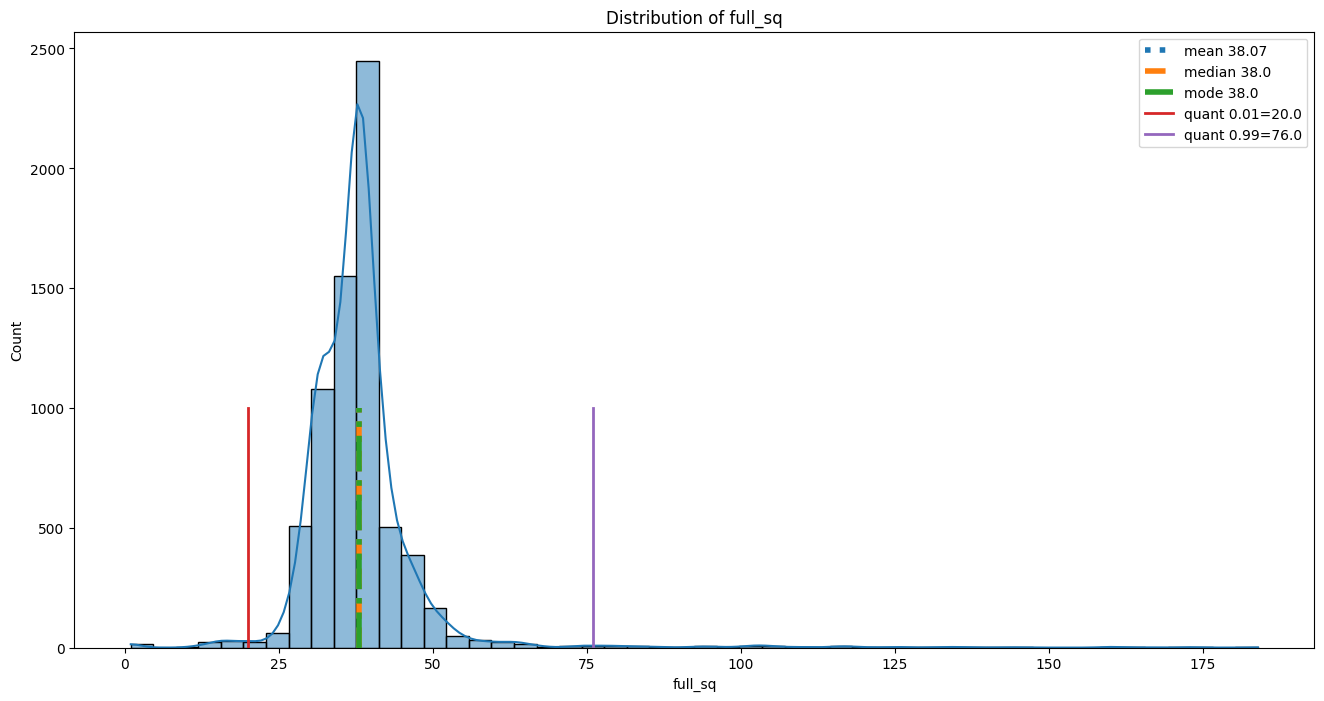

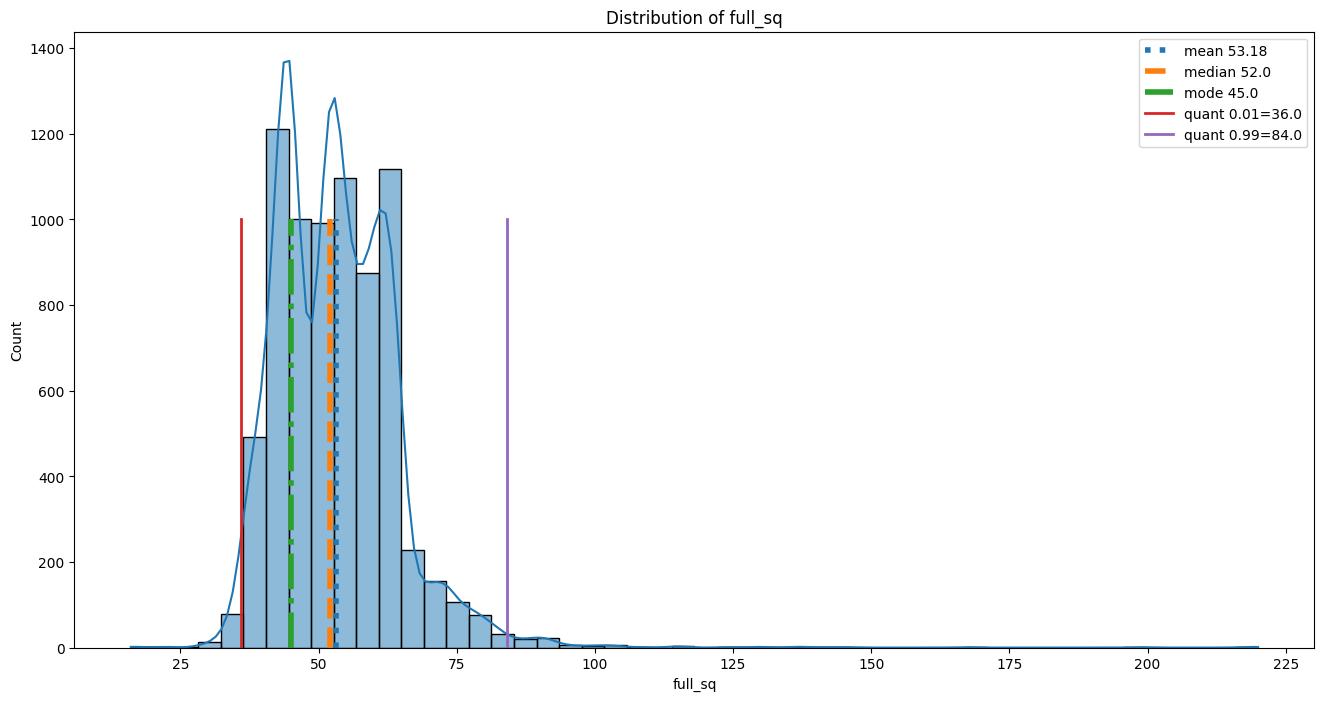

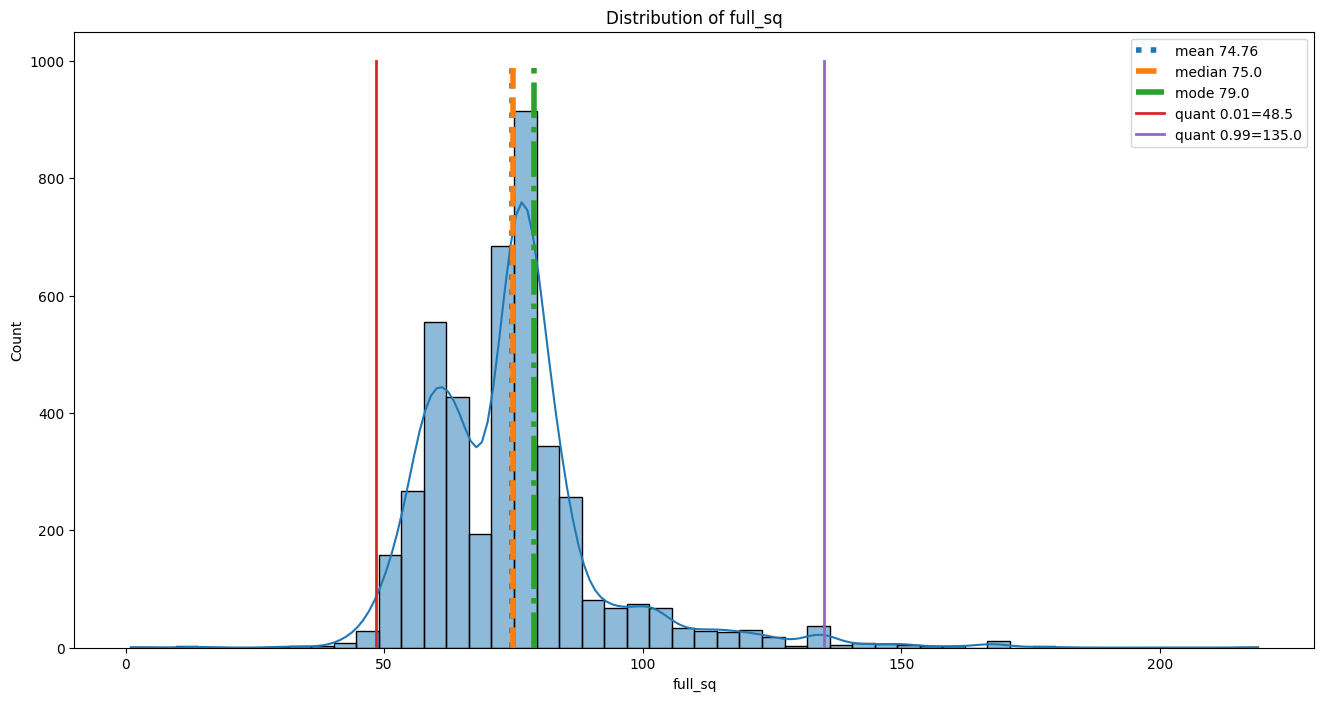

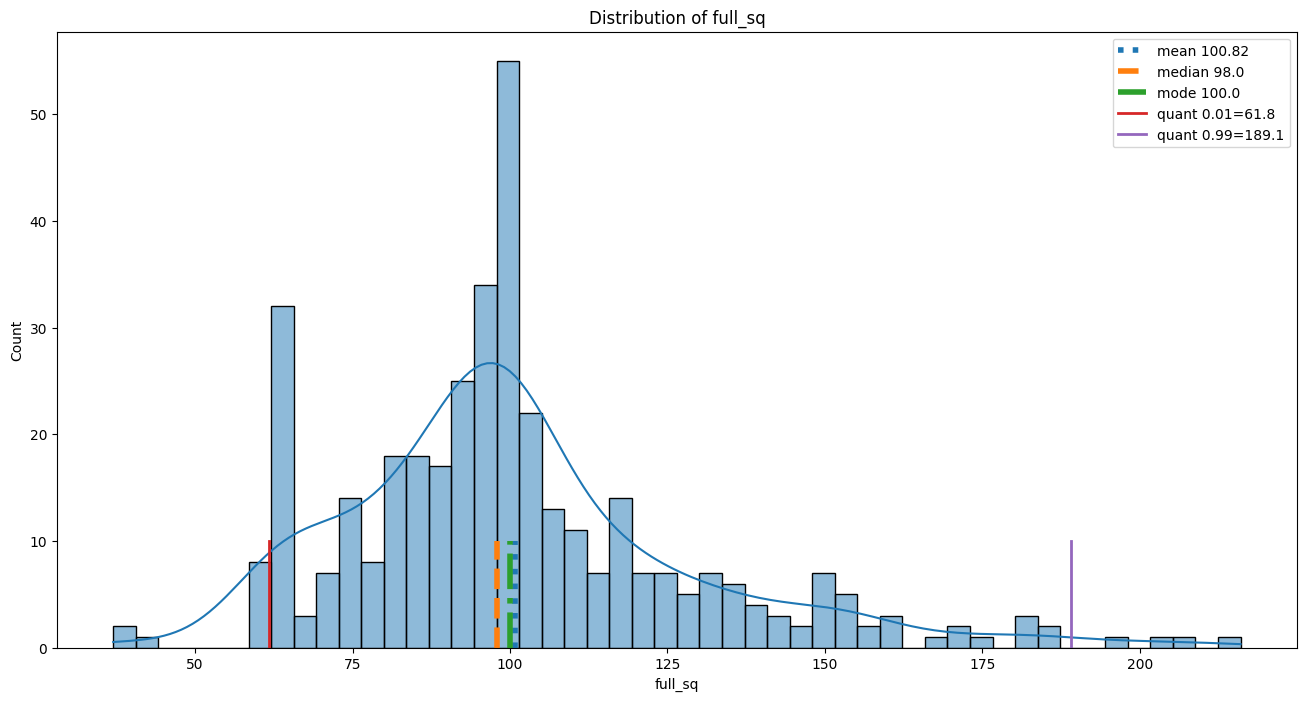

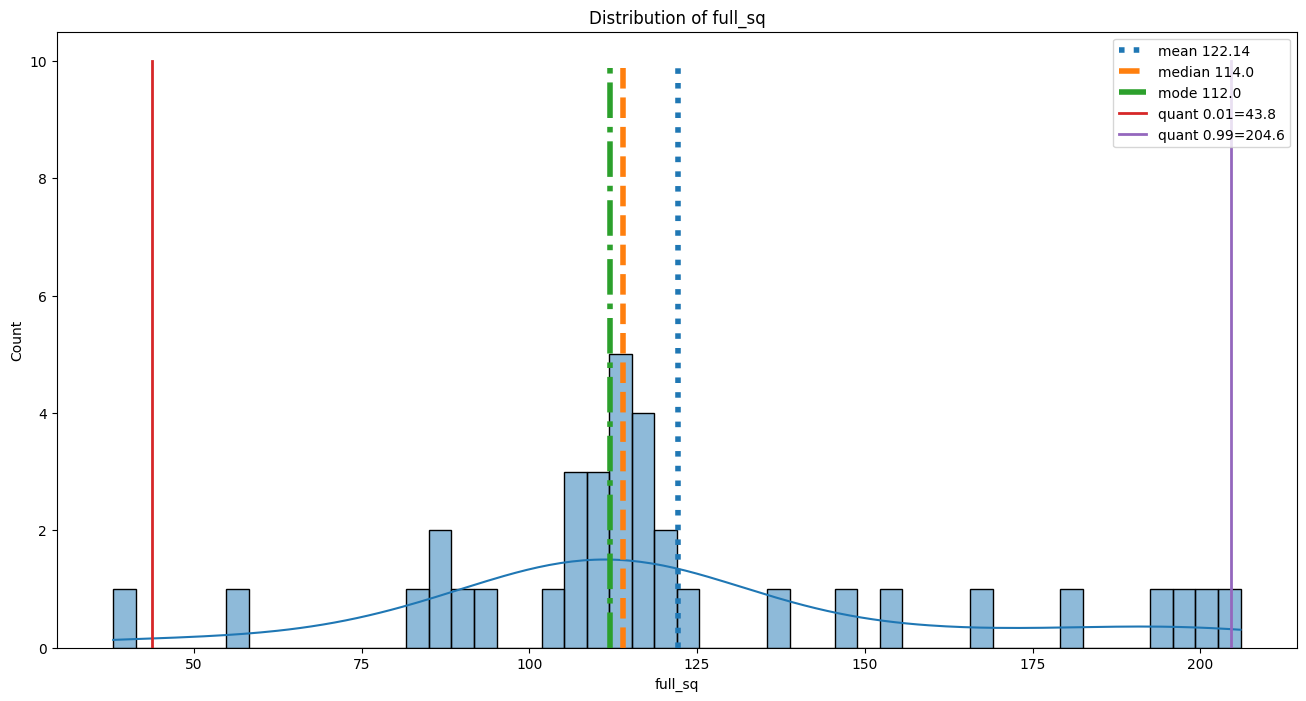

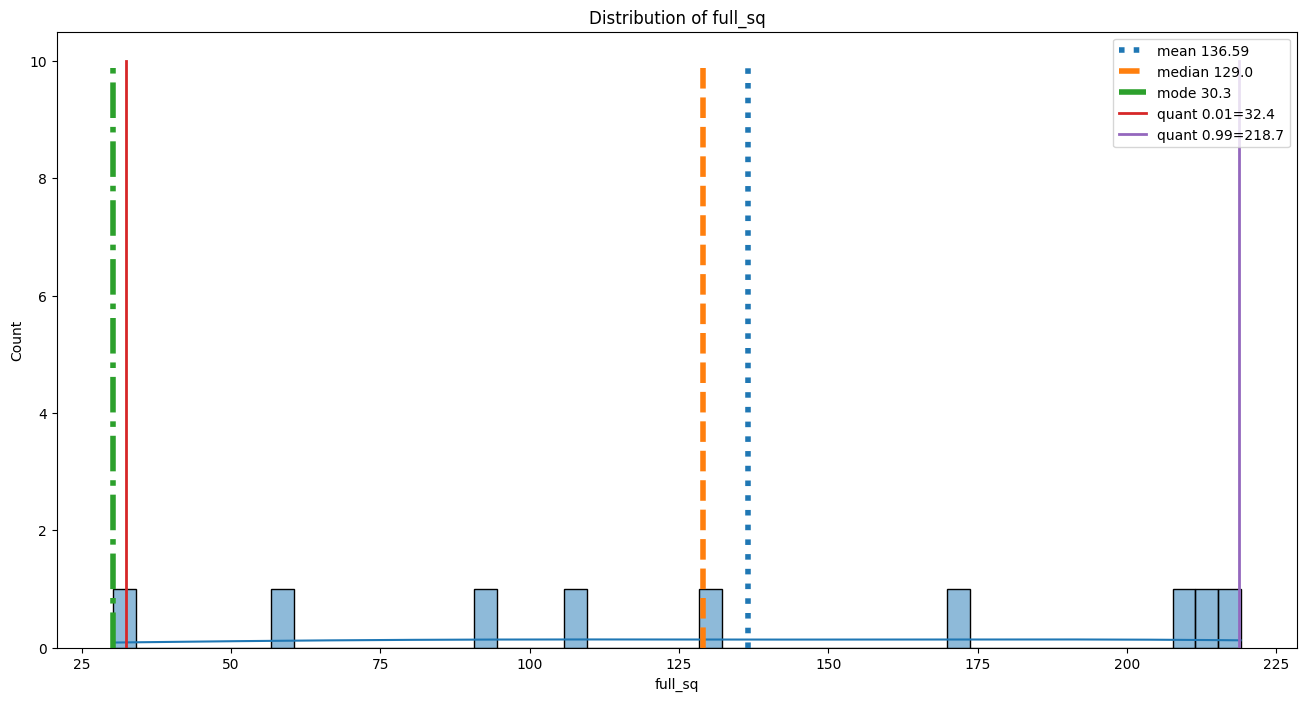

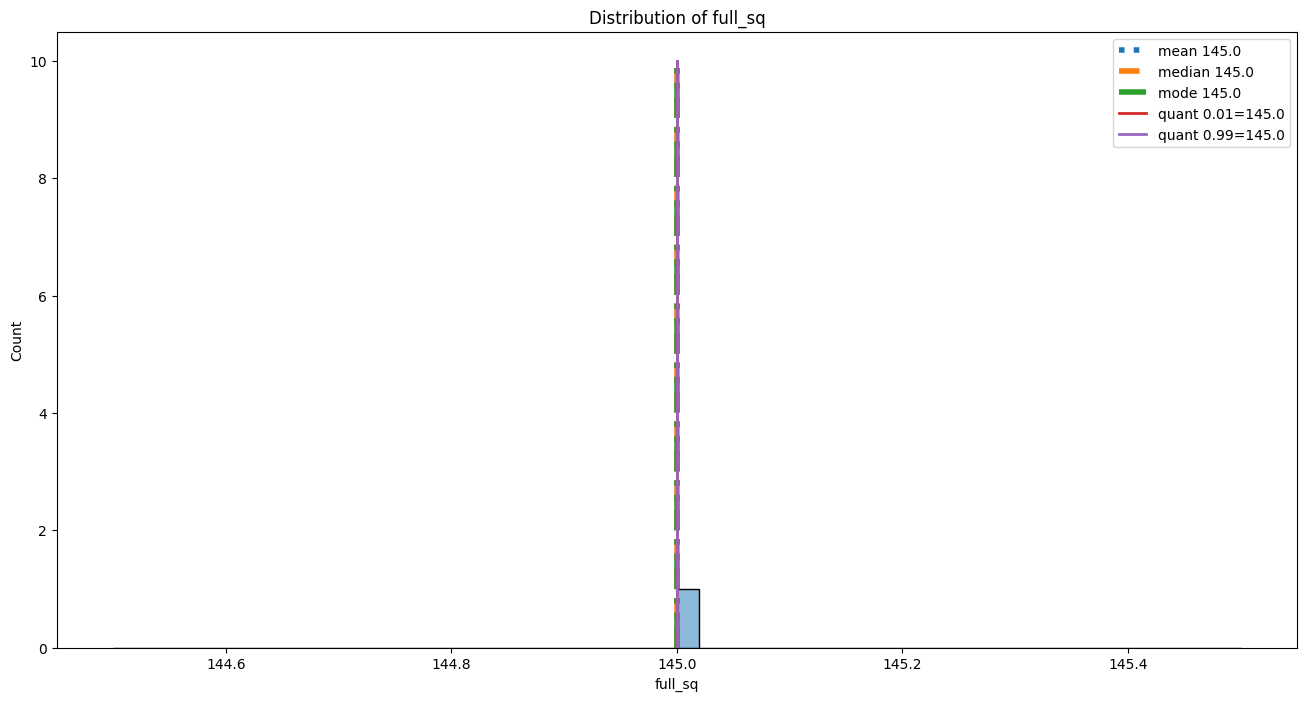

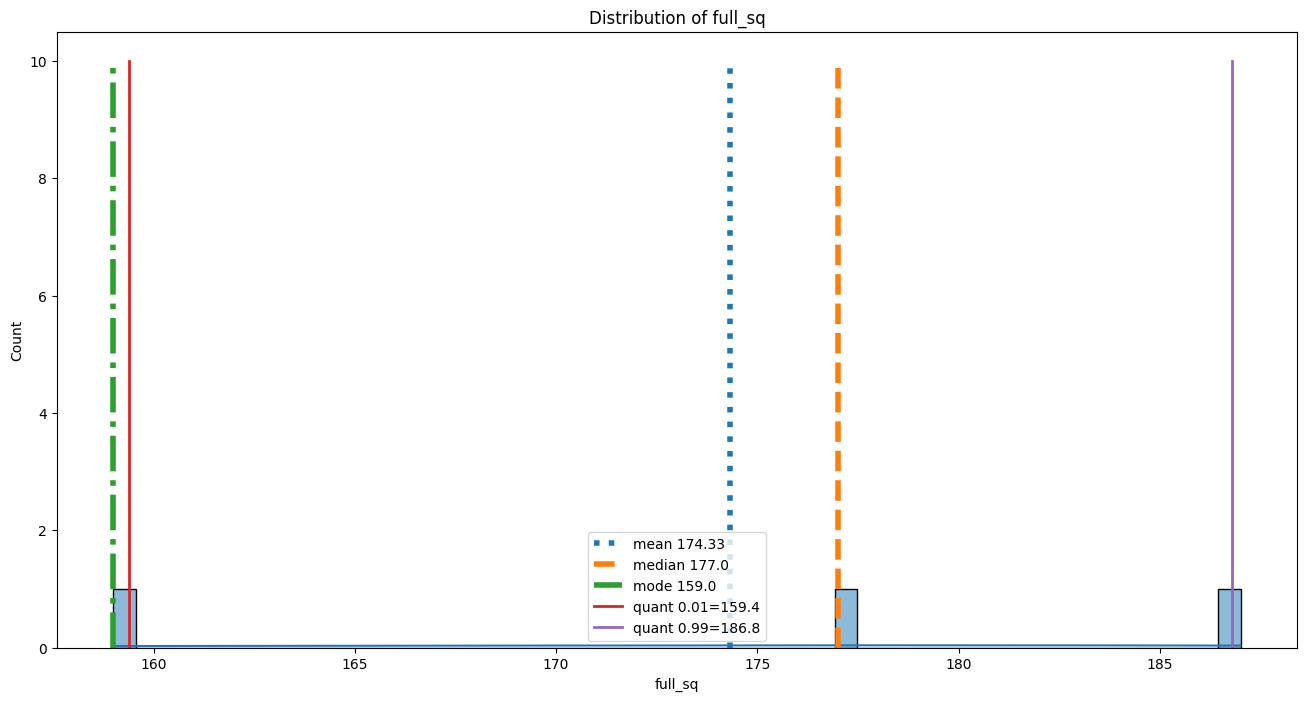

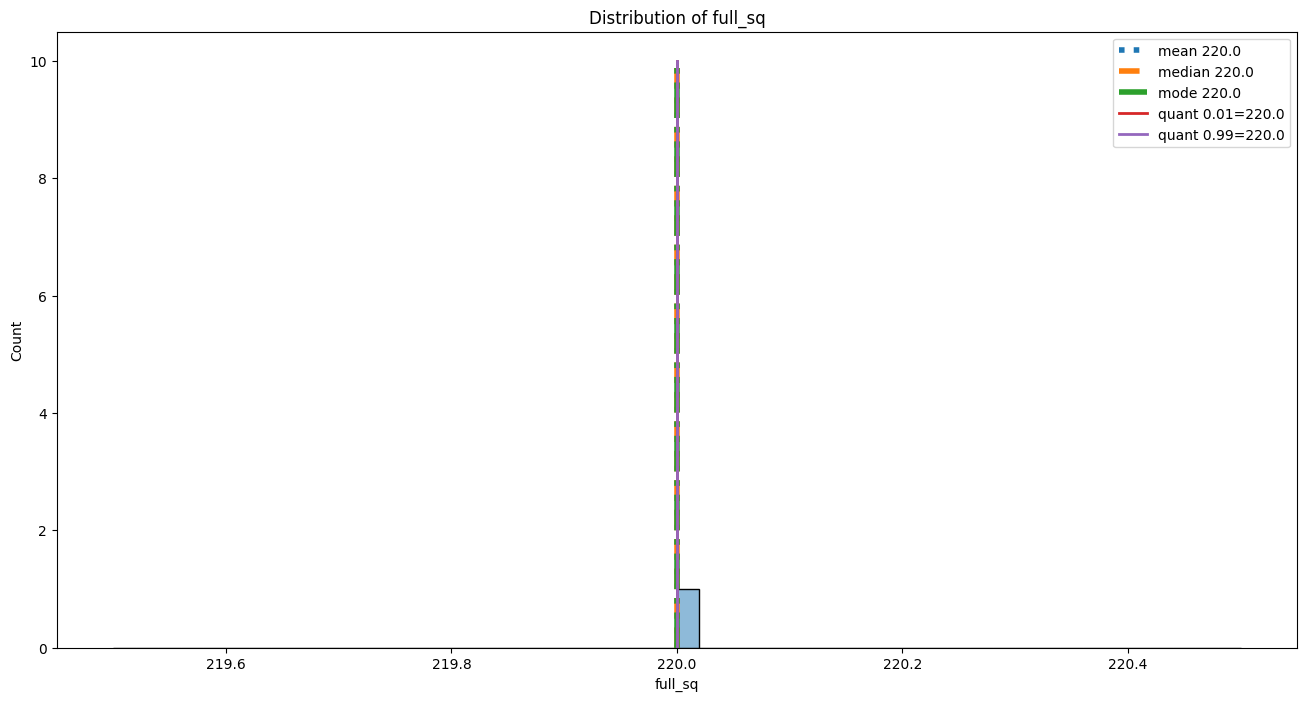

In [ ]:
for room in num_room_list:
    if room <= 3:
        Mean_Median_Mode(df[df['num_room'] == room]['full_sq'])
    else:
        Mean_Median_Mode(df[df['num_room'] == room]['full_sq'], divisor=10)

<Axes: xlabel='full_sq', ylabel='Count'>

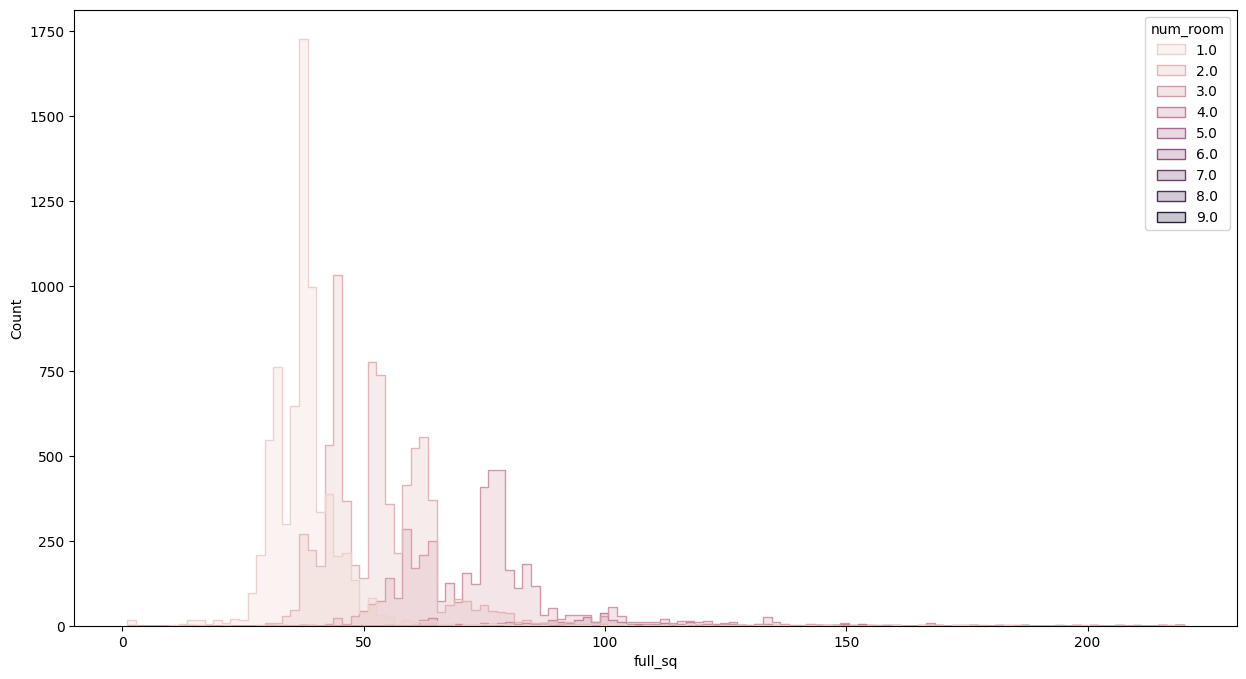

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(df, x='full_sq', hue='num_room', element="step")

In [ ]:
for room in num_room_list:
    q_min = round(np.quantile(df.loc[df['num_room'] == room, ['full_sq']], q=0.01), 2)
    q_max = round(np.quantile(df.loc[df['num_room'] == room, ['full_sq']], q=0.99), 2)
    part_room = df.loc[(df['num_room'] == room) & ((df['full_sq'] >= q_min) & (df['full_sq'] <= q_max)), ['num_room']].count()[0] / df.shape[0]
    nul_count = df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= q_min) & (df['full_sq'] <= q_max)), ['num_room']].shape[0] / df.shape[0]
    if part_room < 1:
        print(f"Part {room} room {round(part_room, 5) * 100} % from [{q_min}] to [{q_max}] and have a NaN values {round(nul_count * 100, 5)} %")
    else:
        print(f"Part {room} room {round(part_room, 2) * 100} % from [{q_min}] to [{q_max}] and have a NaN values {round(nul_count * 100, 2)} %")

Part 1.0 room 23.749000000000002 % from [20.0] to [76.0] and have a NaN values 28.97352 %
Part 2.0 room 25.663999999999998 % from [36.0] to [84.0] and have a NaN values 26.19353 %
Part 3.0 room 14.776 % from [48.54] to [135.0] and have a NaN values 15.39207 %
Part 4.0 room 1.288 % from [61.79] to [189.1] and have a NaN values 8.27419 %
Part 5.0 room 0.11399999999999999 % from [43.78] to [204.64] and have a NaN values 19.07564 %
Part 6.0 room 0.024 % from [32.44] to [218.68] and have a NaN values 30.0779 %
Part 7.0 room 0.003 % from [145.0] to [145.0] and have a NaN values 0.0 %
Part 8.0 room 0.003 % from [159.36] to [186.8] and have a NaN values 0.14194 %
Part 9.0 room 0.003 % from [220.0] to [220.0] and have a NaN values 0.0 %


In [ ]:
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 20) & (df['full_sq'] <= 76)), ['num_room']] = 1
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 36) & (df['full_sq'] <= 84)), ['num_room']] = 2
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 48) & (df['full_sq'] <= 135)), ['num_room']] = 3
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 61) & (df['full_sq'] <= 189)), ['num_room']] = 4
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 75) & (df['full_sq'] <= 204)), ['num_room']] = 5
df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= 32) & (df['full_sq'] <= 218)), ['num_room']] = 6
df.loc[(df['num_room'].isna()) & (df['full_sq'] < 100), ['num_room']] = 1
df.loc[(df['num_room'].isna()) & (df['full_sq'] > 100), ['num_room']] = 9

In [ ]:
for room in num_room_list:
    q_min = round(np.quantile(df.loc[df['num_room'] == room, ['full_sq']], q=0.01), 2)
    q_max = round(np.quantile(df.loc[df['num_room'] == room, ['full_sq']], q=0.99), 2)
    part_room = df.loc[(df['num_room'] == room) & ((df['full_sq'] >= q_min) & (df['full_sq'] <= q_max)), ['num_room']].count()[0] / df.shape[0]
    nul_count = df.loc[(df['num_room'].isna()) & ((df['full_sq'] >= q_min) & (df['full_sq'] <= q_max)), ['num_room']].shape[0] / df.shape[0]
    if part_room < 1:
        print(f"Part {room} room {round(part_room, 5) * 100} % from [{q_min}] to [{q_max}] and have a NaN values {round(nul_count * 100, 5)} %")
    else:
        print(f"Part {room} room {round(part_room, 2) * 100} % from [{q_min}] to [{q_max}] and have a NaN values {round(nul_count * 100, 2)} %")

Part 1.0 room 52.65 % from [21.0] to [76.0] and have a NaN values 0.0 %
Part 2.0 room 27.750999999999998 % from [36.0] to [84.0] and have a NaN values 0.0 %
Part 3.0 room 16.150000000000002 % from [49.0] to [135.0] and have a NaN values 0.0 %
Part 4.0 room 1.7069999999999999 % from [62.0] to [187.0] and have a NaN values 0.0 %
Part 5.0 room 0.121 % from [44.12] to [205.28] and have a NaN values 0.0 %
Part 6.0 room 0.038 % from [33.5] to [218.52] and have a NaN values 0.0 %
Part 7.0 room 0.003 % from [145.0] to [145.0] and have a NaN values 0.0 %
Part 8.0 room 0.003 % from [159.36] to [186.8] and have a NaN values 0.0 %
Part 9.0 room 0.003 % from [220.12] to [289.7] and have a NaN values 0.0 %


<Axes: xlabel='full_sq', ylabel='Count'>

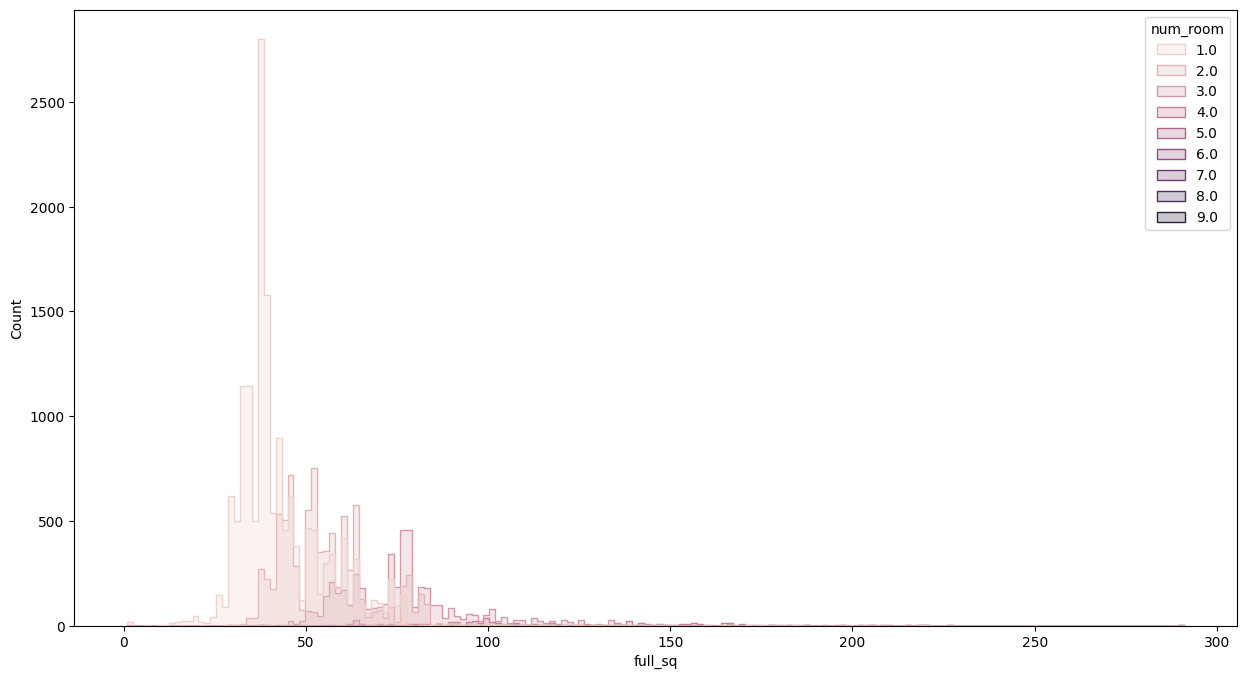

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(df, x='full_sq', hue='num_room', element="step")

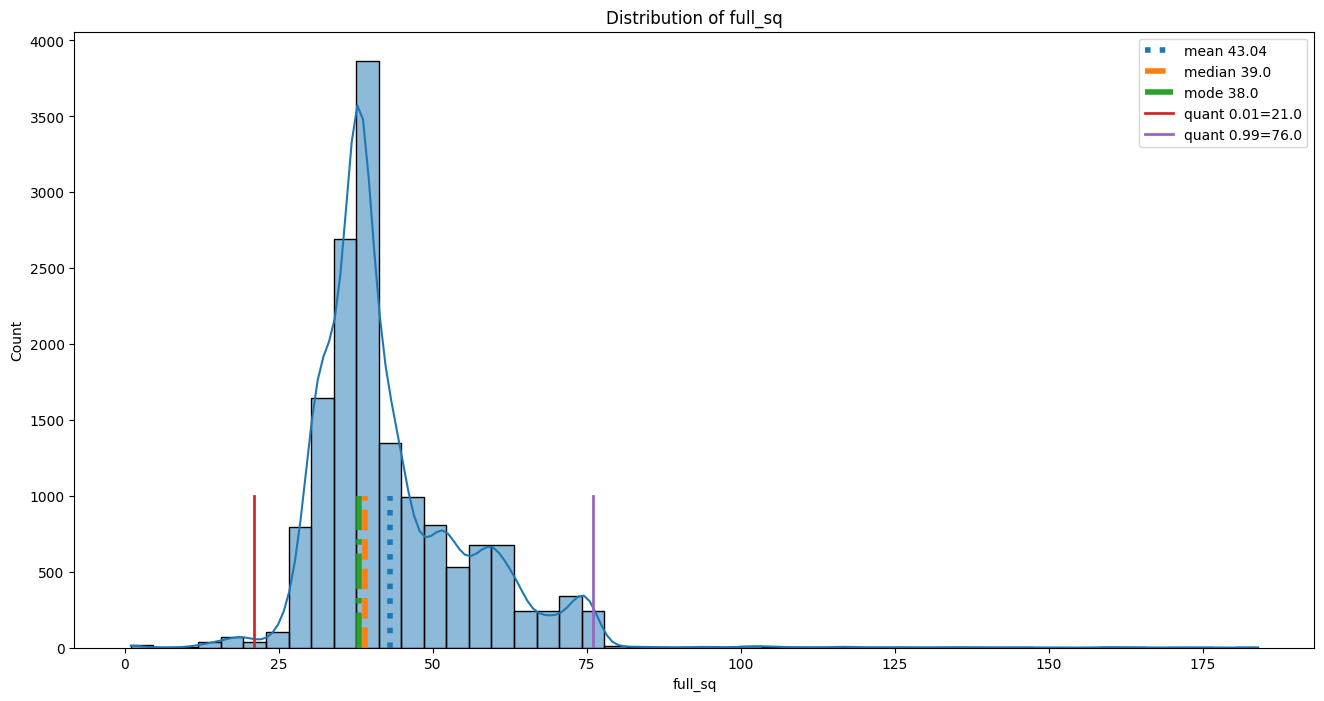

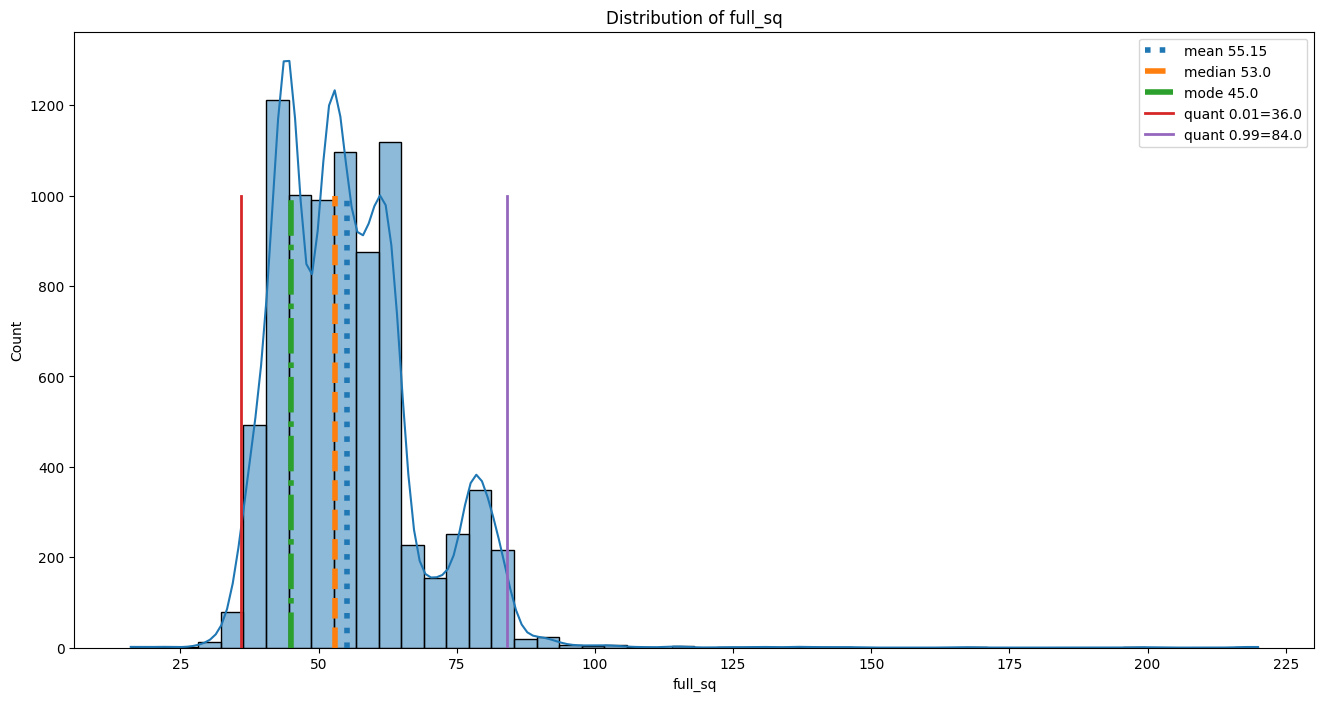

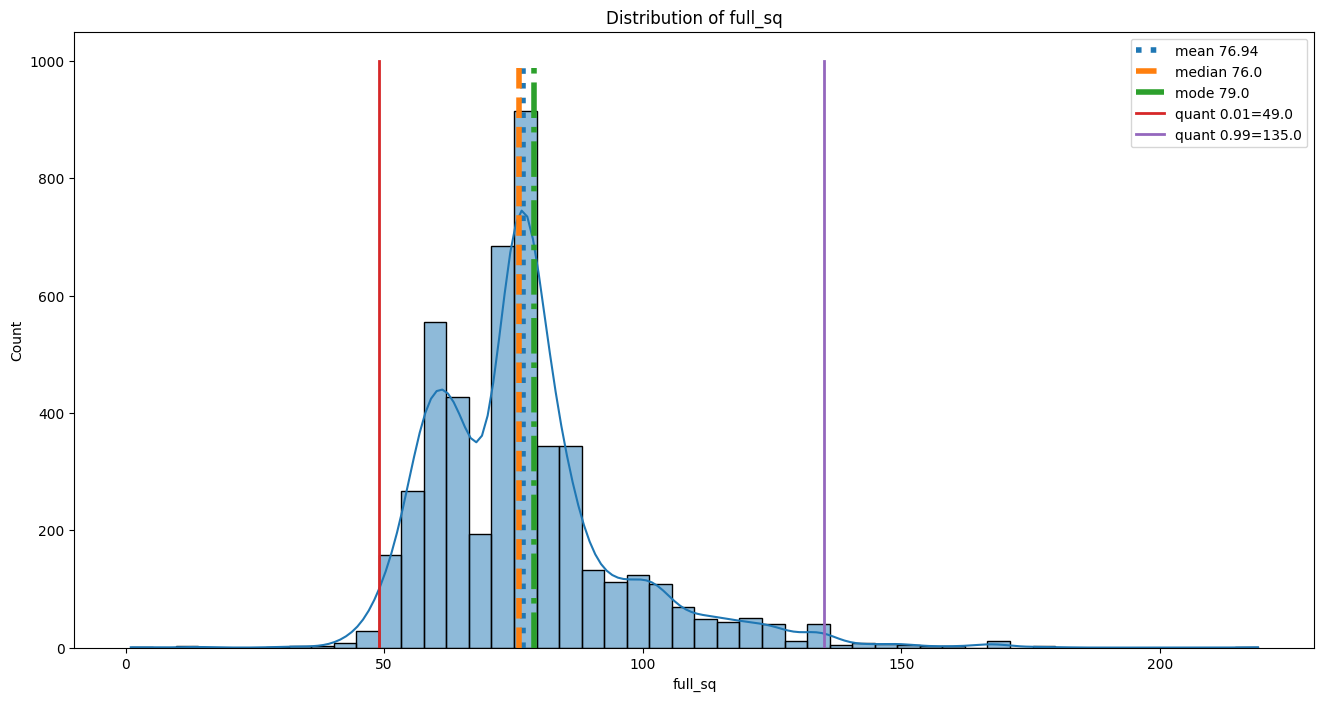

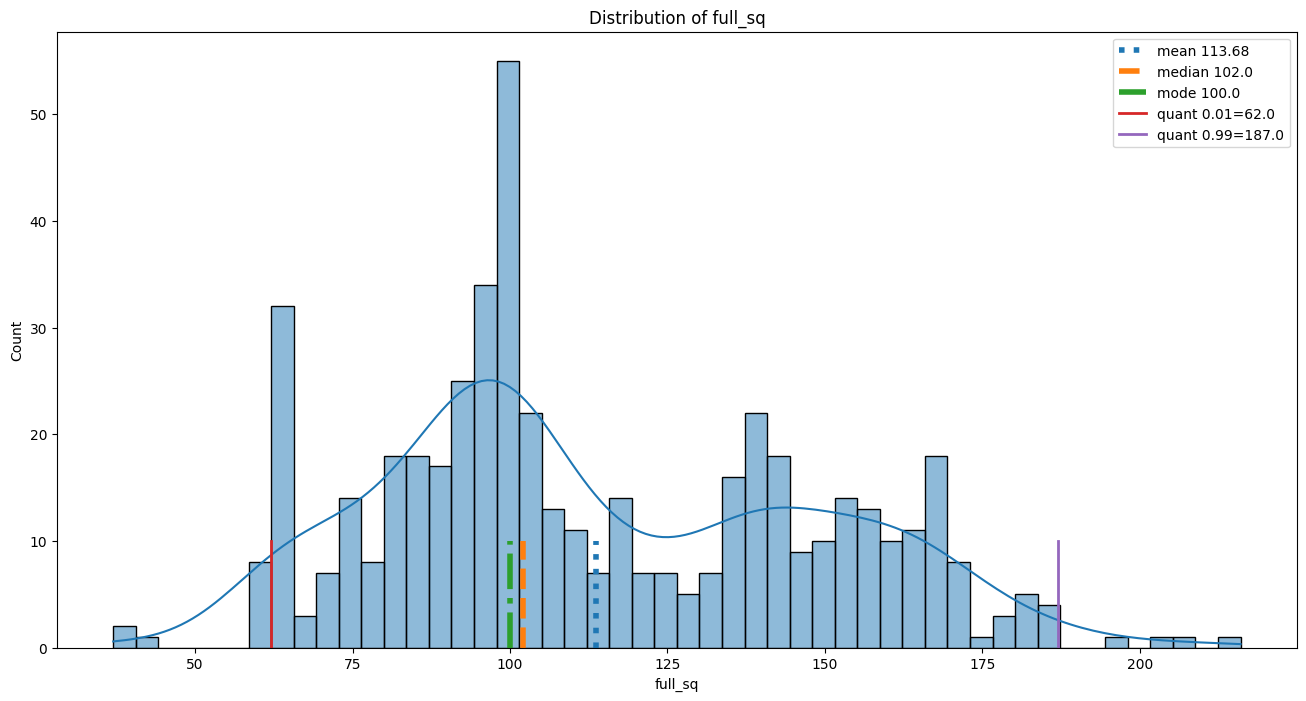

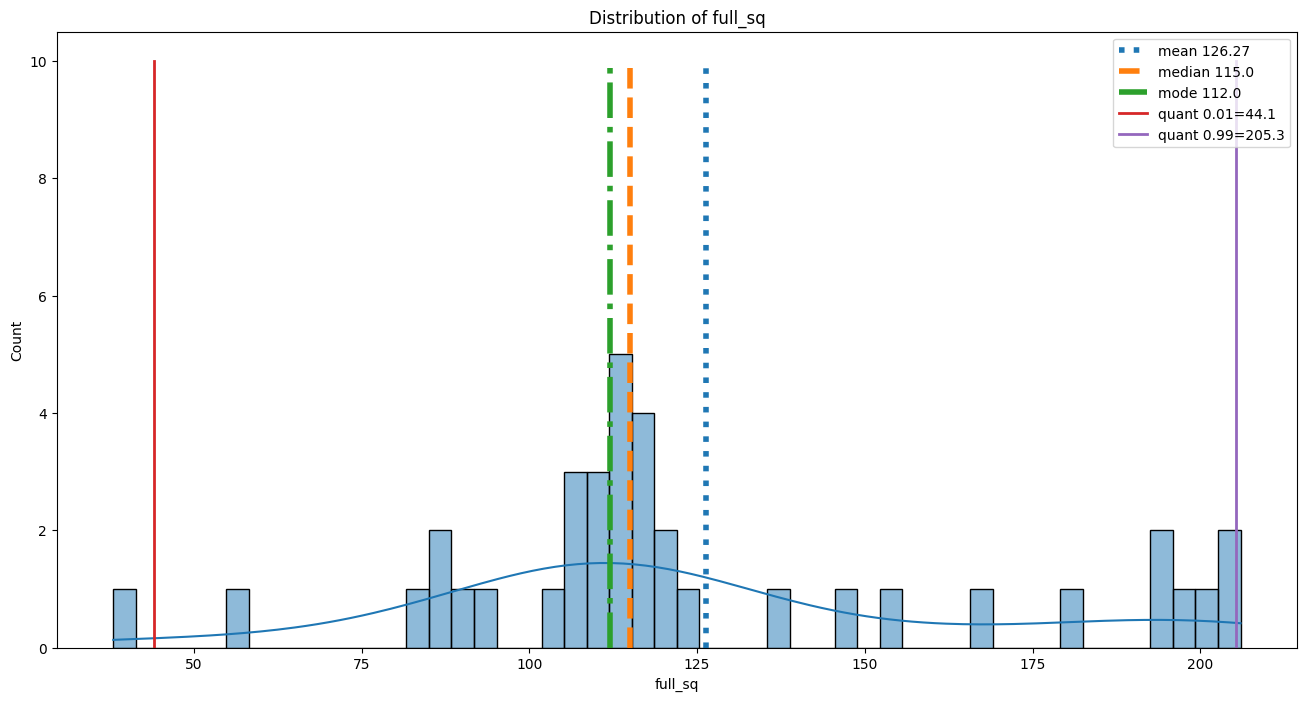

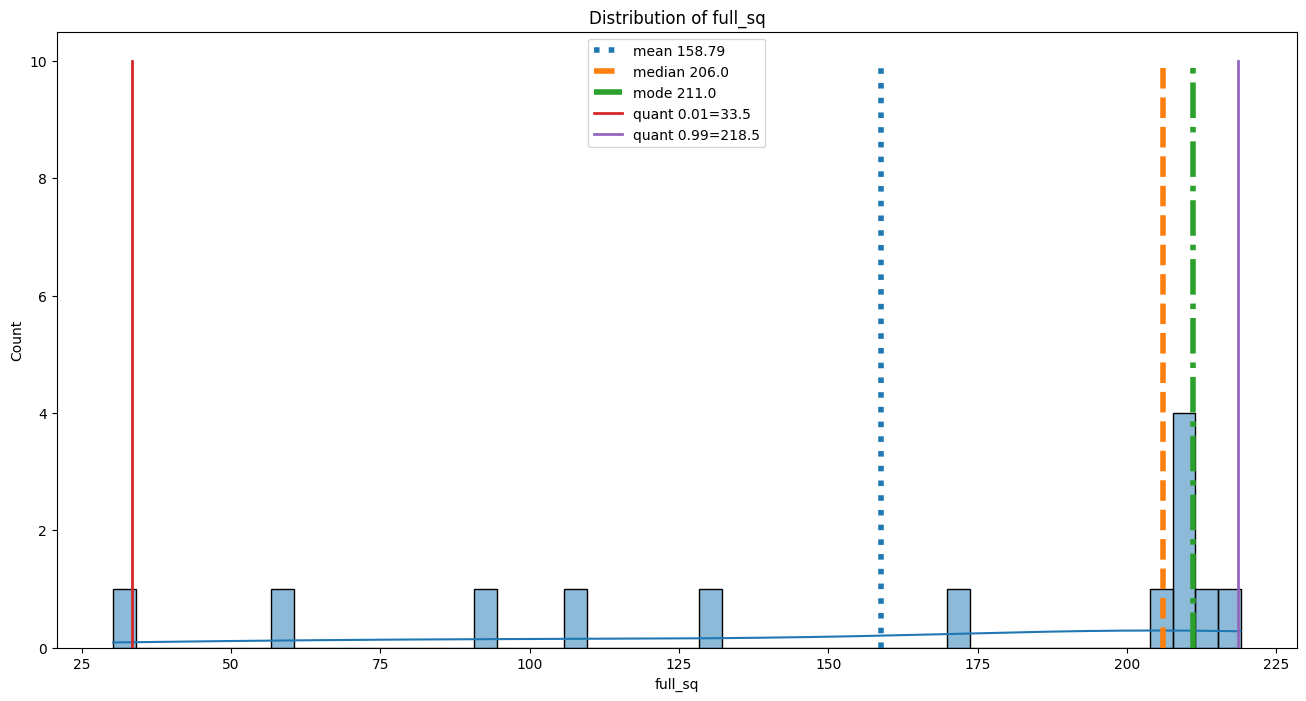

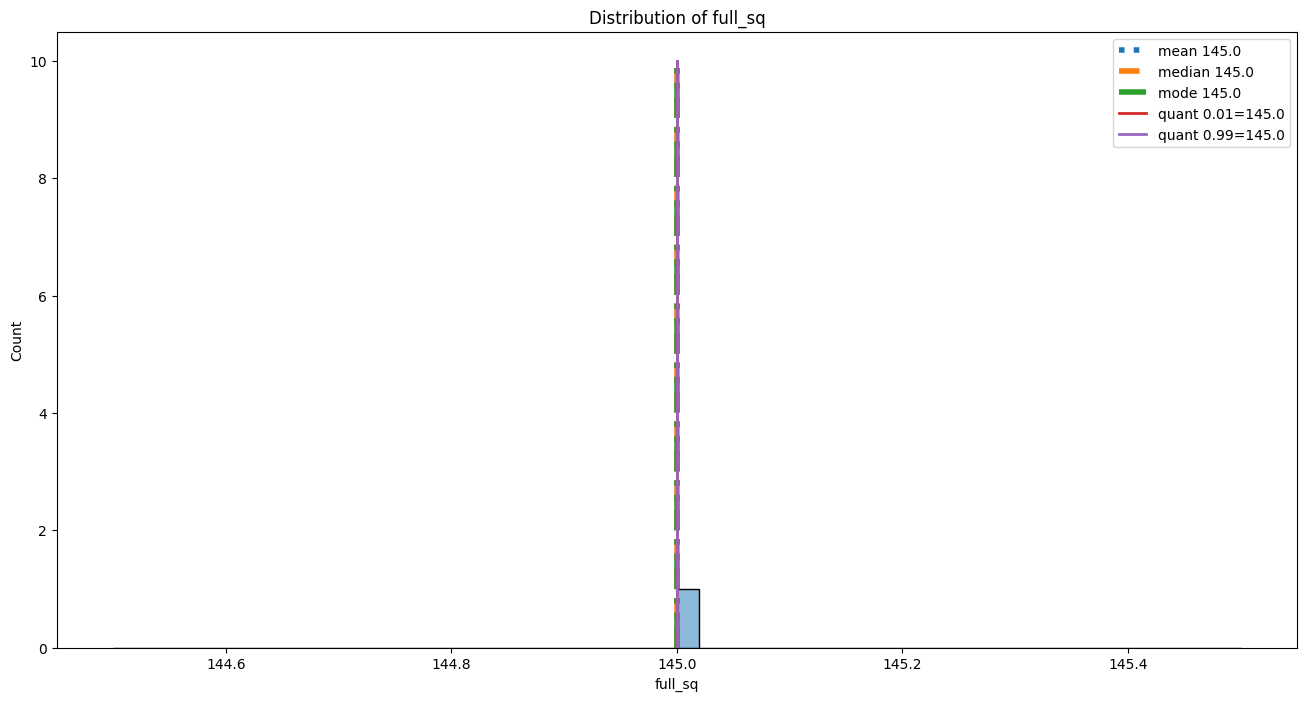

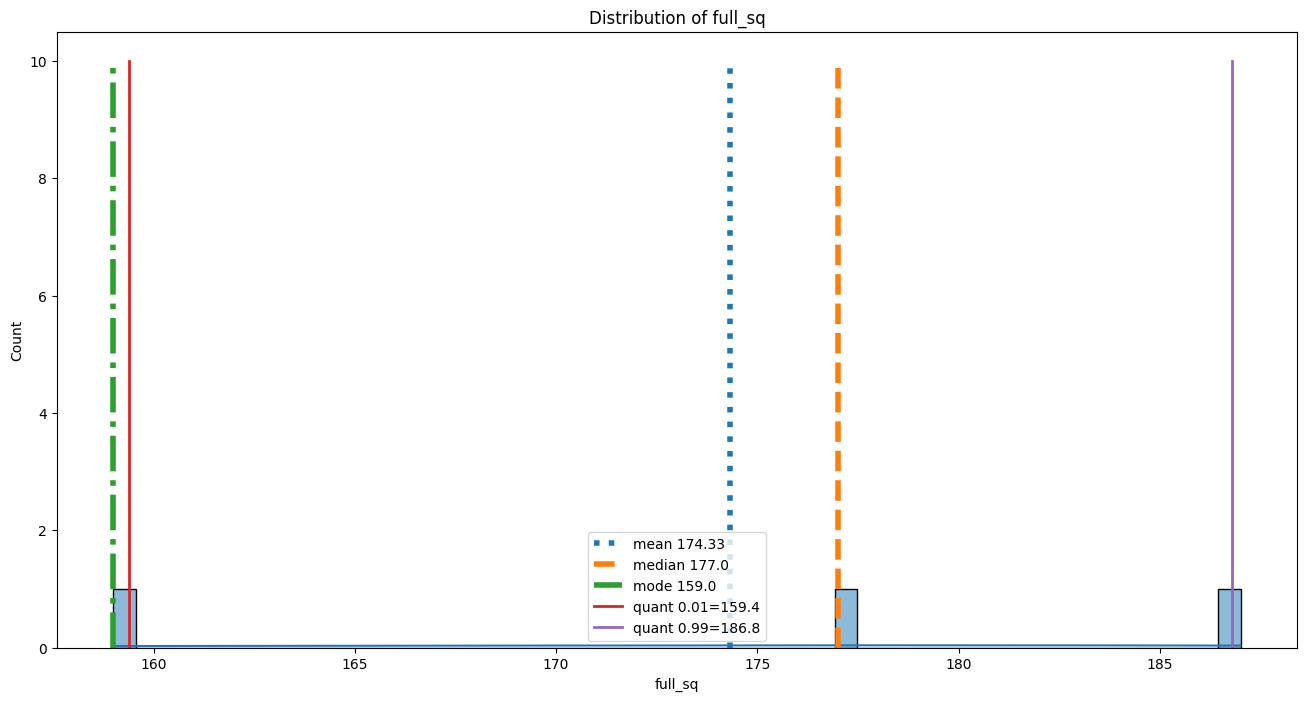

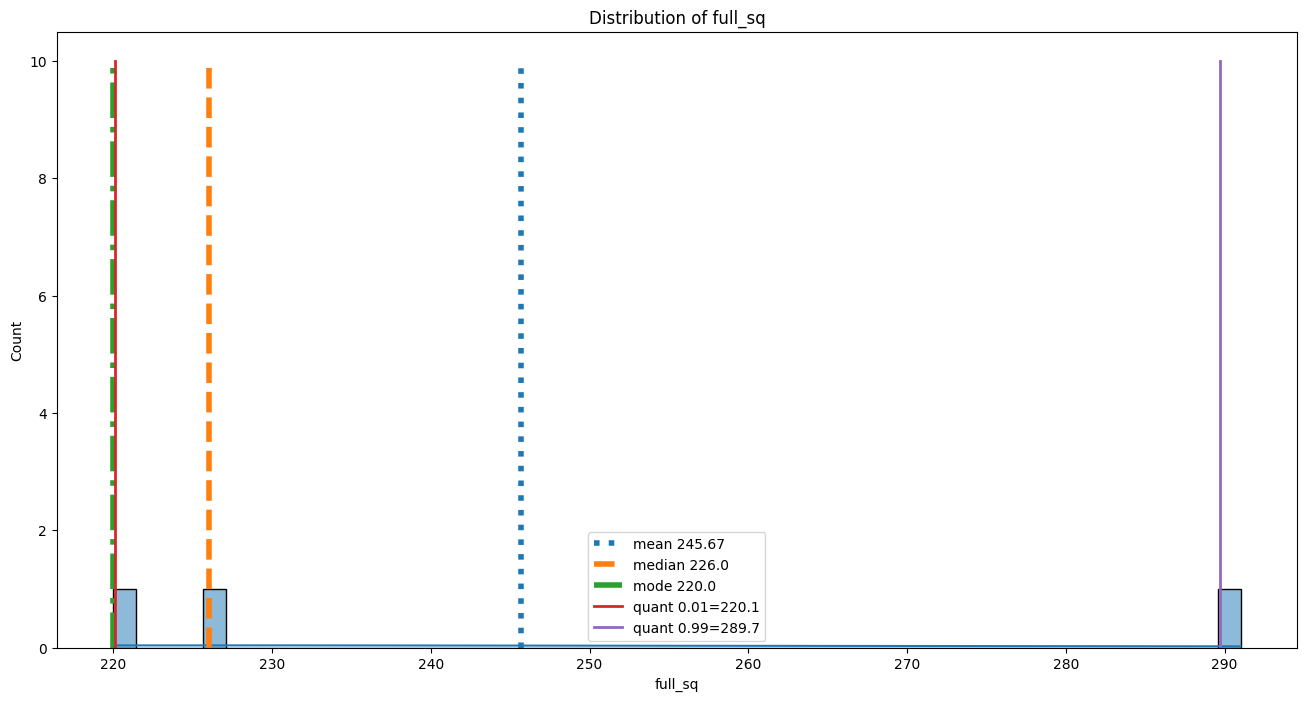

In [ ]:
for room in num_room_list:
    if room <= 3:
        Mean_Median_Mode(df[df['num_room'] == room]['full_sq'])
    else:
        Mean_Median_Mode(df[df['num_room'] == room]['full_sq'], divisor=10)

In [ ]:
df.to_csv(path_to_work_dir + "df.csv", index=None)

In [ ]:
df = pd.read_csv(path_to_work_dir + "df.csv")

#### 5.3.3 Kitchen square

In [ ]:
df.loc[(df['full_sq'].notna()) &
        (df['life_sq'].notna()) &
         ((df['kitch_sq'].isna()) | (df['kitch_sq'] < 5)) &
       (df['full_sq'] > df['life_sq']),
       ['kitch_sq']] = df[(df['full_sq'].notna()) &
                            (df['life_sq'].notna()) &
                            ((df['kitch_sq'].isna()) | (df['kitch_sq'] < 5)) &
                            (df['full_sq'] > df['life_sq'])]['full_sq'] - df[(df['full_sq'].notna()) &
                                                                            (df['life_sq'].notna()) &
                                                                            ((df['kitch_sq'].isna()) | (df['kitch_sq'] < 5)) &
                                                                            (df['full_sq'] > df['life_sq'])]['life_sq']

In [ ]:
df['full_sq_to_kitch_sq'] = (df[(df['life_sq'].notna()) &
                                (df['kitch_sq'].notna()) &
                                (df['full_sq'] > df['life_sq']) &
                                (df['kitch_sq'] > 5)]['kitch_sq'] / df[(df['life_sq'].notna()) &
                                                                        (df['kitch_sq'].notna()) &
                                                                        (df['full_sq'] > df['life_sq']) &
                                                                        (df['kitch_sq'] > 5)]['full_sq']) * 100

In [ ]:
num_room_list = df['num_room'].value_counts().index.tolist()
num_room_list.sort()

1.0 
**************************************************



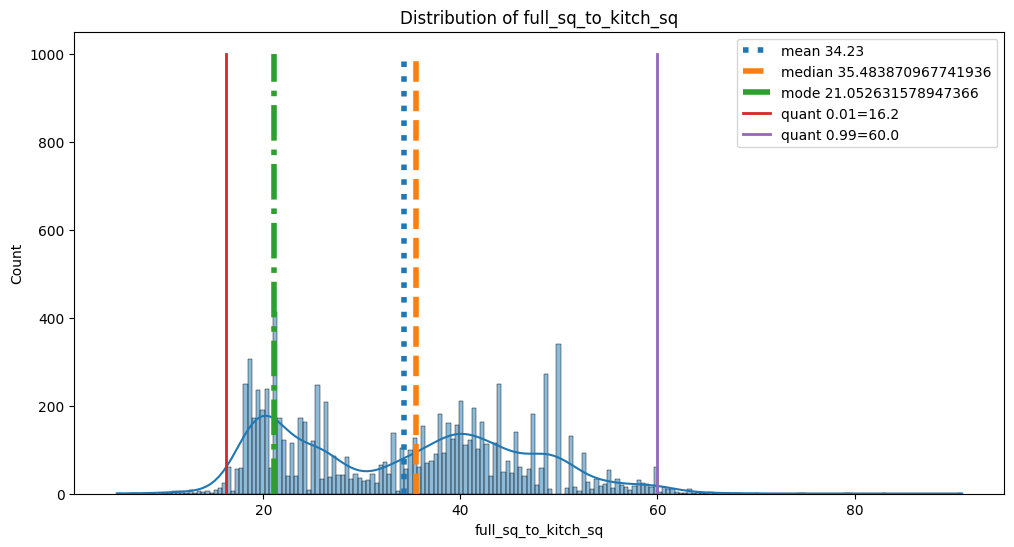

2.0 
**************************************************



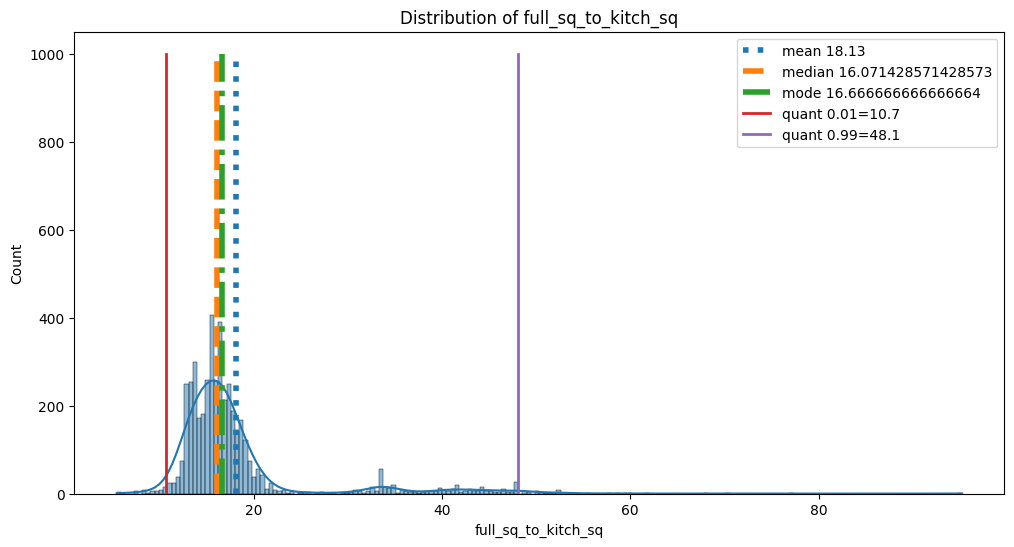

3.0 
**************************************************



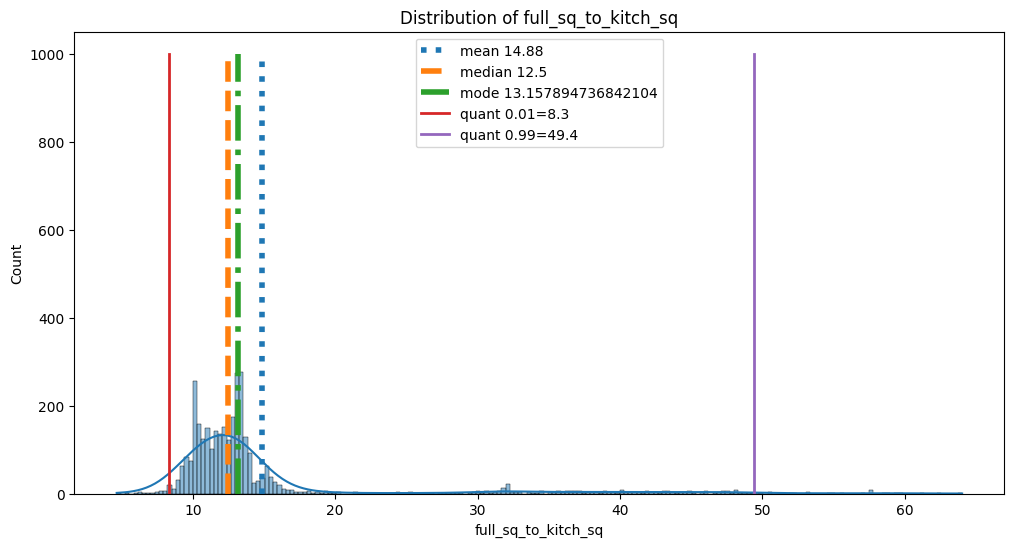

4.0 
**************************************************



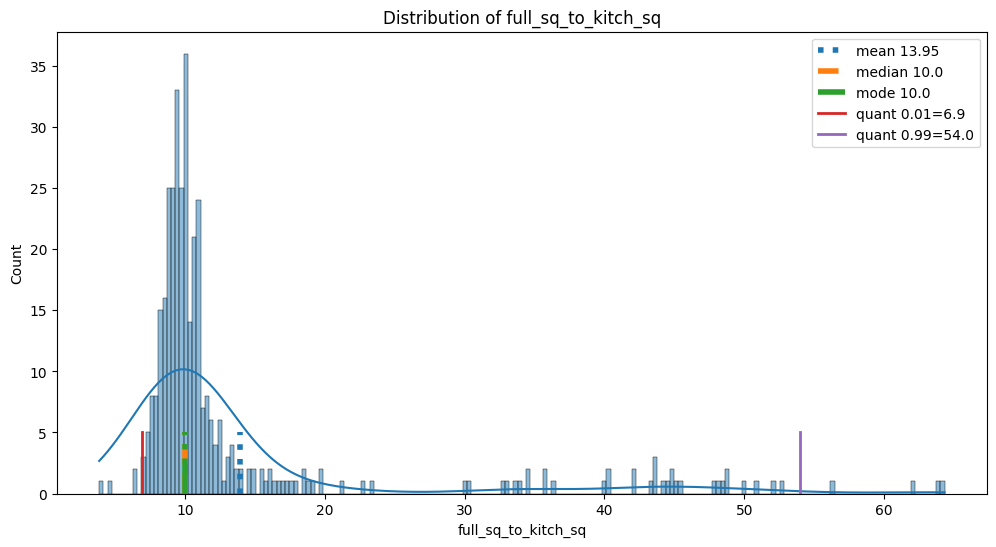

5.0 
**************************************************



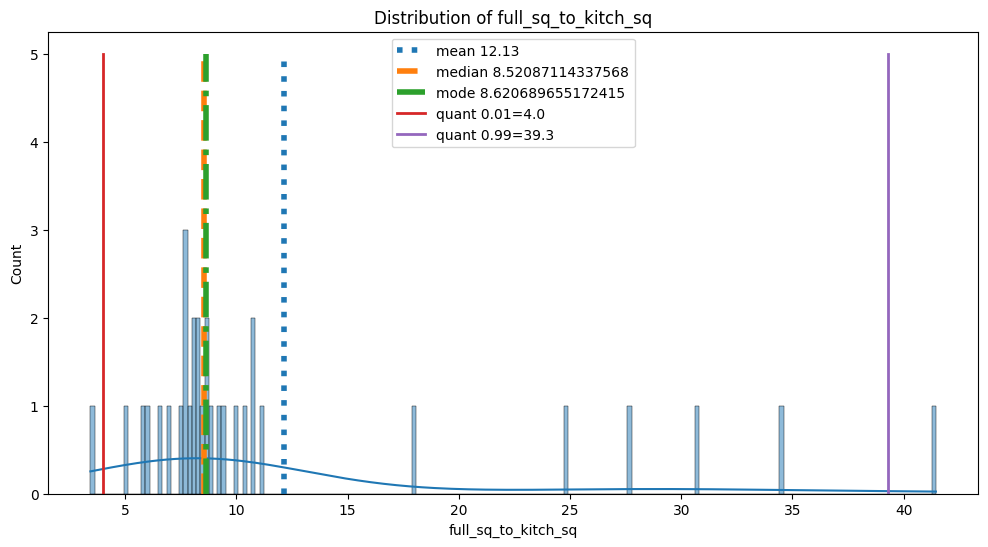

6.0 
**************************************************



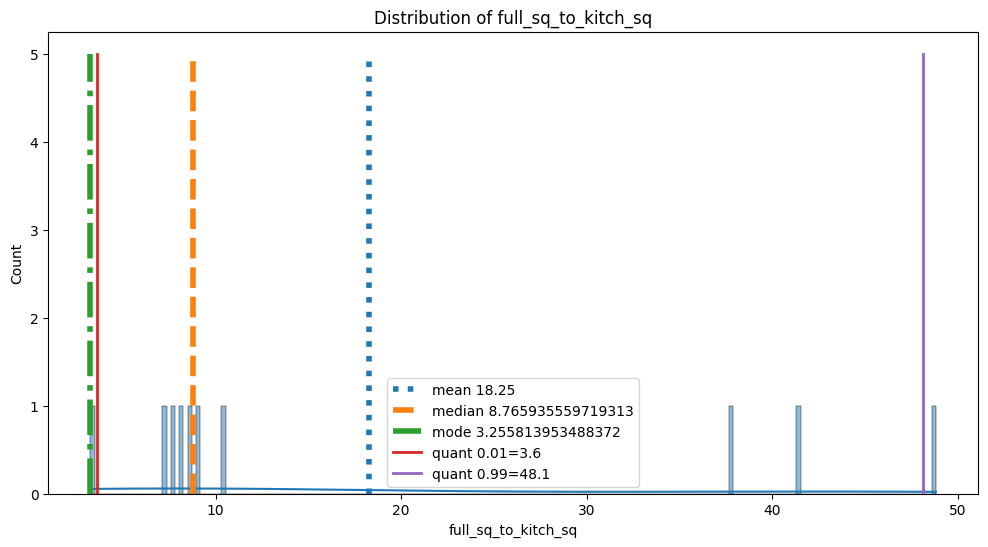

7.0 
**************************************************



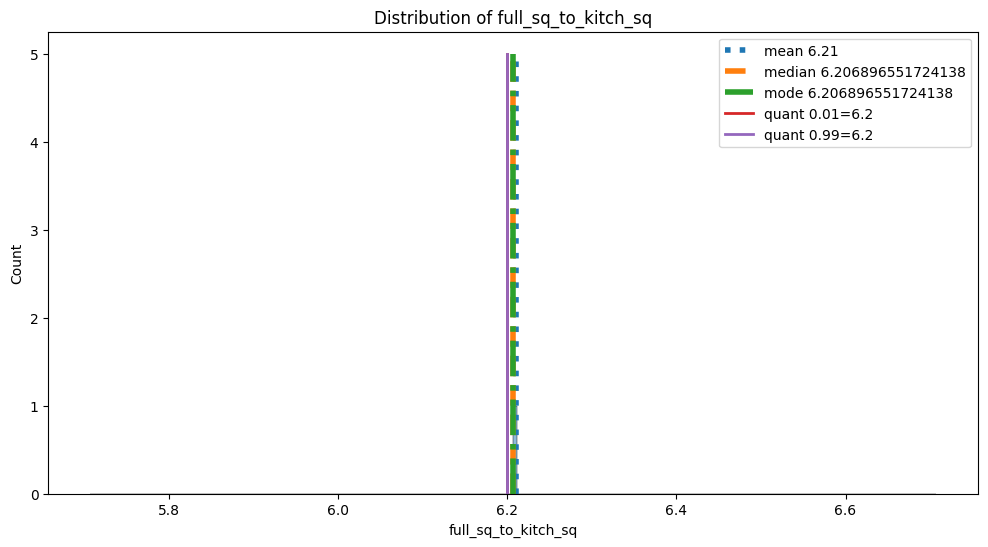

8.0 
**************************************************



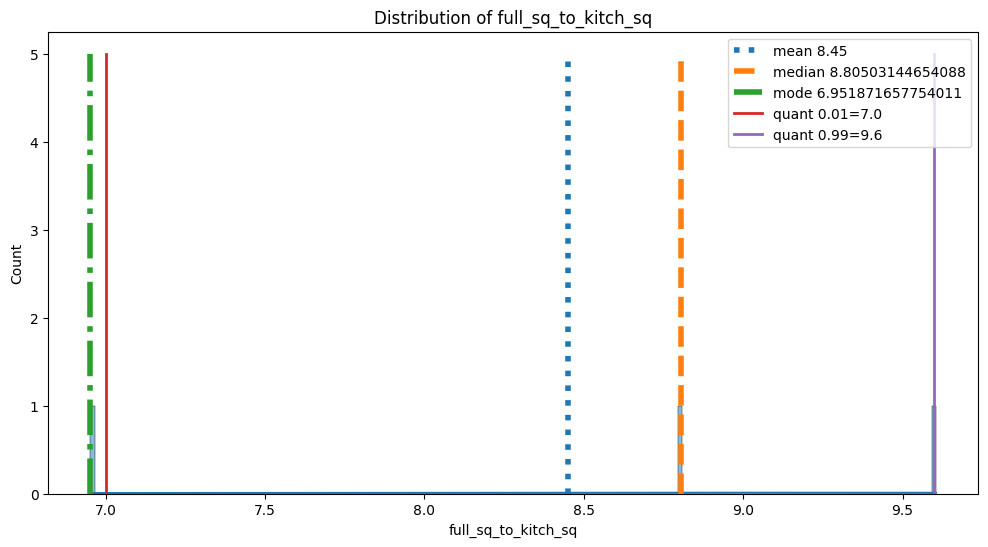

9.0 
**************************************************



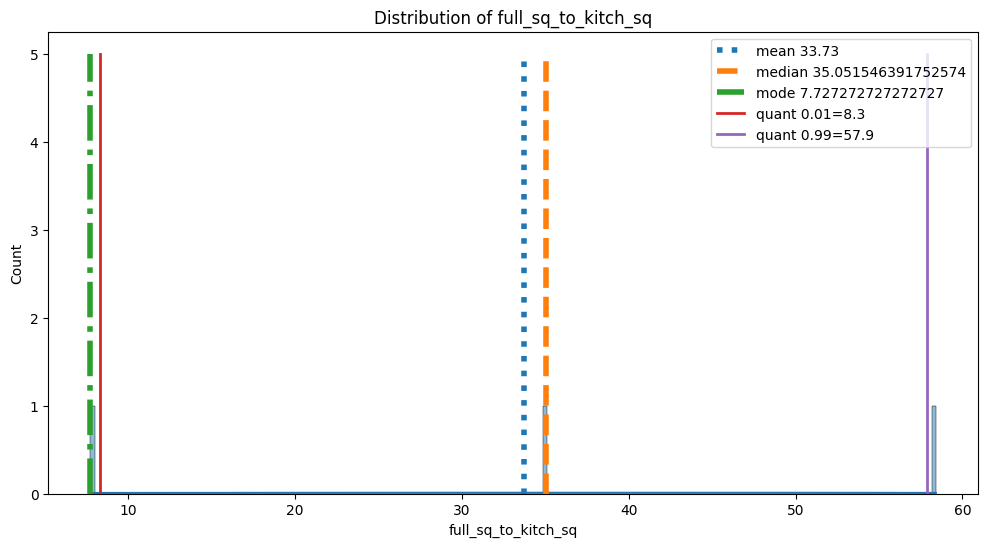

In [ ]:
for room in num_room_list:
    print(room, star("*"))
    if room <= 3:
        Mean_Median_Mode(df[(df['num_room'] == room) & (df['full_sq_to_kitch_sq'].notna())]['full_sq_to_kitch_sq'], b=200)
    else:
        Mean_Median_Mode(df[(df['num_room'] == room) & (df['full_sq_to_kitch_sq'].notna())]['full_sq_to_kitch_sq'], divisor=5, b=200)

In [ ]:
divisor_kitch_sq_dict = {1:35, 2:16, 3:13, 4:10, 5:8, 6:8, 7:6, 8:9, 9:8}

In [ ]:
for k,v in divisor_kitch_sq_dict.items():
    df.loc[(df['num_room'] == k) &
     (df['kitch_sq'].isna()), ['kitch_sq']] = df[(df['num_room'] == k) &
                                                (df['kitch_sq'].isna())]['full_sq'] / v

In [ ]:
df['full_sq_to_kitch_sq_after_fill'] = (df[(df['life_sq'].notna()) &
                                (df['kitch_sq'].notna()) &
                                (df['kitch_sq'] > 5)]['kitch_sq'] / df[(df['life_sq'].notna()) &
                                                                        (df['kitch_sq'].notna()) &
                                                                        (df['kitch_sq'] > 5)]['full_sq']) * 100

1.0 
**************************************************



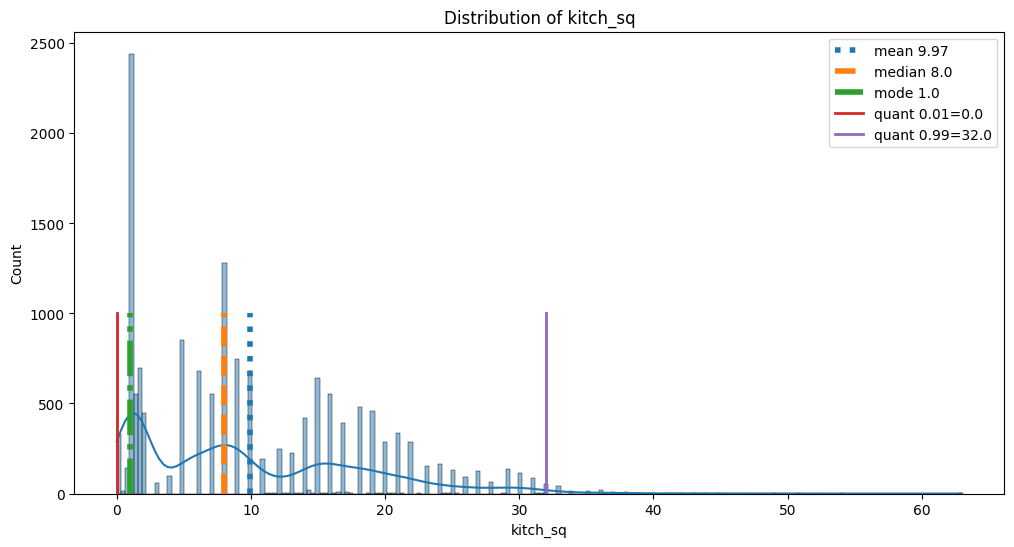

2.0 
**************************************************



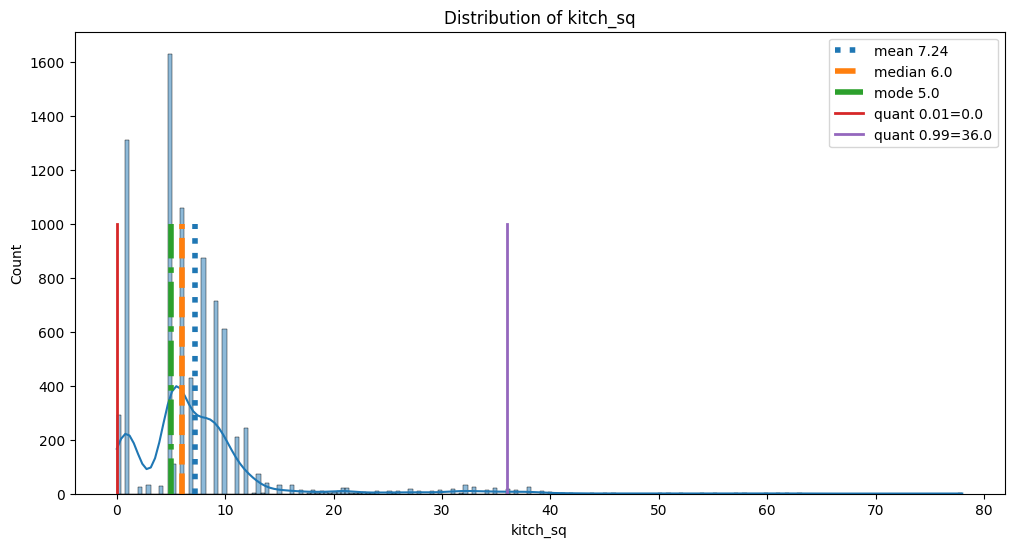

3.0 
**************************************************



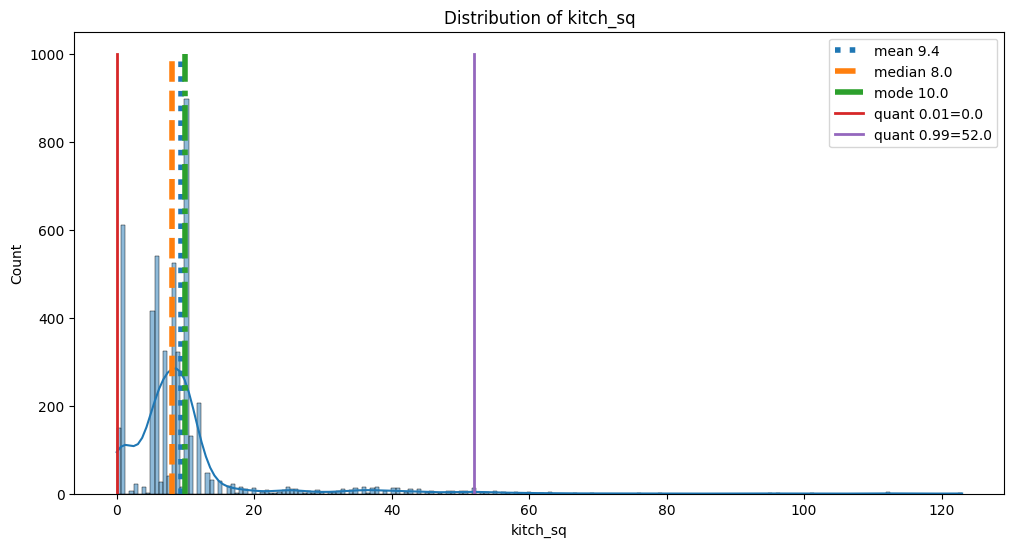

4.0 
**************************************************



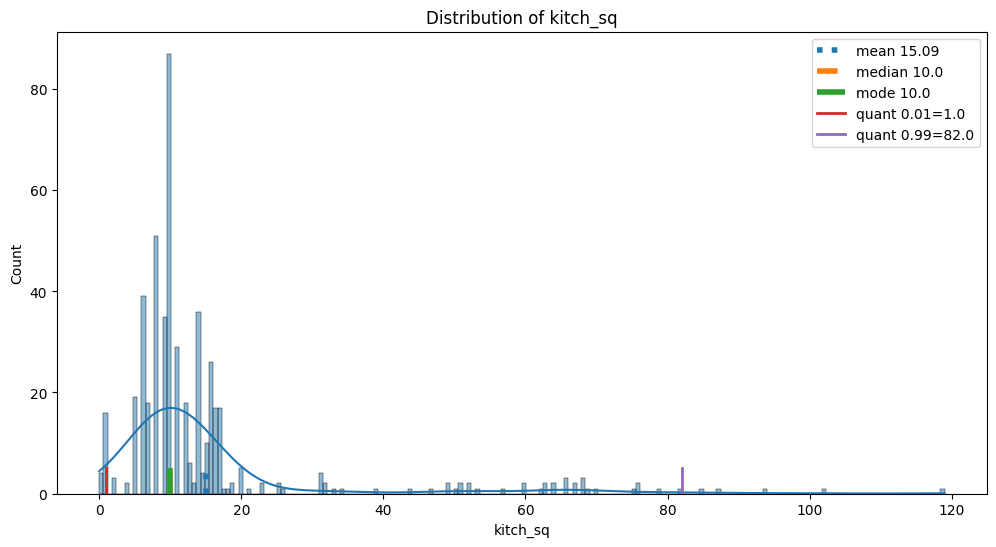

5.0 
**************************************************



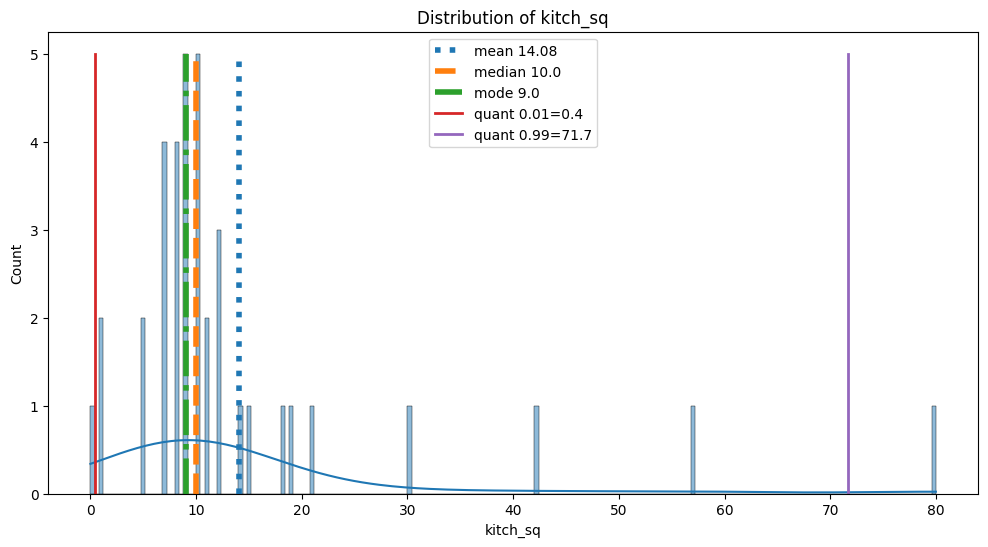

6.0 
**************************************************



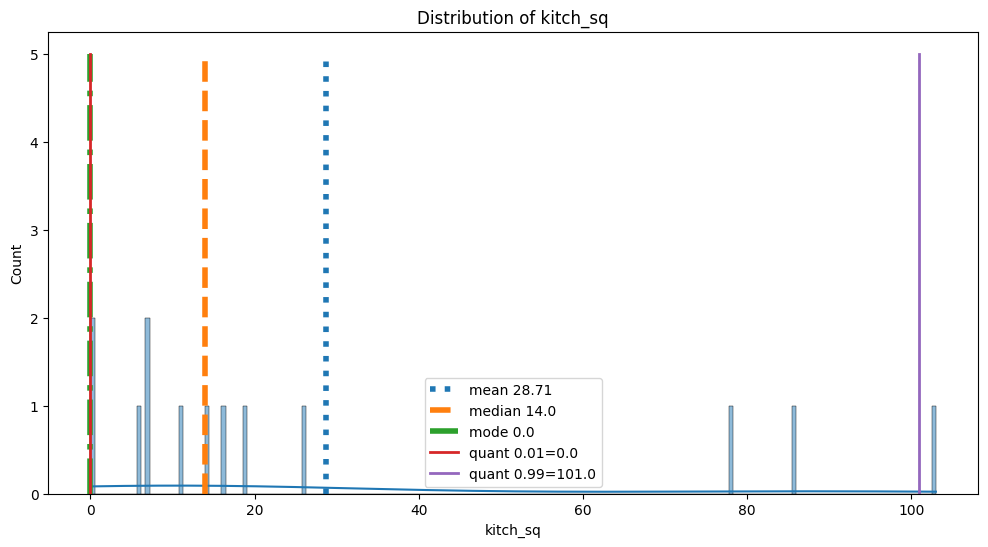

7.0 
**************************************************



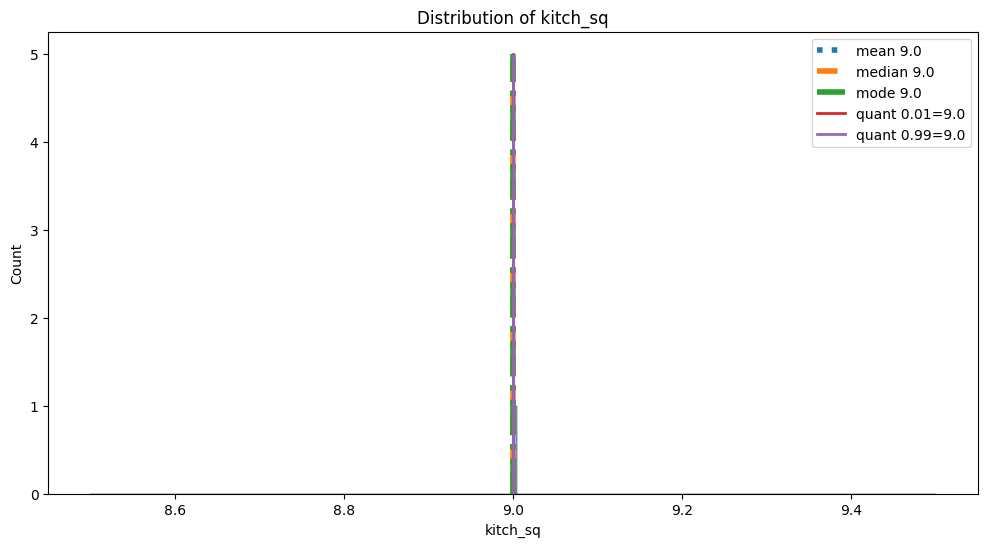

8.0 
**************************************************



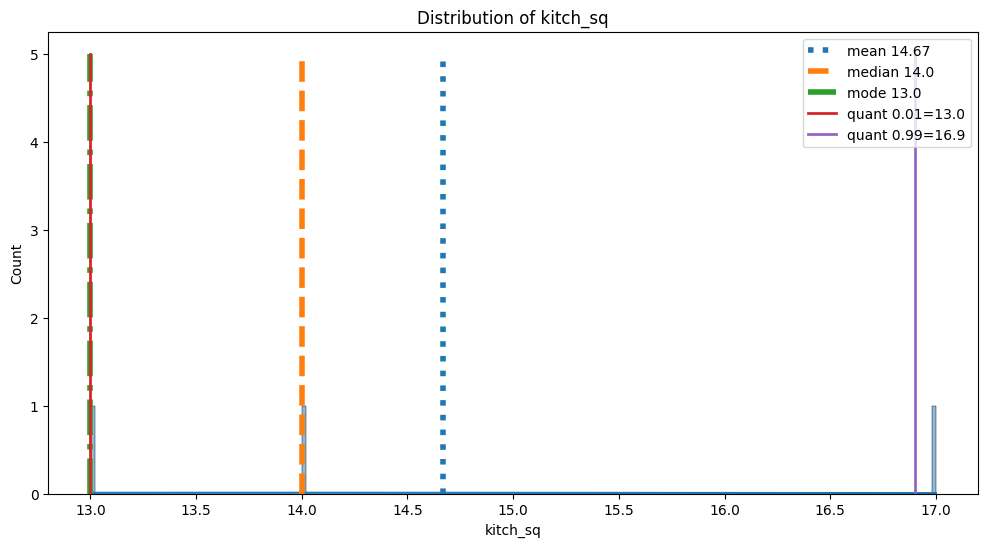

9.0 
**************************************************



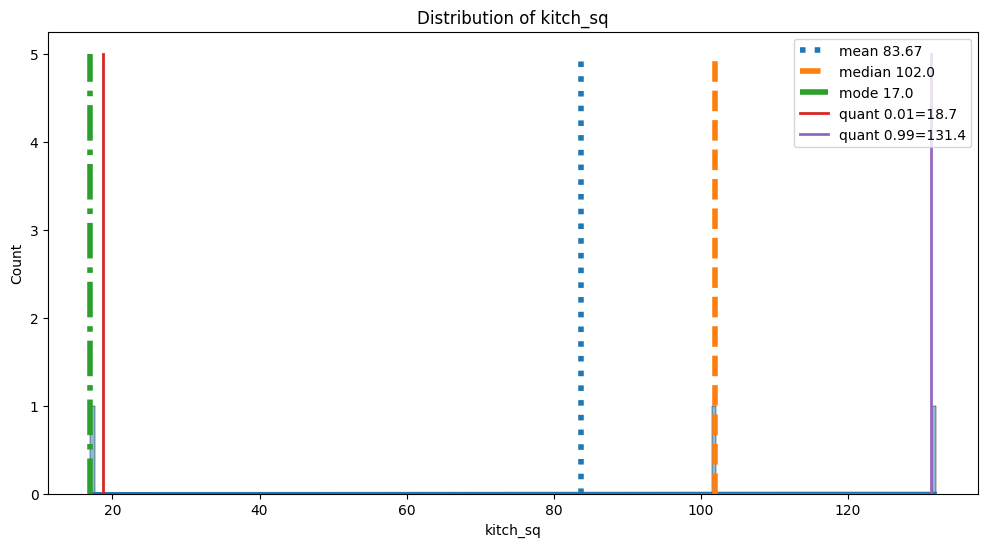

In [ ]:
for room in num_room_list:
    print(room, star("*"))
    if room <= 3:
        Mean_Median_Mode(df[(df['num_room'] == room)]['kitch_sq'], b=200)
    else:
        Mean_Median_Mode(df[(df['num_room'] == room)]['kitch_sq'], divisor=5, b=200)

<Axes: xlabel='kitch_sq', ylabel='Count'>

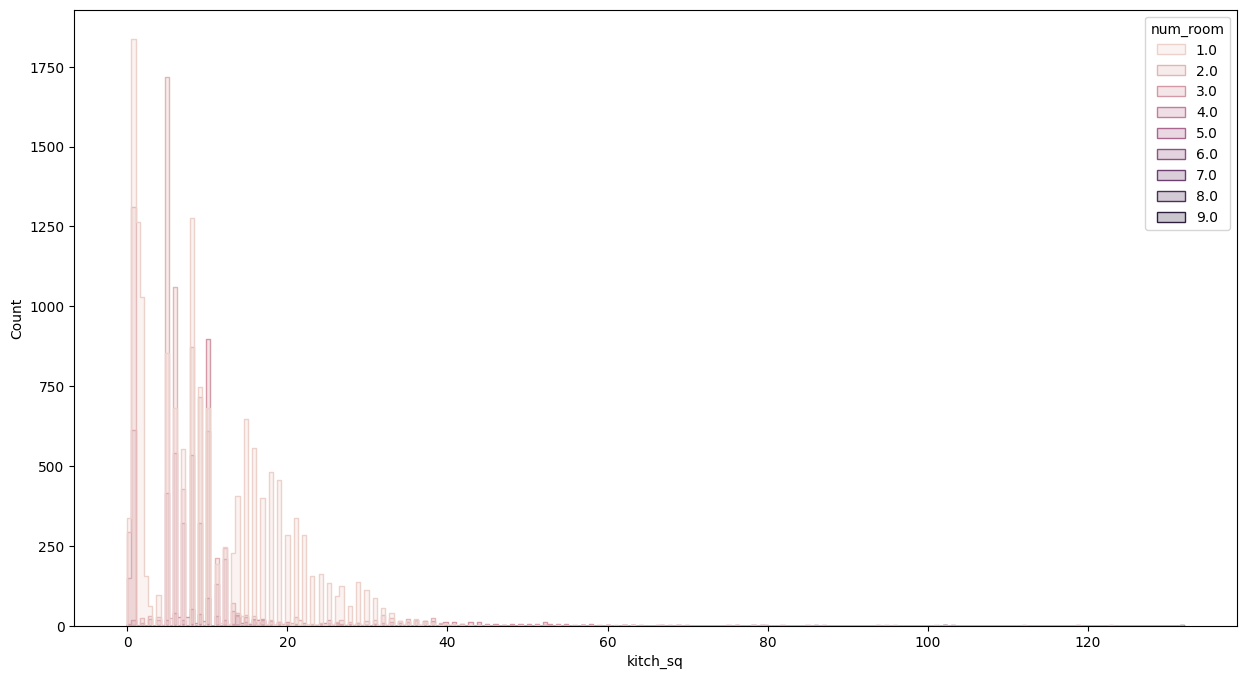

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(df, x='kitch_sq', hue='num_room', element="step")

In [ ]:
for room in num_room_list:
    print(f"Room {room} {df.loc[(df['kitch_sq'] < 5) & (df['num_room'] == room)].shape[0]}")

Room 1.0 4779
Room 2.0 1884
Room 3.0 805
Room 4.0 25
Room 5.0 3
Room 6.0 2
Room 7.0 0
Room 8.0 0
Room 9.0 0


In [ ]:
df.loc[(df['kitch_sq'] < 5) & (df['num_room'] == 3), ['kitch_sq']] = df[(df['kitch_sq'] > 5) & (df['num_room'] == 3)]['kitch_sq'].mode()[0]
df.loc[(df['kitch_sq'] < 5) & (df['num_room'] == 4), ['kitch_sq']] = df[(df['kitch_sq'] > 5) & (df['num_room'] == 3)]['kitch_sq'].mode()[0]
df.loc[(df['kitch_sq'] < 5) & (df['num_room'] == 5), ['kitch_sq']] = df[(df['kitch_sq'] > 5) & (df['num_room'] == 3)]['kitch_sq'].mode()[0]
df.loc[(df['kitch_sq'] < 5) & (df['num_room'] == 6), ['kitch_sq']] = df[(df['kitch_sq'] > 5) & (df['num_room'] == 3)]['kitch_sq'].mode()[0]

In [ ]:
df.loc[(df['kitch_sq'] < 5) & (df['num_room'] <= 2), ['kitch_sq']] = 1

#### 5.3.4 Life square

In [ ]:
df.loc[(df['kitch_sq'] < 5) & (df['life_sq'].isna()), ['num_room']].value_counts()

num_room
1.0         3074
2.0         1318
dtype: int64

In [ ]:
df['euro_type'] = 0

In [ ]:
df.loc[(df['kitch_sq'] < 5), ['euro_type']] = 1

In [ ]:
df.loc[(df['kitch_sq'] < 5), ['life_sq']] = df[(df['kitch_sq'] < 5)]['full_sq'] - df[(df['kitch_sq'] < 5)]['kitch_sq']

In [ ]:
df.loc[(df['kitch_sq'] < 5) & (df['full_sq'] < 10) & (df['num_room'] == 1), ['full_sq']] = 18
df.loc[(df['kitch_sq'] < 5) & (df['full_sq'] < 10) & (df['num_room'] == 1), ['life_sq']] = 17

In [ ]:
df.loc[df['life_sq'].isna(), ['life_sq']] = df[(df['life_sq'].isna())]['full_sq'] - df[(df['life_sq'].isna())]['kitch_sq']

#### 5.3.2 Try to fix "cafe_price"

Text(0.5, 0, 'Percents of NaN')

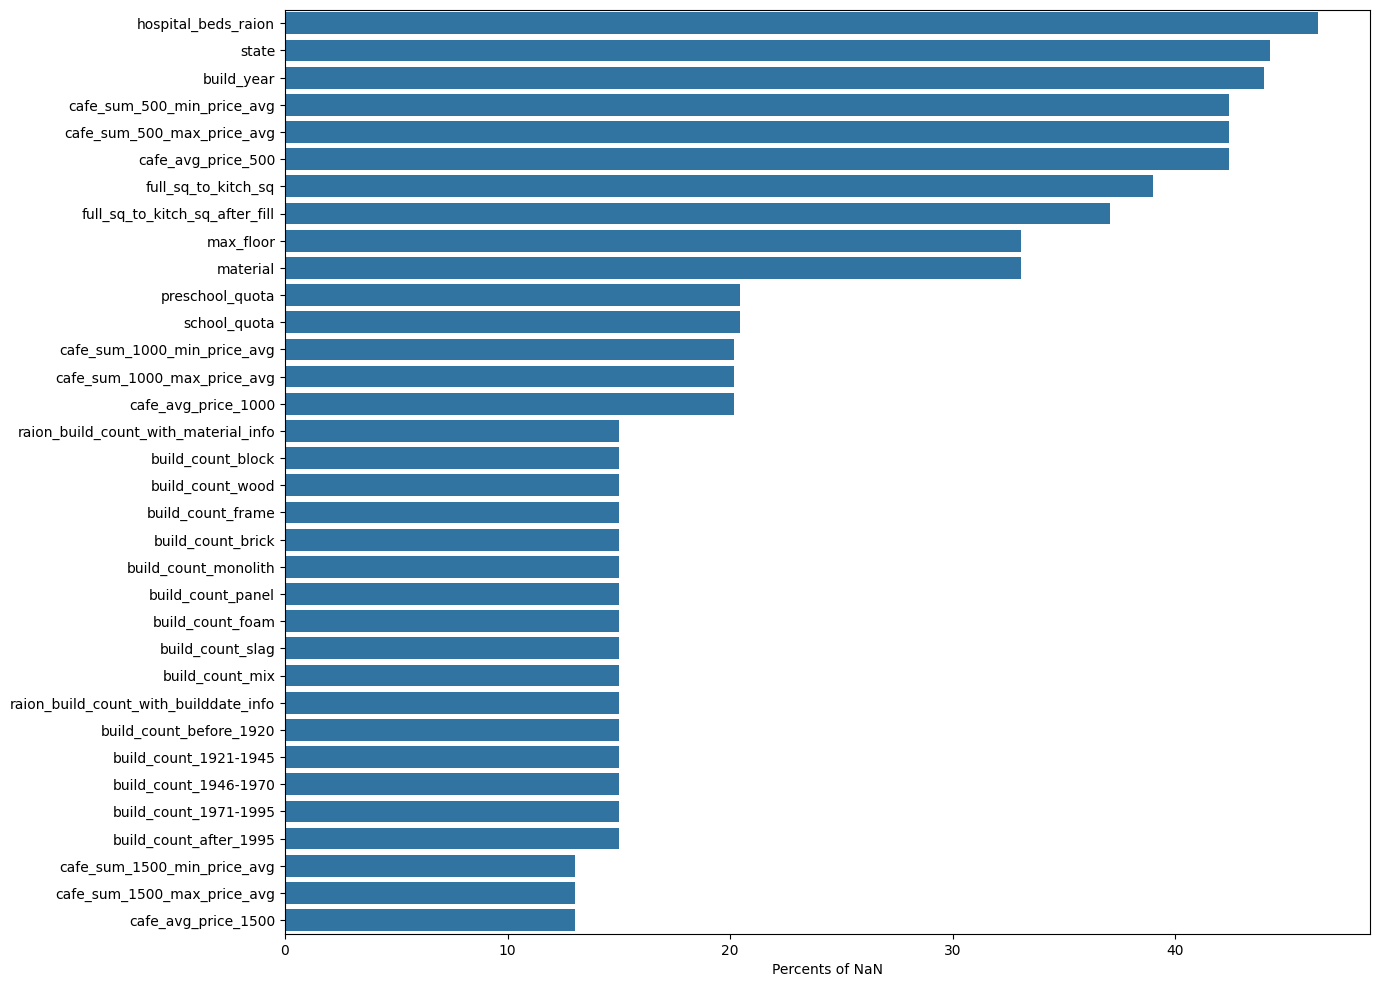

In [ ]:
nul_dict_2 = Null_Dict(df)
nul_dict_sort_2 = dict(sorted(nul_dict_2.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(14,12))
sns.barplot(x=nul_dict_sort_2.values(), y=nul_dict_sort_2.keys())
plt.xlabel("Percents of NaN")

In [ ]:
cafe_columns_list = []
for k in nul_dict_2.keys():
    if "cafe" in k:
        cafe_columns_list.append(k)

In [ ]:
cafe_columns_list

['cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500']

42.4 
**************************************************



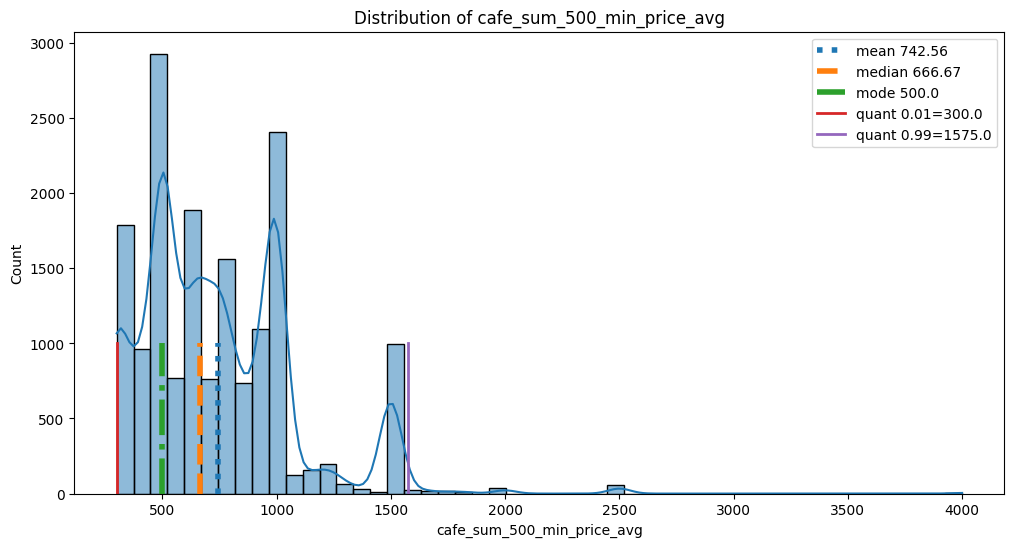

42.4 
**************************************************



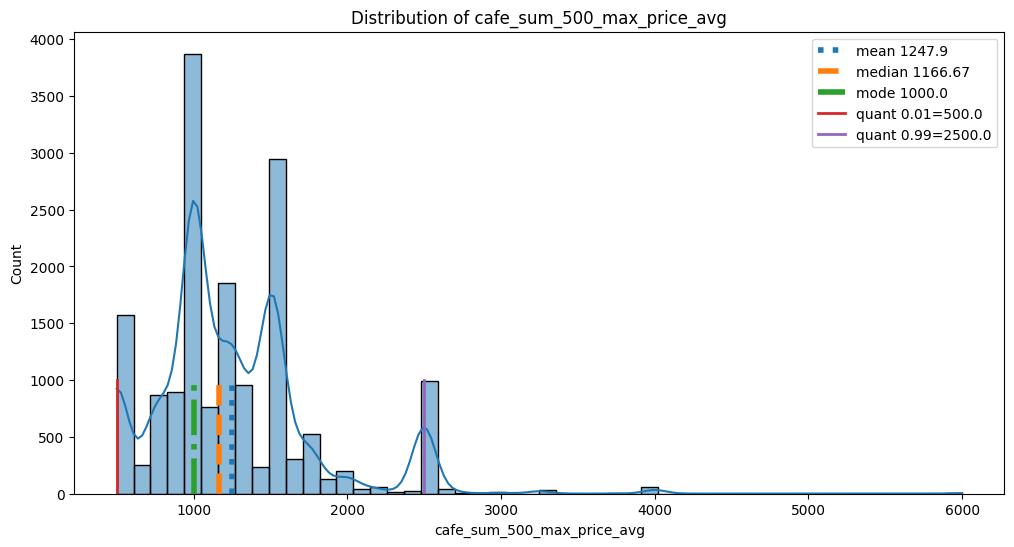

42.4 
**************************************************



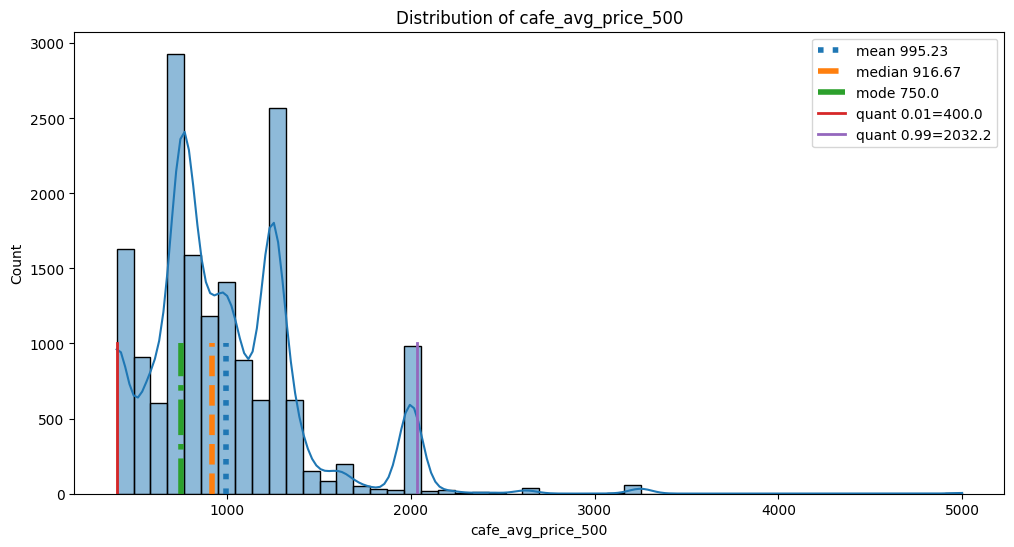

20.19 
**************************************************



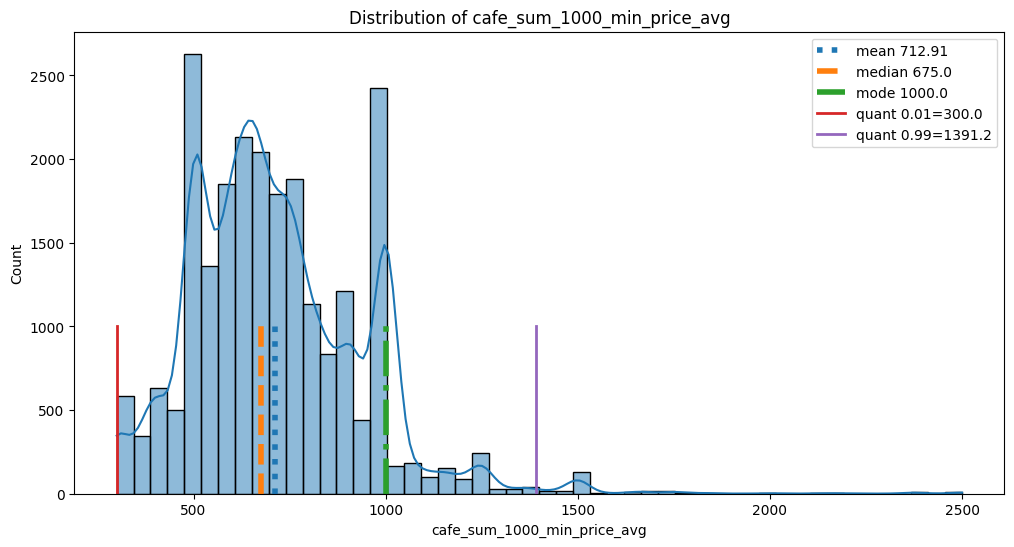

20.19 
**************************************************



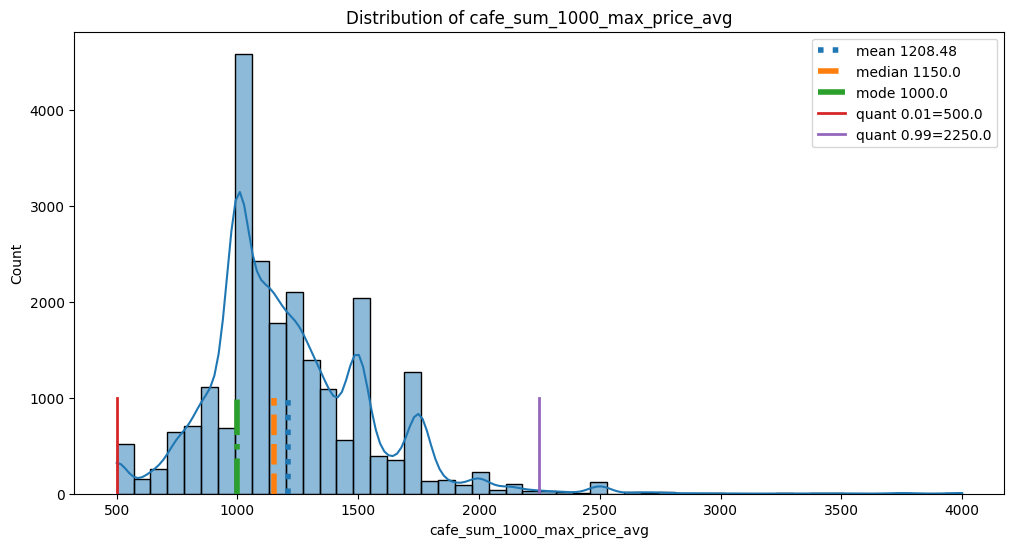

20.19 
**************************************************



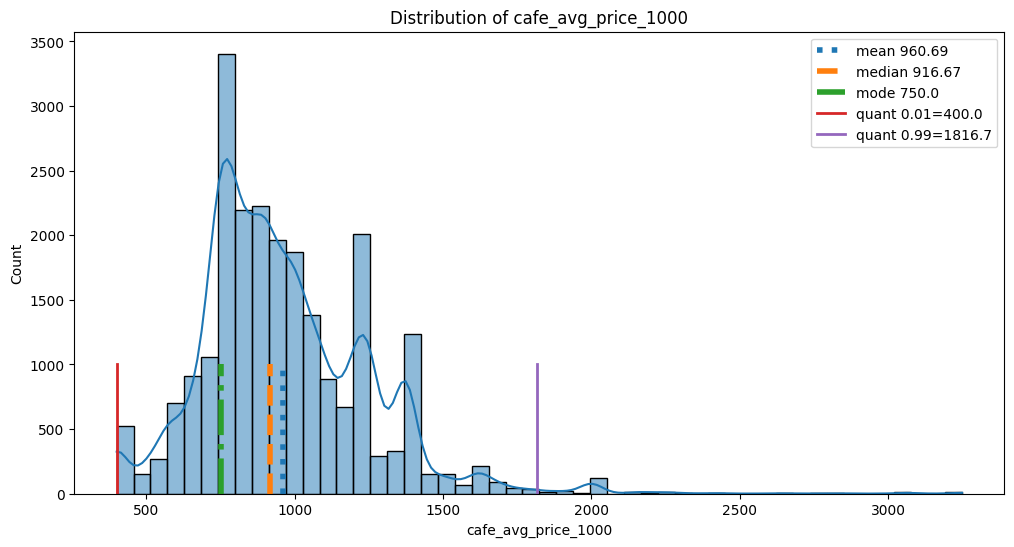

13.04 
**************************************************



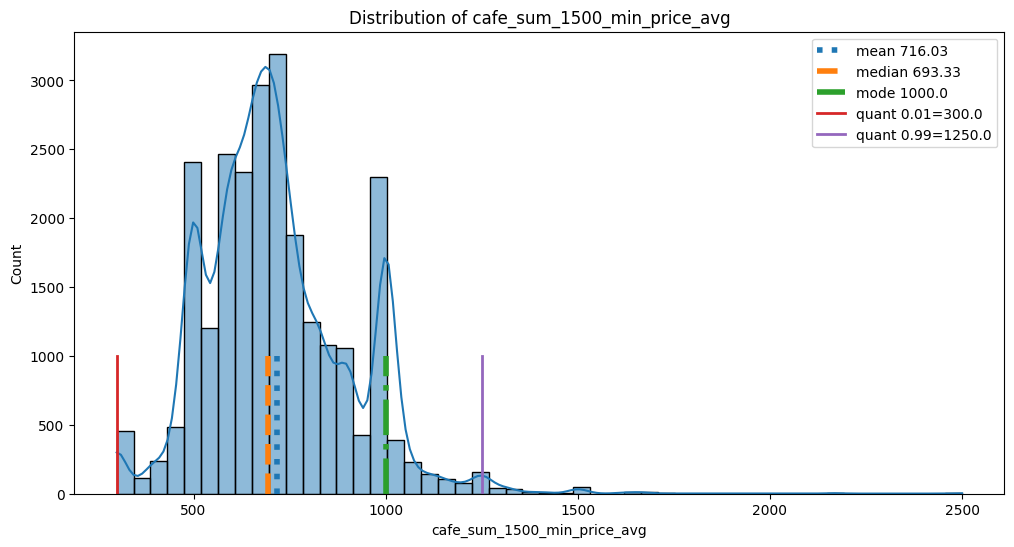

13.04 
**************************************************



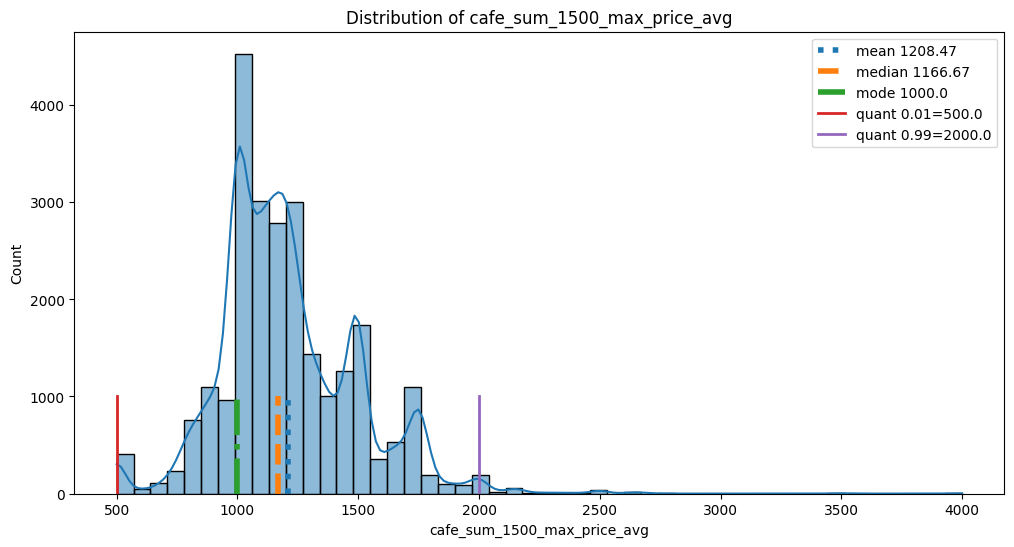

13.04 
**************************************************



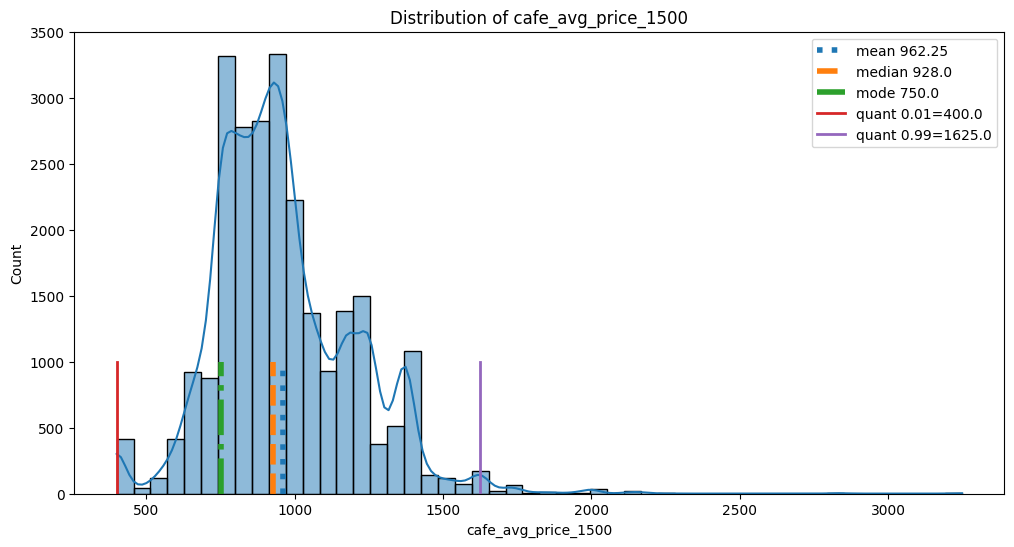

In [ ]:
for col in cafe_columns_list:
    print(nul_dict_2[col], star("*"))
    Mean_Median_Mode(df[df[col].notna()][col])

In [ ]:
median_columns_20 = ["cafe_sum_1000_min_price_avg",
                     "cafe_sum_1000_max_price_avg",
                     "cafe_avg_price_1000",
                     "cafe_sum_1500_min_price_avg",
                     "cafe_sum_1500_max_price_avg",
                     "cafe_avg_price_1500"]

In [ ]:
for col in median_columns_20:
    Fill_Empty_Nan_Median(df, col)

Text(0.5, 0, 'Percents of NaN')

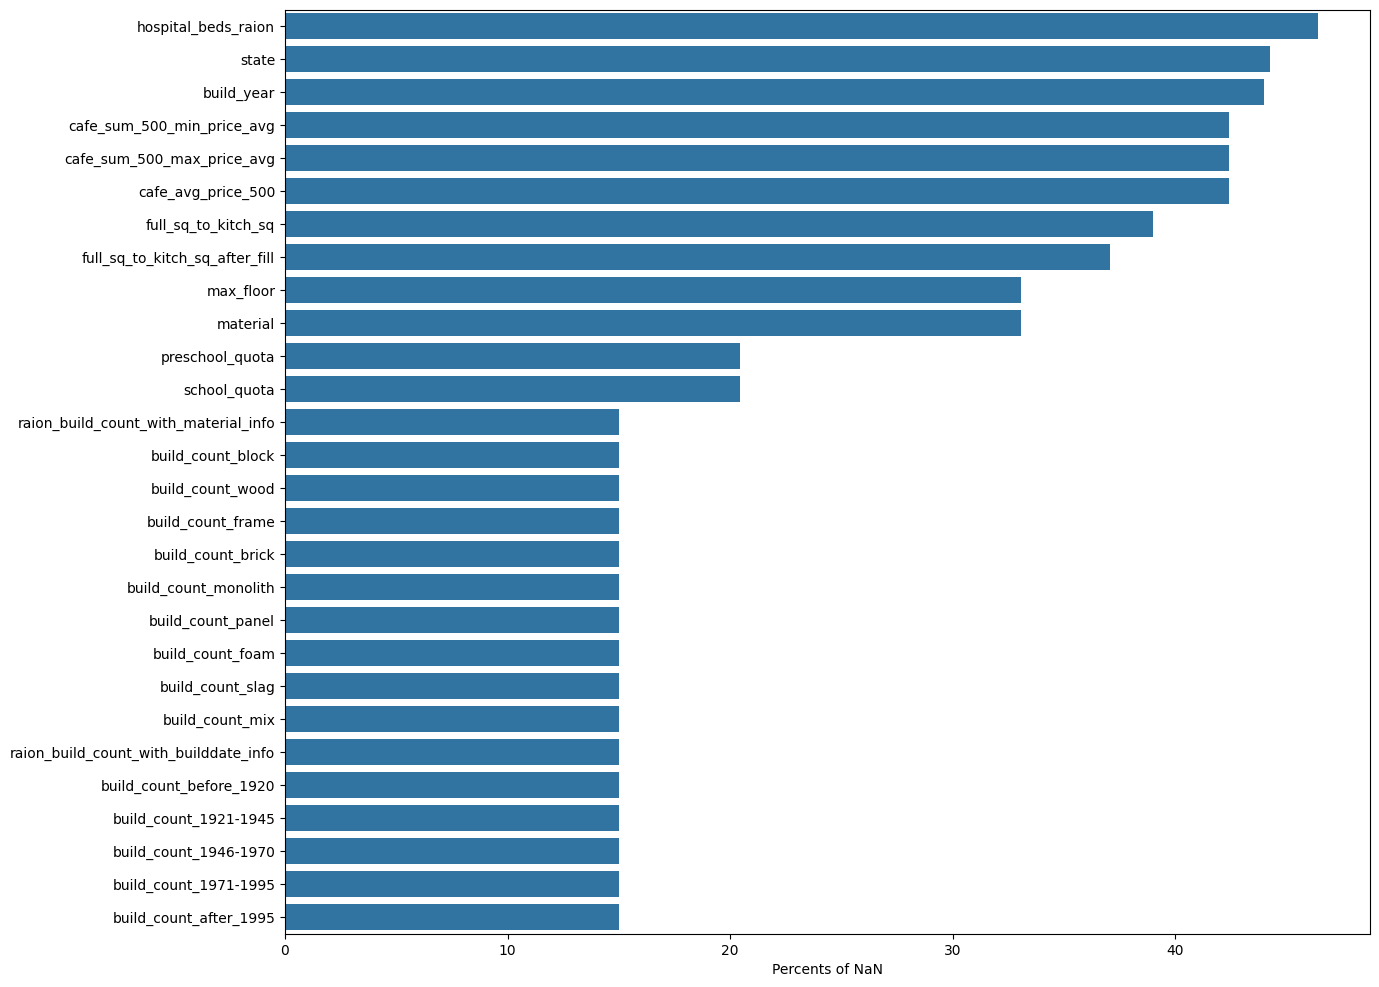

In [ ]:
nul_dict_1_2 = Null_Dict(df)
nul_dict_sort_1_2 = dict(sorted(nul_dict_1_2.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(14,12))
sns.barplot(x=nul_dict_sort_1_2.values(), y=nul_dict_sort_1_2.keys())
plt.xlabel("Percents of NaN")


I think, should not use the signs about build of year.

Because, they are not informative


In [ ]:
build_list = []
cafe_list = []
for col in df.columns:
    if 'build' in col:
        build_list.append(col)
    elif 'cafe' in col:
        cafe_list.append(col)

In [ ]:
df.drop(build_list + cafe_list + list(nul_dict_1_2.keys()), axis=1, inplace=True)

## 6 Make a binary feature

In [ ]:
binary_feature_list = []
for k, v in df.dtypes.items():
    if v == object:
        if len(df[k].value_counts().keys()) <= 3:
            print(k, "____", v, "____", len(df[k].value_counts().keys()),
                  "___", df[k].value_counts().keys().to_list(),
                  "___", df[k].value_counts().values)
            binary_feature_list.append(k)
        else:
            print(k, "____", v, "____", len(df[k].value_counts().keys()))

timestamp ____ object ____ 1161
product_type ____ object ____ 2 ___ ['Investment', 'OwnerOccupier'] ___ [19339  9546]
sub_area ____ object ____ 146
culture_objects_top_25 ____ object ____ 2 ___ ['no', 'yes'] ___ [27071  1814]
thermal_power_plant_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [27267  1618]
incineration_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [26676  2209]
oil_chemistry_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [28590   295]
radiation_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [18258 10627]
railroad_terminal_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [27816  1069]
big_market_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [26417  2468]
nuclear_reactor_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [28028   857]
detention_facility_raion ____ object ____ 2 ___ ['no', 'yes'] ___ [25959  2926]
water_1line ____ object ____ 2 ___ ['no', 'yes'] ___ [26784  2101]
big_road1_1line ____ object ____ 2 ___ ['no', 'yes'] ___ [28129   756]
railroad_1line ____ object 

In [ ]:
for col in binary_feature_list:
    ind_0, ind_1 = df[col].value_counts().keys()
    df.replace({col : {ind_0: 0, ind_1: 1}}, inplace=True)

In [ ]:
df.replace({'ecology':{'no data': 0, 'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4}}, inplace=True)

In [ ]:
sub_area_list = df['sub_area'].value_counts().index.to_list()

In [ ]:
df['sub_area_num'] = "Unknown"

In [ ]:
for sub in range(len(sub_area_list)):
    df.loc[df['sub_area'] == sub_area_list[sub], ['sub_area_num']] = sub

In [ ]:
df['sub_area_num'] = df['sub_area_num'].astype(np.int32)

## 7 Most important feature

In [ ]:
for k in df.columns:
    if len(df[k].value_counts().keys()) <= 3:
        print(k, "____", len(df[k].value_counts().keys()),
                  "___", df[k].value_counts().keys().to_list(),
                  "___", df[k].value_counts().values)
    else:
        print(k, "____", len(df[k].value_counts().keys()))

timestamp ____ 1161
full_sq ____ 201
life_sq ____ 272
floor ____ 40
num_room ____ 9
kitch_sq ____ 217
product_type ____ 2 ___ [0, 1] ___ [19339  9546]
sub_area ____ 146
area_m ____ 146
raion_popul ____ 146
green_zone_part ____ 146
indust_part ____ 132
children_preschool ____ 146
preschool_education_centers_raion ____ 13
children_school ____ 146
school_education_centers_raion ____ 14
school_education_centers_top_20_raion ____ 3 ___ [0, 1, 2] ___ [25876  2807   202]
healthcare_centers_raion ____ 7
university_top_20_raion ____ 4
sport_objects_raion ____ 24
additional_education_raion ____ 12
culture_objects_top_25 ____ 2 ___ [0, 1] ___ [27071  1814]
culture_objects_top_25_raion ____ 6
shopping_centers_raion ____ 16
office_raion ____ 30
thermal_power_plant_raion ____ 2 ___ [0, 1] ___ [27267  1618]
incineration_raion ____ 2 ___ [0, 1] ___ [26676  2209]
oil_chemistry_raion ____ 2 ___ [0, 1] ___ [28590   295]
radiation_raion ____ 2 ___ [0, 1] ___ [18258 10627]
railroad_terminal_raion ____ 2 __

In [ ]:
important_features = []
for col in df.columns:
    if ('_km' in col) or (('_sq' in col) and ('_sqm' not in col)) or ('_min' in col):
        important_features.append(col)

In [ ]:
df1 = df[important_features + ['num_room',
                               'euro_type',
                               'sub_area_num',
                               'ecology',
                               'product_type'] + [target]]

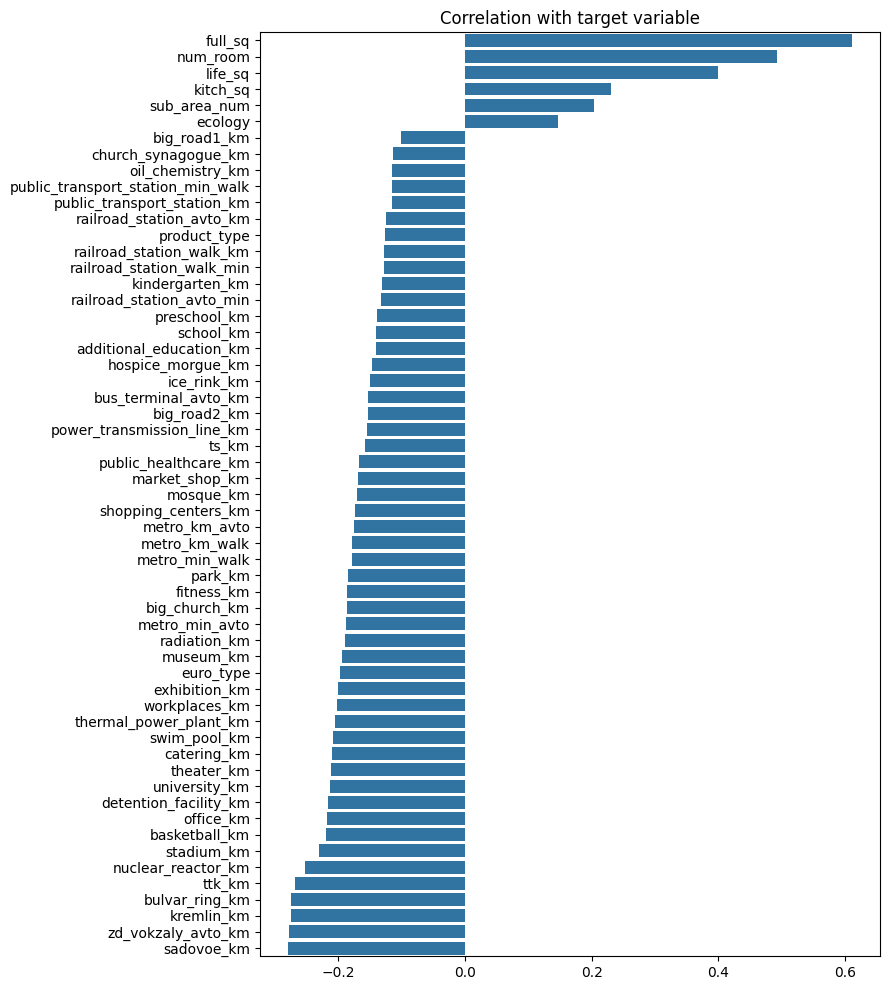

In [ ]:
feature_for_model = Corr_Barplot(df1, 0.1)

In [ ]:
feature_for_model = list(feature_for_model.keys())

In [ ]:
dfs = df1[feature_for_model + [target]]

# III Save and Load correct dataset

## 8 Save Data

In [ ]:
dfs.to_csv(path_to_work_dir + "dfs.csv", index=None)

## 9 Load Data

In [ ]:
dfs = pd.read_csv(path_to_work_dir + "dfs.csv")
target = "price_doc"

# IV Training of models

## 10 Split dataset on Train and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfs.drop(columns=target), dfs[target],
                                                    test_size=0.3, random_state=42)

### 10.1 Save split data

In [ ]:
# save test
X_test.to_csv(path_to_work_dir + "X_test.csv", index=None)
y_test.to_csv(path_to_work_dir + "y_test.csv", index=None)

# save train
X_train.to_csv(path_to_work_dir + "X_train.csv", index=None)
y_train.to_csv(path_to_work_dir + "y_train.csv", index=None)

### 10.2 Load split data

In [ ]:
X_train = pd.read_csv(path_to_work_dir + "X_train.csv")
y_train = pd.read_csv(path_to_work_dir + "y_train.csv")

X_test = pd.read_csv(path_to_work_dir + "X_test.csv")
y_test = pd.read_csv(path_to_work_dir + "y_test.csv")

## 11 Make Pipline

In [ ]:
dfs = pd.read_csv(path_to_work_dir + "dfs.csv")
target = "price_doc"

In [ ]:
binary_feature = ['product_type', 'euro_type']
categorical_feature = ['num_room', 'ecology']
scaler_feature = dfs.drop(binary_feature + categorical_feature + [target], axis=1).columns.to_list()

In [ ]:
TRANSFORMERS = []

for col in binary_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col))])))

for col in scaler_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))

for col in categorical_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('ohe', OHEEncoder(key=col))])))

In [ ]:
PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])

## 12 Definition of params for models

In [ ]:
clf_params = {
    'CatBoostRegressor': {
        'loss_function': 'RMSE',
        'depth': 6,
        'iterations': 300,
        'learning_rate': 0.01,
        'eval_metric': 'AUC',
        'verbose': 200
    },
    'XGBRFRegressor': {
        'verbosity': 1,
        'max_depth': 5,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform',
    },
    'RandomForestRegressor': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'friedman_mse',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    },
    'GradientBoostingRegressor': {
        'criterion': 'friedman_mse',
        'max_depth': 7,
        'min_samples_leaf': 10,
        'n_estimators': 300

    },
    'LogisticRegression': {
        'class_weight': 'balanced',
        'fit_intercept': True,
    }
}

## 13 GradientBoost

In [ ]:
model_gbr = Learning_model(PIPELINE, clf_params, GradientBoostingRegressor, X_train, y_train.values.reshape((1,-1))[0])

GradientBoostingRegressor
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.4min


### 13.1 Save and load model

In [ ]:
save_model_pkl(path_to_work_dir + "GBR_model.pkl", model_gbr)

In [ ]:
save_model_dill(path_to_work_dir + "GBR_model.dill", model_gbr)

In [ ]:
model_gbr_load = load_model_dill(path_to_work_dir + "GBR_model.dill")

### 13.2 Visualisation results of model

R2:	0.666
RMSE:	2518175.525
MSE:	6341207972744.361


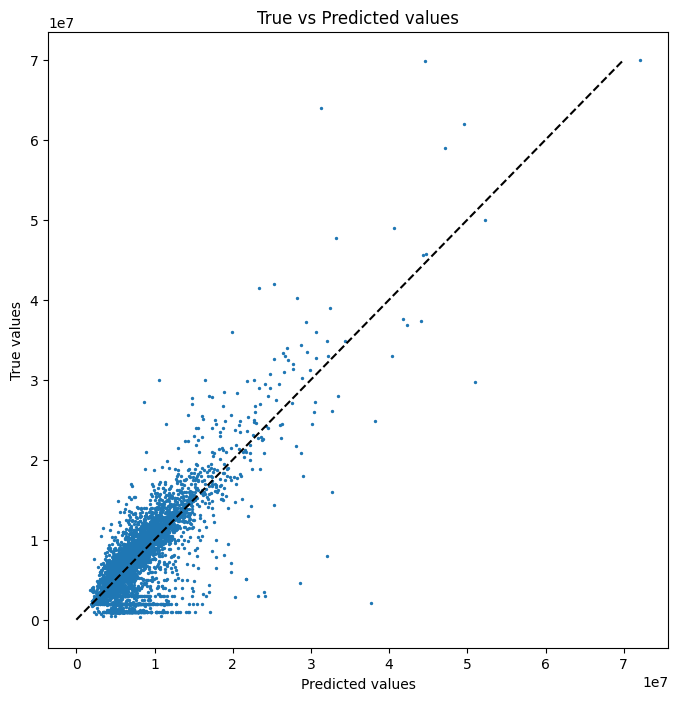

In [ ]:
y_test_preds = model_gbr_load.predict(X_test)
r2_gbr = evaluate_preds(y_test, y_test_preds)

## 14 XGBoost

In [ ]:
model_xgbr = Learning_model(PIPELINE, clf_params, XGBRFRegressor, X_train, y_train)

XGBRFRegressor
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.5s


### 14.1 Save and load model

In [ ]:
save_model(path_to_work_dir + "XGBR_model.dill", model_xgbr)

In [ ]:
model_xgbr_load = load_model(path_to_work_dir + "XGBR_model.dill")

### 14.2 Visualisation results of model

R2:	0.597
RMSE:	2767182.757
MSE:	7657300410193.161


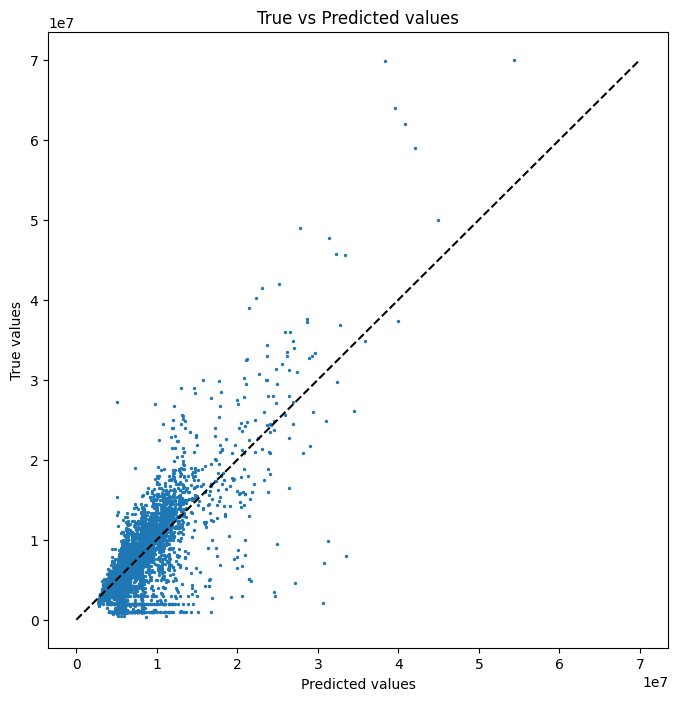

In [ ]:
y_test_preds = model_xgbr_load.predict(X_test)
r2_xgbr = evaluate_preds(y_test, y_test_preds)

## 15 CatBoostReg

In [ ]:
model_catbr = Learning_model(PIPELINE, clf_params, CatBoostRegressor, X_train, y_train)

CatBoostRegressor
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s
0:	total: 70.3ms	remaining: 21s
200:	total: 5.4s	remaining: 2.66s
299:	total: 7.11s	remaining: 0us
[Pipeline] ............... (step 2 of 2) Processing clf, total=   7.7s


### 15.1 Save and load model

In [ ]:
save_model(path_to_work_dir + "CatBR_model.dill", model_catbr)

In [ ]:
model_catbr_load = load_model(path_to_work_dir + "CatBR_model.dill")

### 15.2 Visualisation results of model

R2:	0.621
RMSE:	2683979.546
MSE:	7203746204716.275


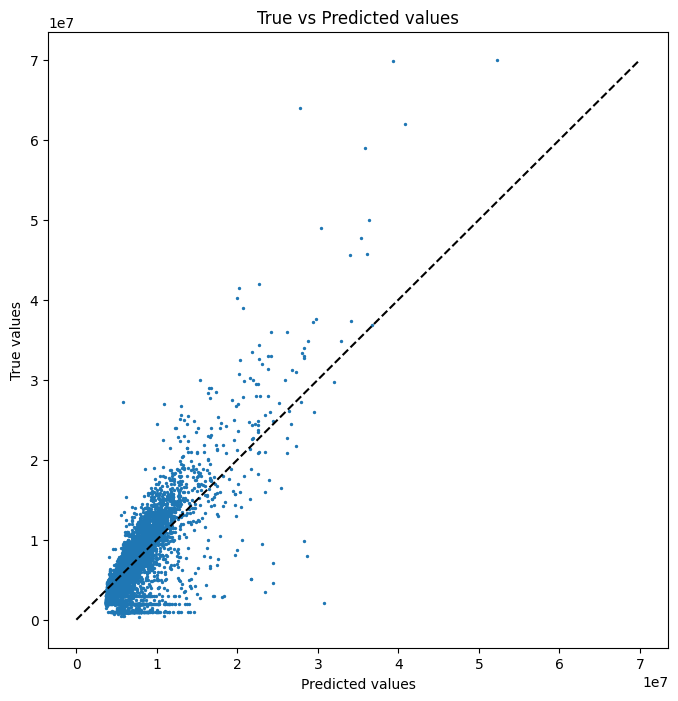

In [ ]:
y_test_preds = model_catbr_load.predict(X_test)
r2_catbr = evaluate_preds(y_test, y_test_preds)

## 16 RandomForestReg

In [ ]:
model_rfr = Learning_model(PIPELINE, clf_params, RandomForestRegressor, X_train, y_train)

RandomForestRegressor
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.9s


### 16.1 Save and load model

In [ ]:
save_model(path_to_work_dir + "RFR_model.dill", model_rfr)

In [ ]:
model_rfr_load = load_model(path_to_work_dir + "RFR_model.dill")

### 16.2 Visualisation results of model

R2:	0.536
RMSE:	2966851.171
MSE:	8802205873288.31


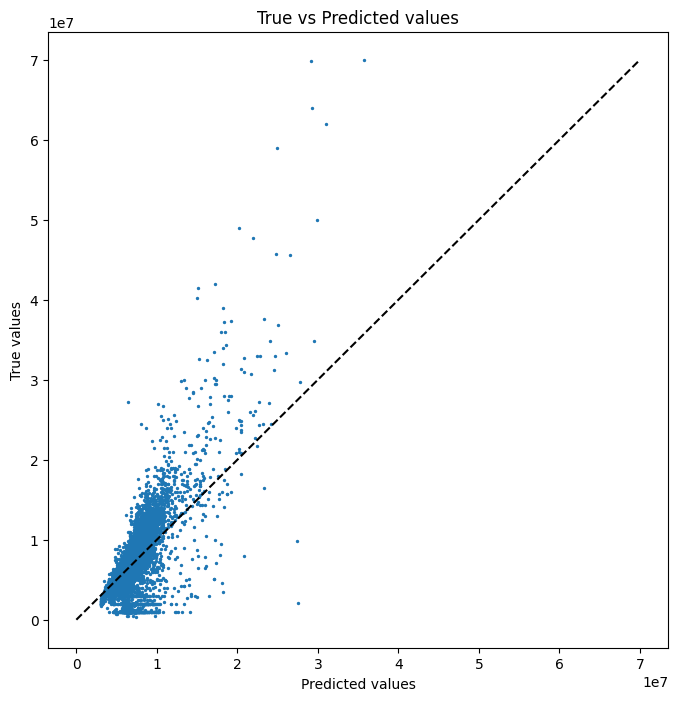

In [ ]:
y_test_preds = model_rfr_load.predict(X_test)
r2_rfr = evaluate_preds(y_test, y_test_preds)

# V Best model

In [ ]:
df_r2 = pd.DataFrame({"Model":["GBR", "XGBR", "CatBR", "RFR"],
                      "R2": [r2_gbr, r2_xgbr, r2_catbr, r2_rfr]})

In [ ]:
df_r2.to_csv(path_to_work_dir + "df_r2.csv", index=None)

In [ ]:
r2df = pd.read_csv(path_to_work_dir + "df_r2.csv")

In [ ]:
r2df

Model     R2
0    GBR  0.666
1   XGBR  0.597
2  CatBR  0.621
3    RFR  0.536

In [ ]:
best_model = r2df[r2df["R2"] == r2df["R2"].max()]["Model"].values[0]

In [ ]:
best_model

'GBR'